In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
from tqdm import tqdm_notebook, tnrange
from utils import Logger

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=[20,10])
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    
def move_folders(from_dir, to_dir, folder_names):
    for i in folder_names:
        shutil.move(os.path.join(from_dir, i),to_dir)
        
def noise(input_shape,latent_shape):    
    return Variable(torch.randn(input_shape,latent_shape))

def target(input_shape, ones = True):
    if ones:
        return Variable(torch.ones(input_shape,1))
    else:
        return Variable(torch.zeros(input_shape, 1))


In [3]:
batch_size = 32

trns = transforms.Compose([
    transforms.Resize((26,26)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_data = datasets.MNIST(root = '../../Deep_learning_data',train= True,transform=trns,download = True)
test_data = datasets.MNIST(root = '../../Deep_learning_data', train = False, transform = trns, download = True)

train_dataloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True, num_workers = 4)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size = batch_size,shuffle = True, num_workers = 4)

In [4]:
def train_dis(optimizer,real_data, fake_data):
    size = real_data.size(0)
    
    optimizer.zero_grad()
    #training on real data
    pred_real = dis(real_data)
    err_real = loss(pred_real, target(size).cuda())
    err_real.backward()
    
    #training on fake data
    pred_fake = dis(fake_data)
    err_fake = loss(pred_fake, target(size, ones = False).cuda())
    err_fake.backward()
    
    optimizer.step()
    
    return err_real + err_fake, pred_real, pred_fake

In [5]:
def train_gen(optimizer, fake_data):
    size = fake_data.size(0)
    
    optimizer.zero_grad()
    
    preds = dis(fake_data)
    err = loss(preds,target(size).cuda())
    err.backward()
    
    optimizer.step()
    
    return err, preds

## Defining network

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        input_shape = 28 * 28
        n_out = 1
        
        self.linear1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 5),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3))
        
        self.linear2 = nn.Sequential(nn.Conv2d(8, 16, kernel_size = 5),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        
        self.linear3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size = 5),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.linear4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size = 5),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.linear5 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 5),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3),
                                     nn.Conv2d(128, 1, kernel_size = 6),
                                     nn.Sigmoid())
        
        
    def forward(self, x):
        x = self.linear1(x.view([32,1,26,26]))
        x = self.linear3(self.linear2(x))
        x = self.linear5(self.linear4(x))
#         print(x.size())
        return x
        

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        input_features = 100
        output_shape = 28 * 28
        
        self.linear1 = nn.Sequential(nn.ConvTranspose2d(input_features,128, kernel_size = 5),
                                    nn.ReLU(),
                                    nn.Dropout(0.3))
        
        self.linear2 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size = 5),
                                     nn.ReLU(),
                                     nn.Dropout(0.3))
        
        self.linear3 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size = 5),
                                     nn.ReLU(),
                                     nn.Dropout(0.3),
                                     nn.ConvTranspose2d(32,16, kernel_size = 5),
                                     nn.ReLU(),
                                     nn.Dropout(0.3),
                                     nn.ConvTranspose2d(16,8, kernel_size = 5),
                                     nn.ReLU(),
                                     nn.Dropout(0.3),
                                     nn.ConvTranspose2d(8,1, kernel_size = 6))
        
    def forward(self,x):
        x = self.linear1(x.reshape([32,100,1,1]))
        x = self.linear3(self.linear2(x))
#         print(x.size())
        return x

In [13]:
image_shape = 28*28
latent_shape = 100
dis = Discriminator().cuda()
gen = Generator().cuda()

d_optim = torch.optim.Adam(dis.parameters(),lr = 0.0002)
g_optim = torch.optim.Adam(gen.parameters(),lr = 0.0002)

loss = nn.BCELoss()

In [14]:
num_test_samples = 32
test_noise = noise(num_test_samples,latent_shape)

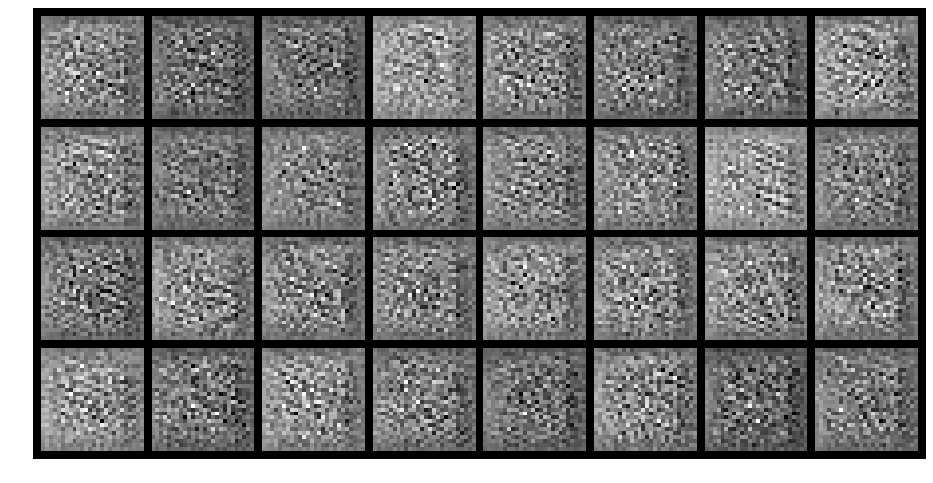

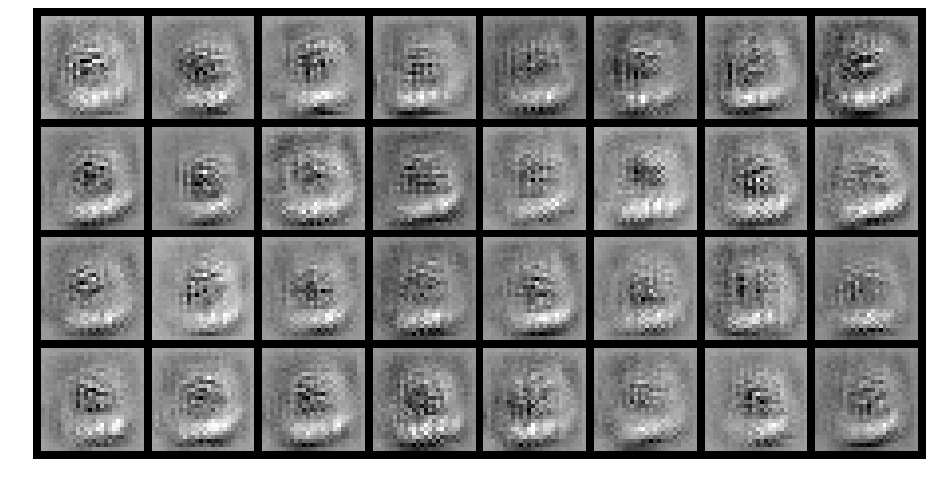

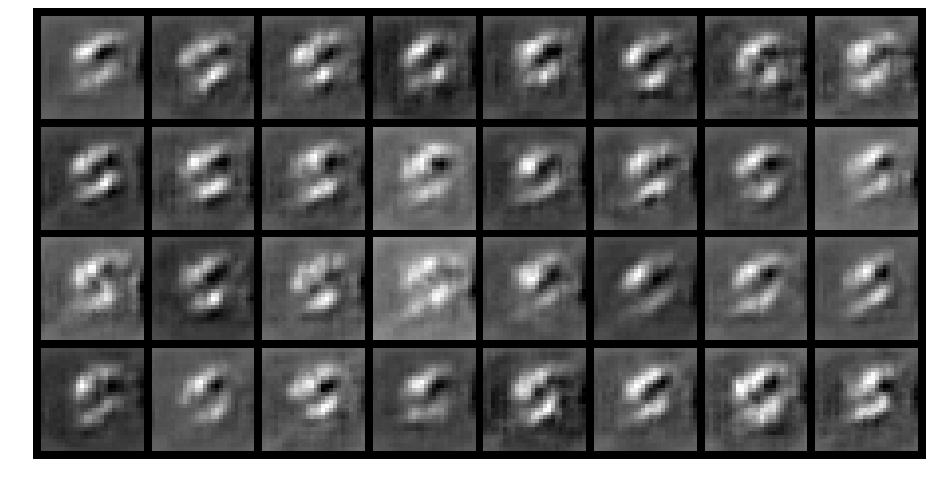

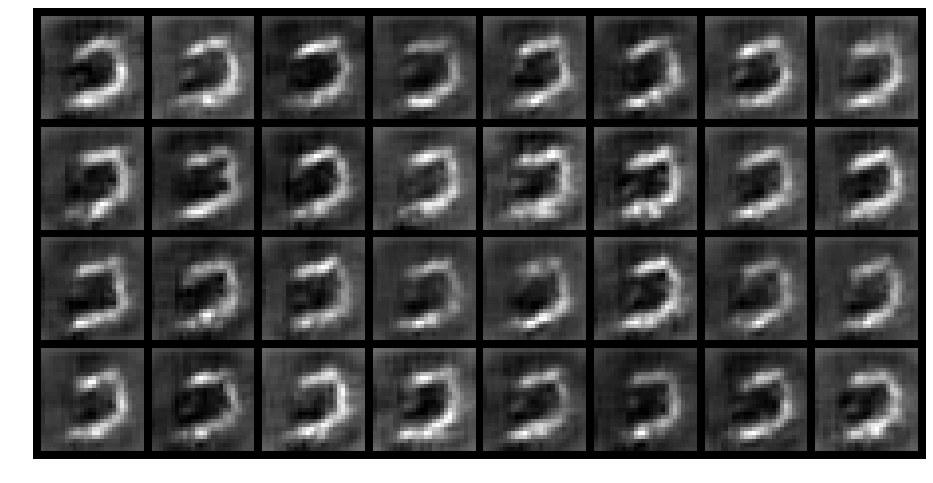

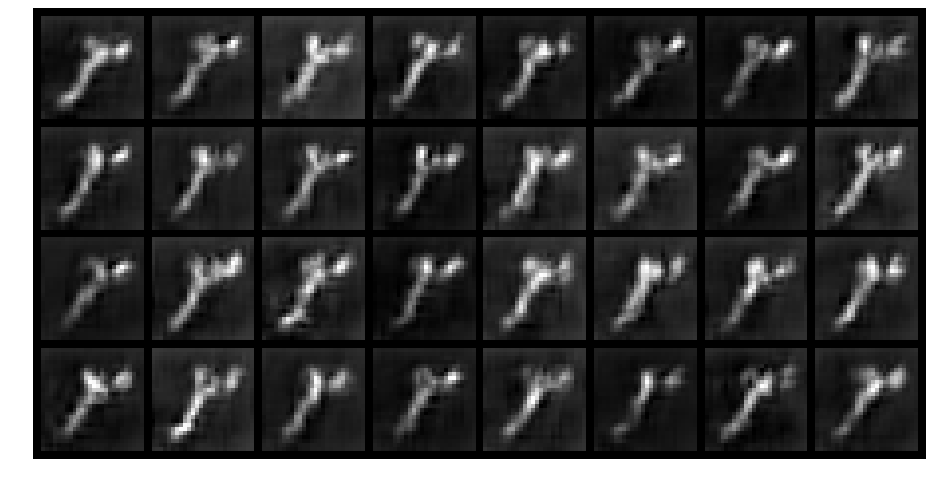

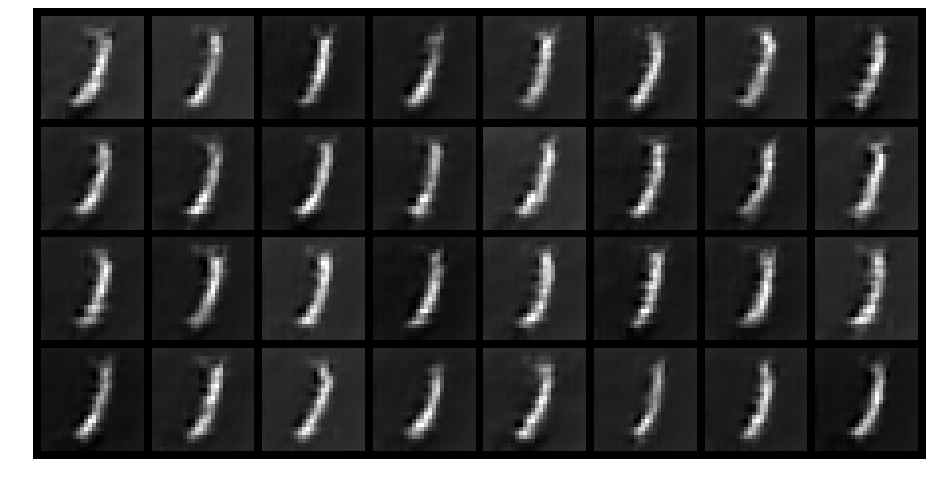

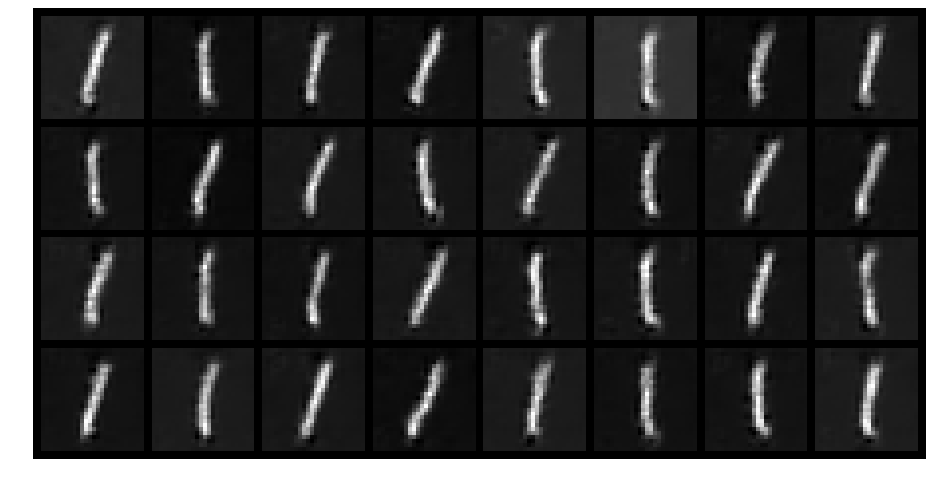

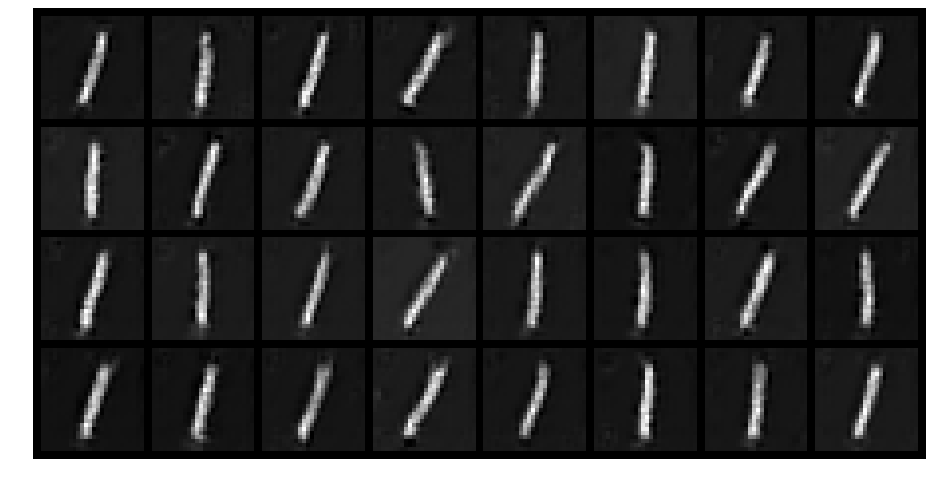

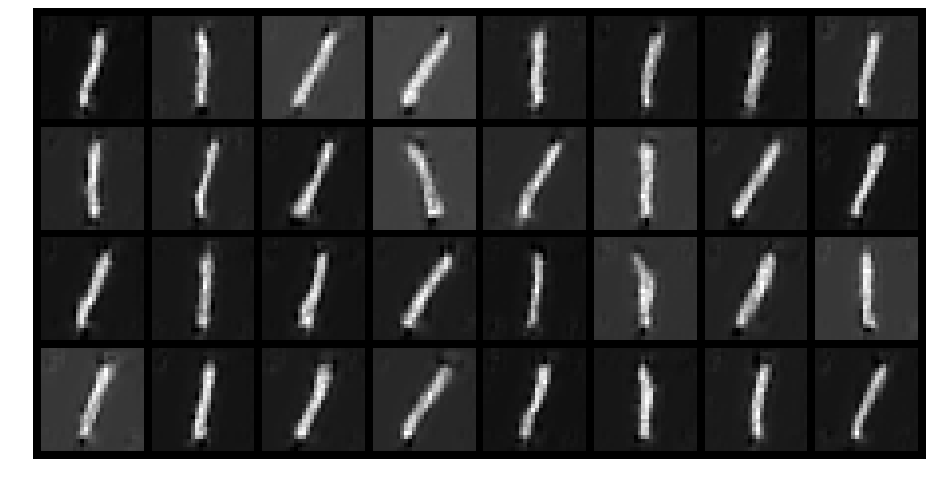

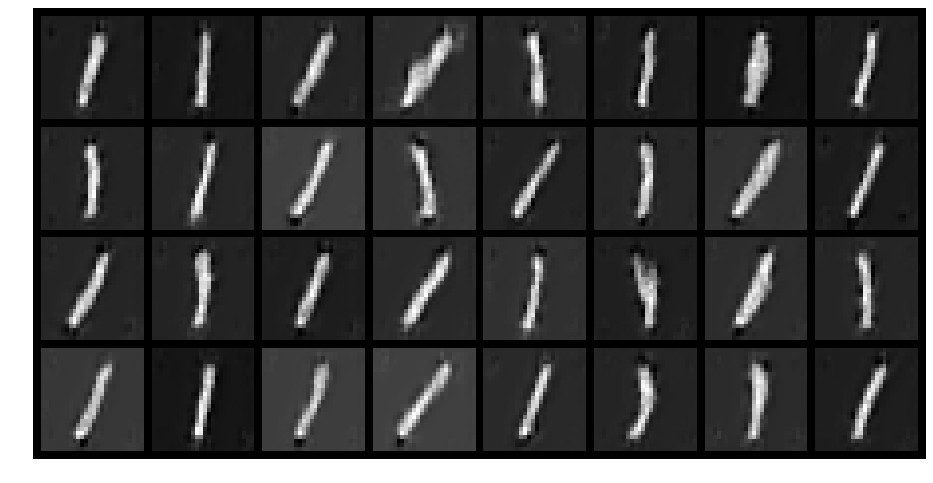

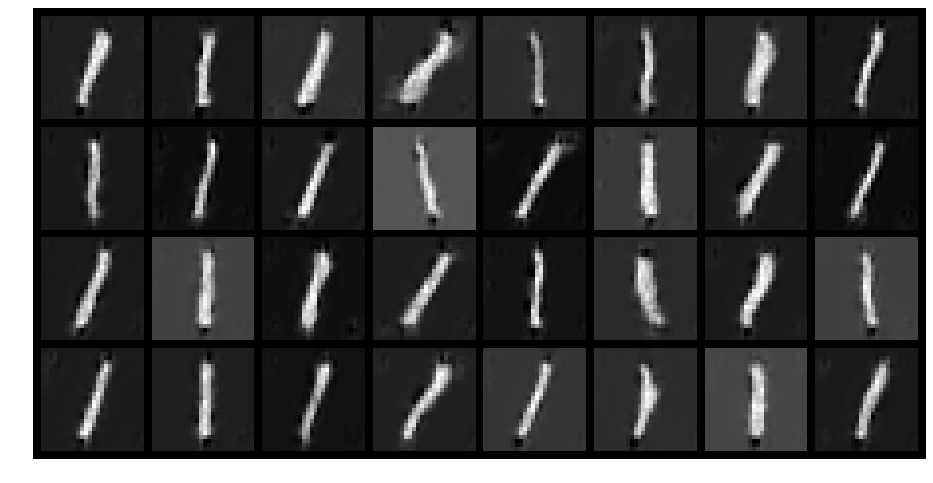

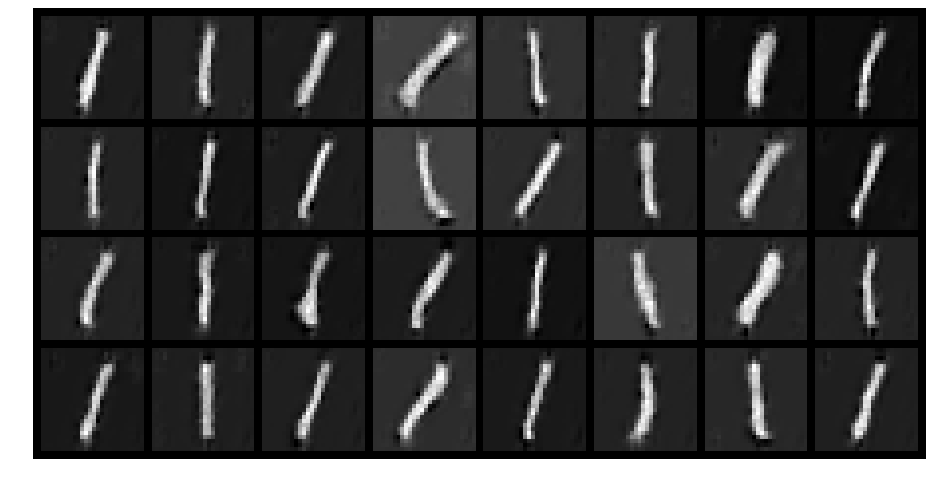

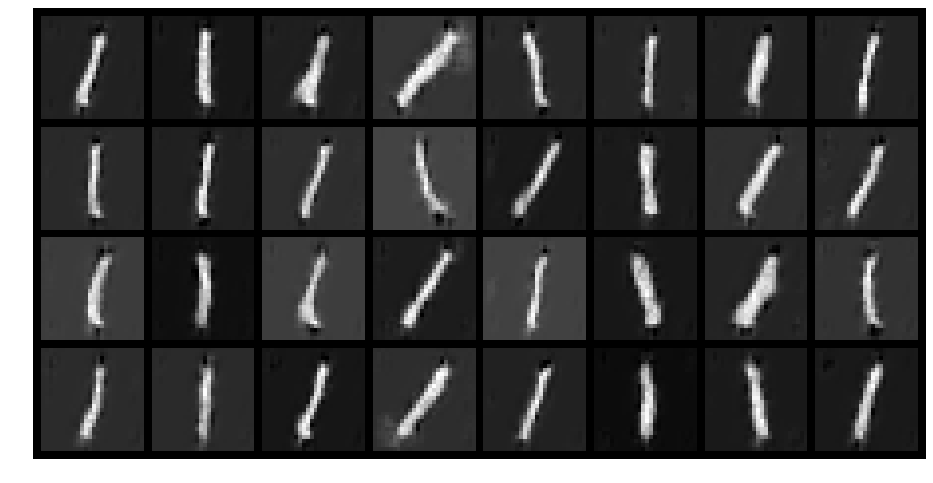

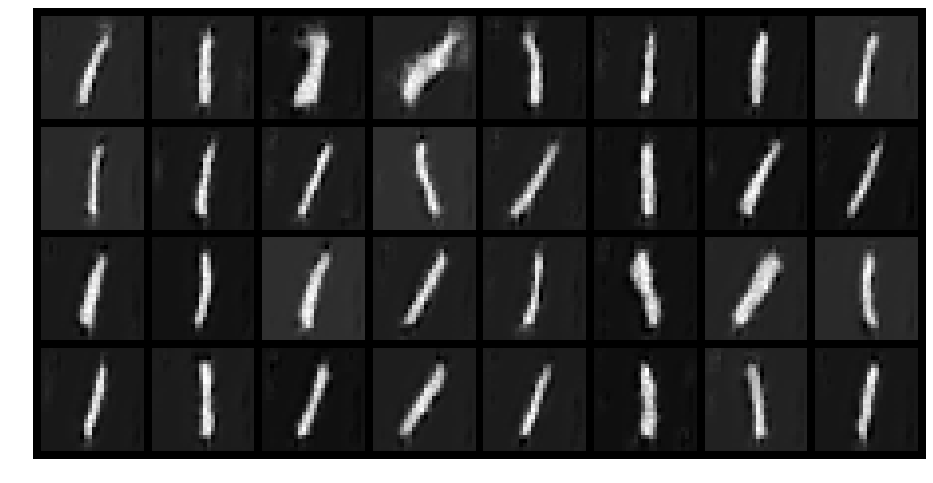

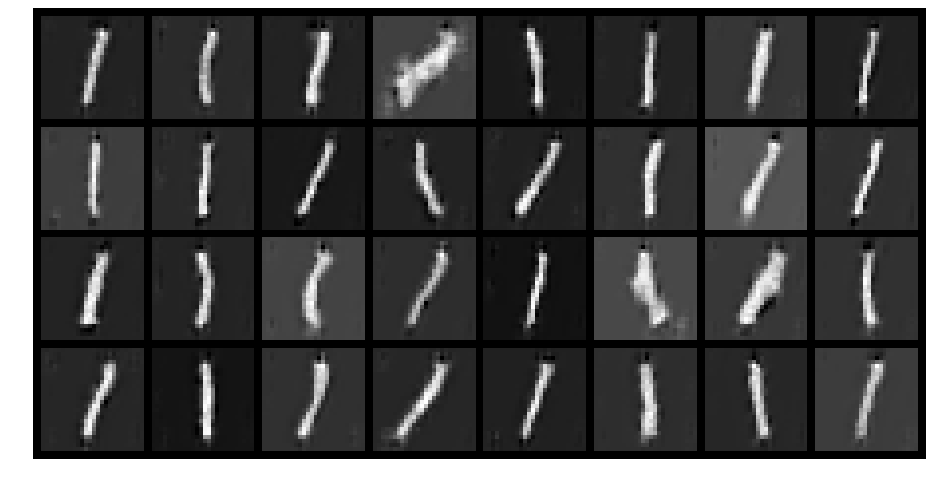

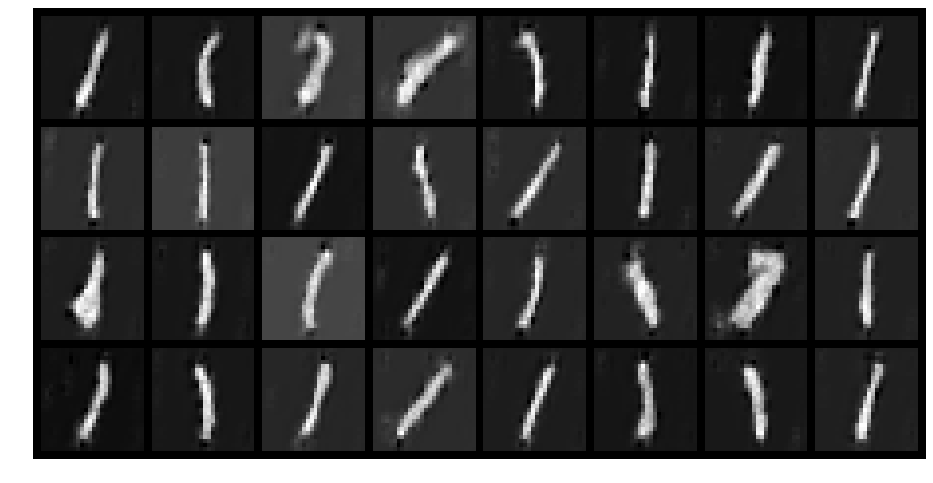

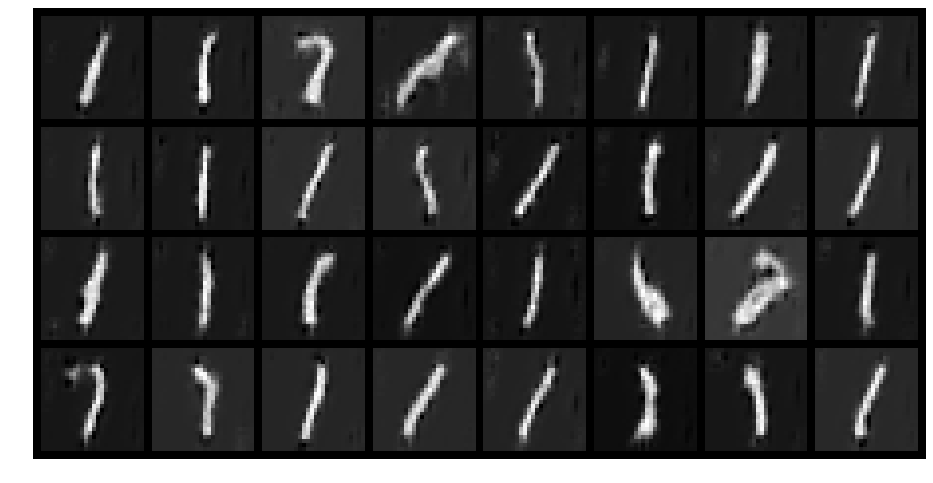

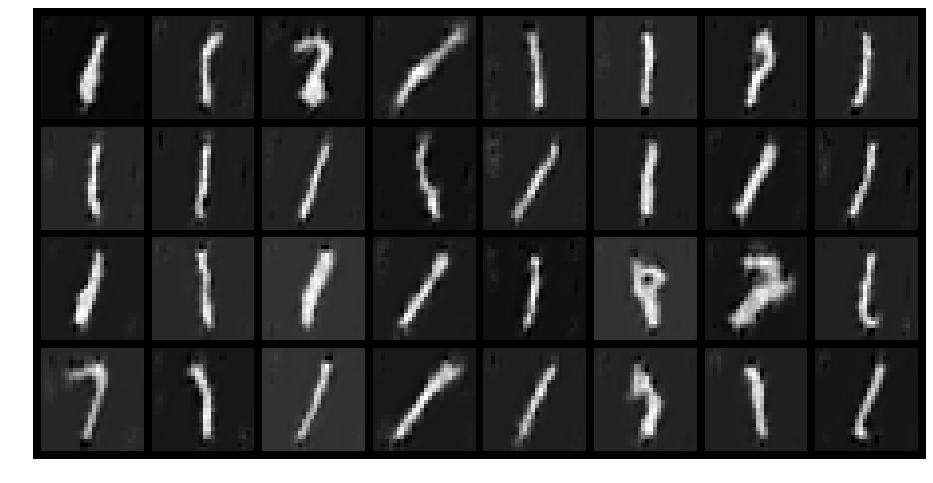

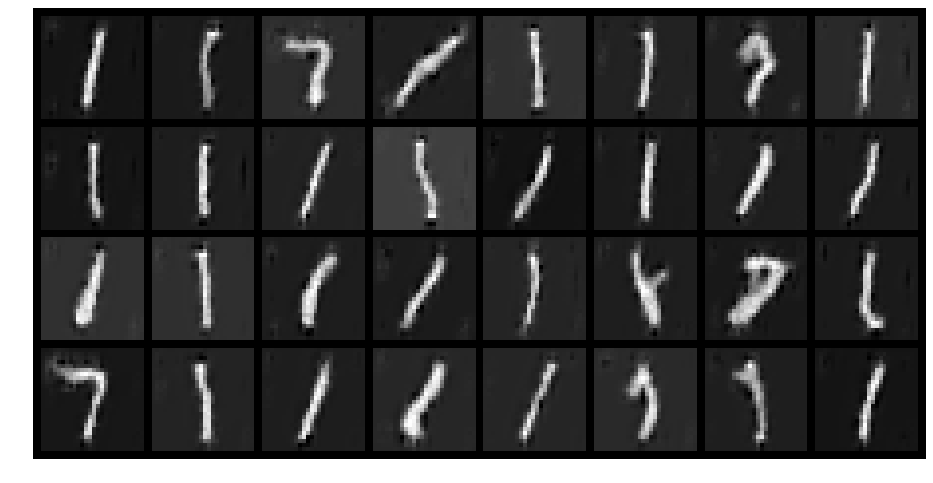

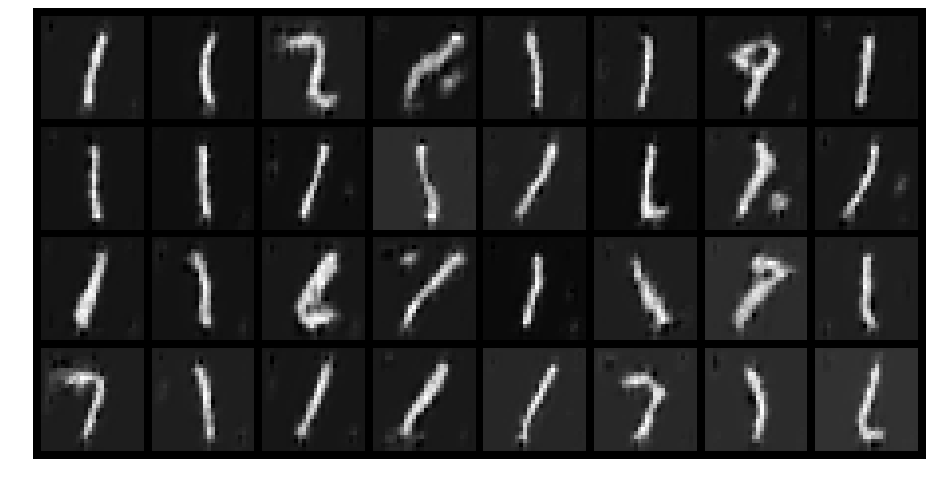

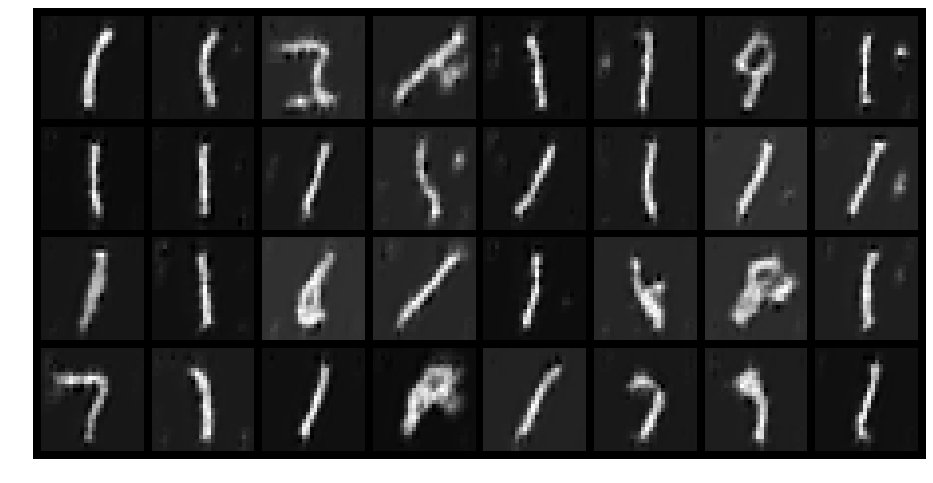

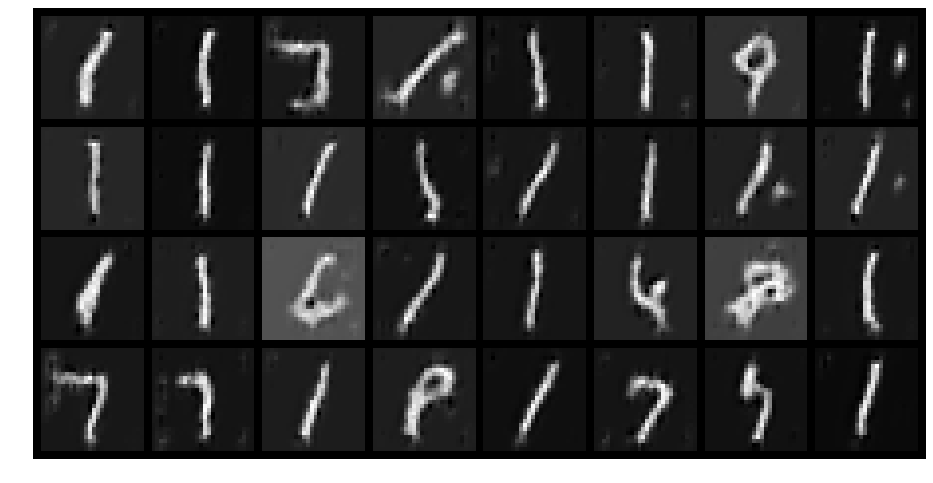

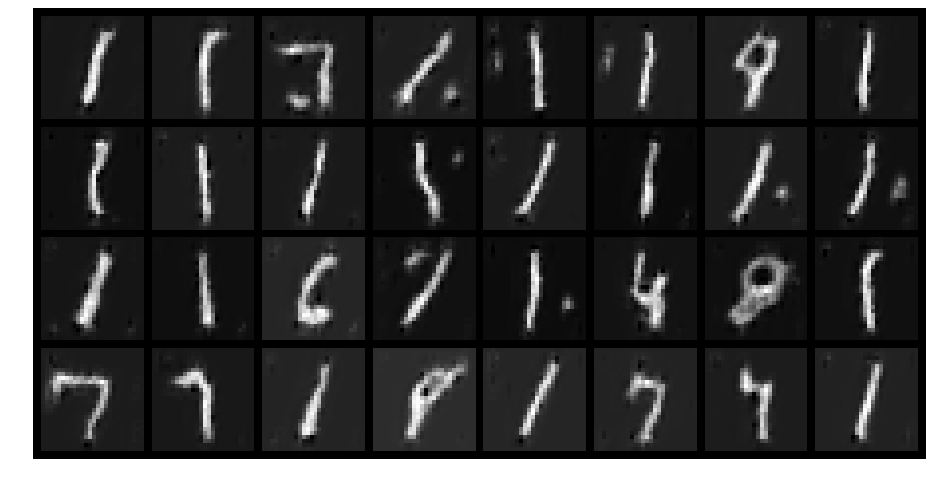

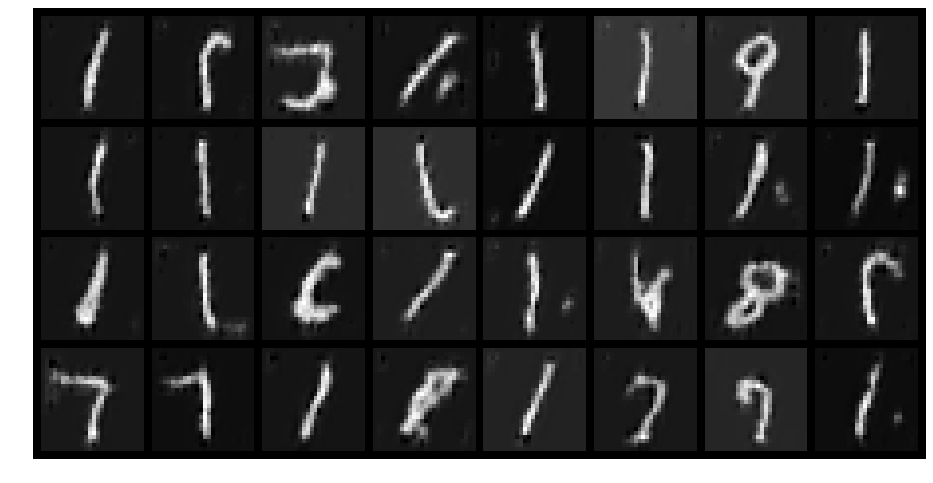

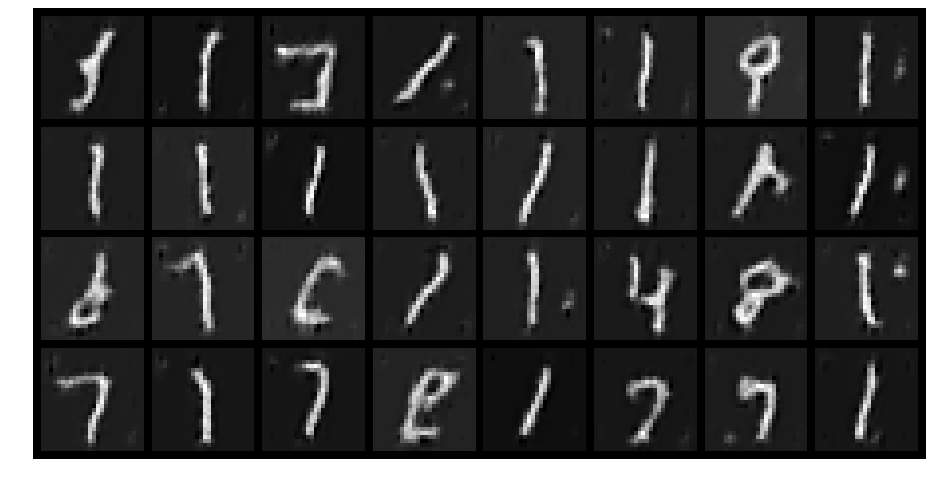

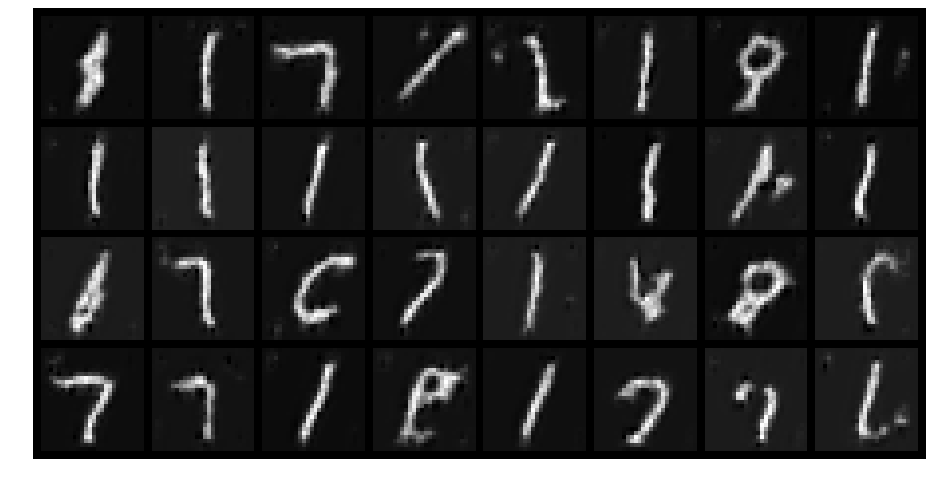

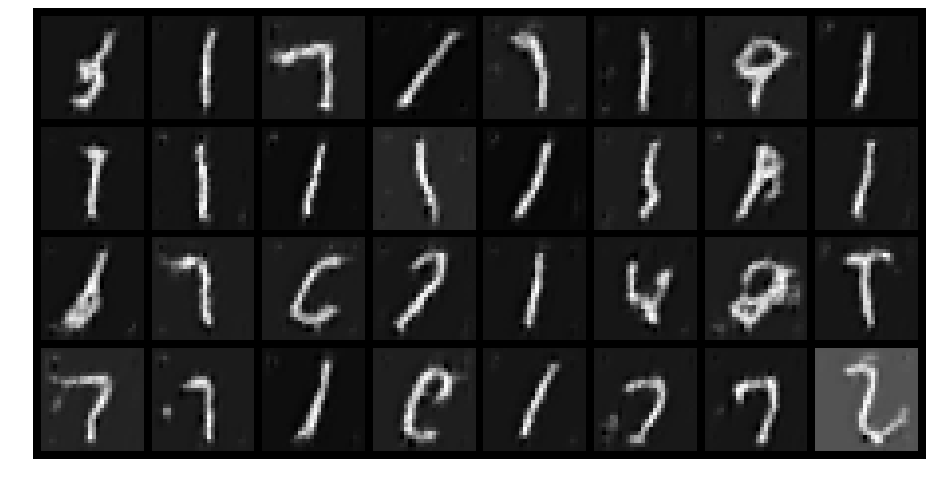

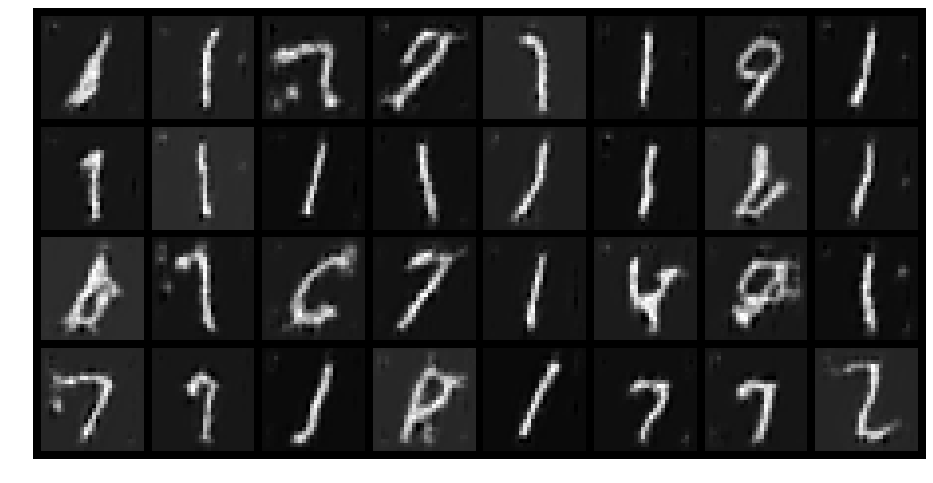

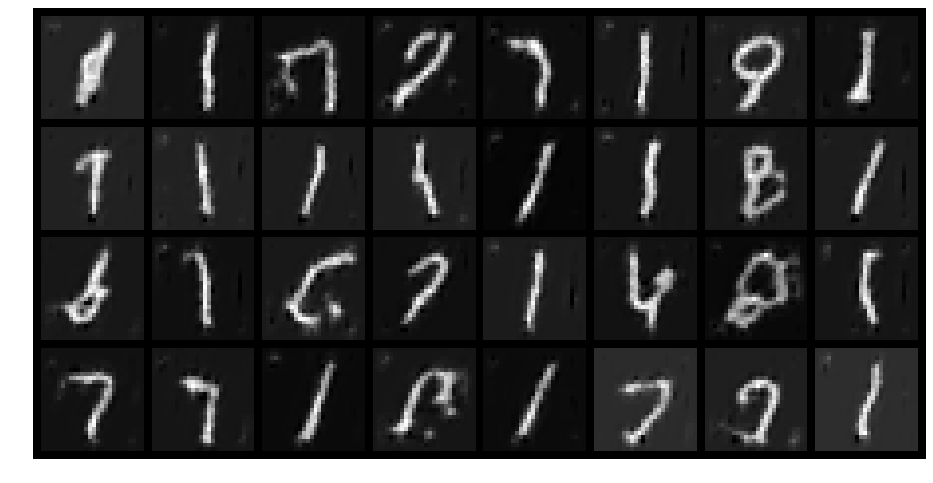

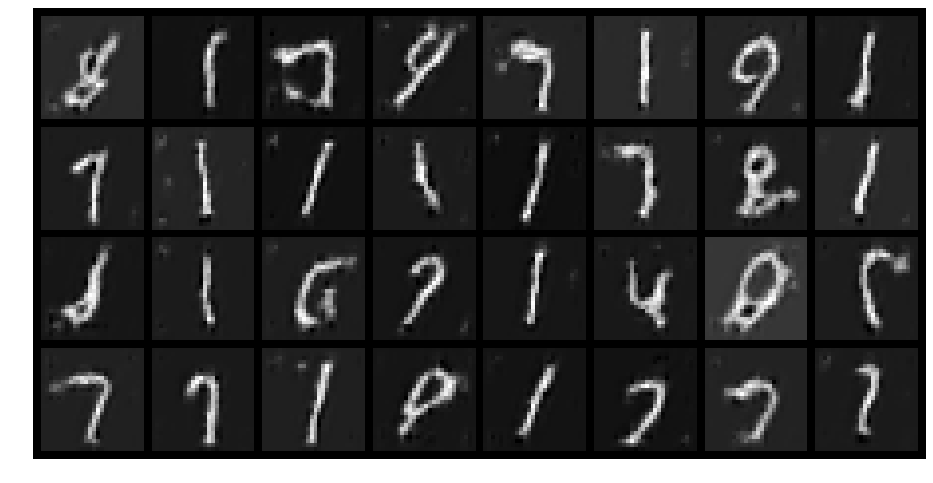

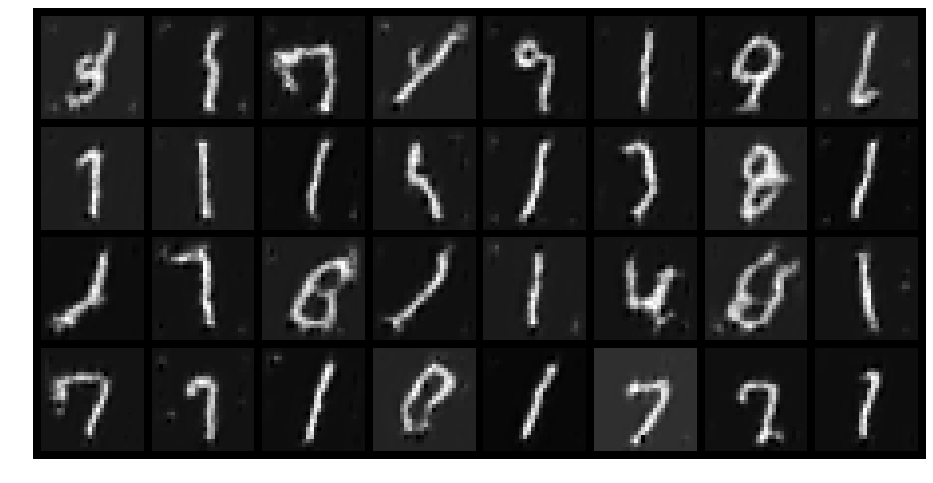

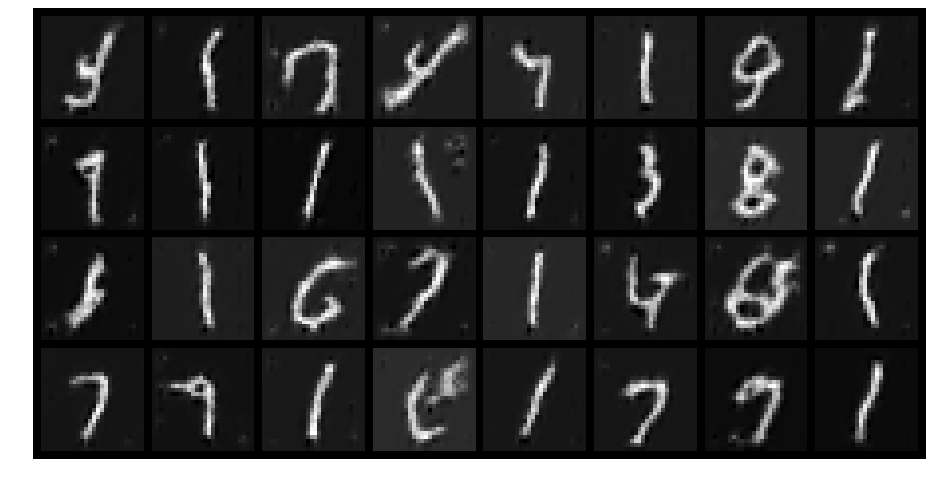

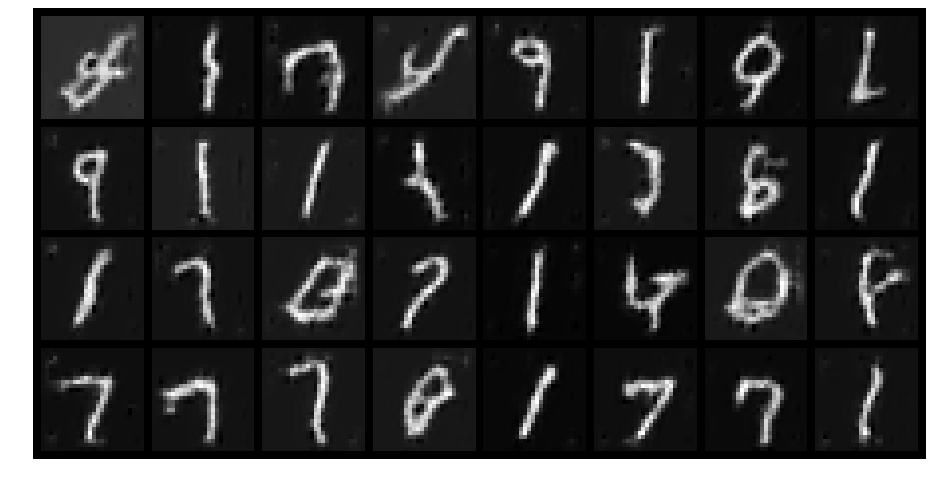

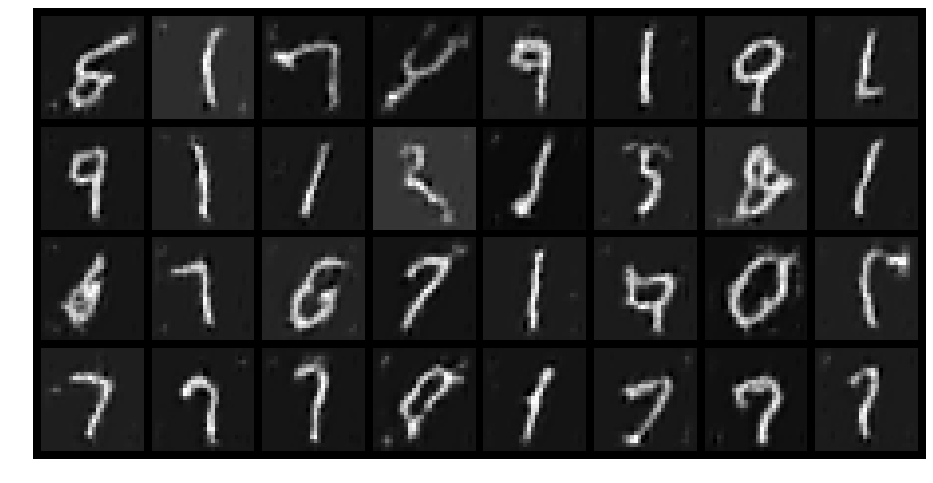

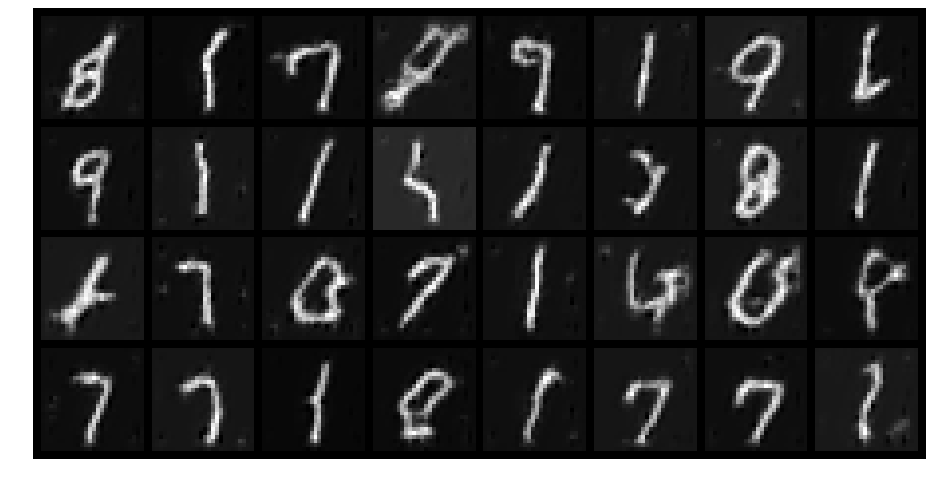

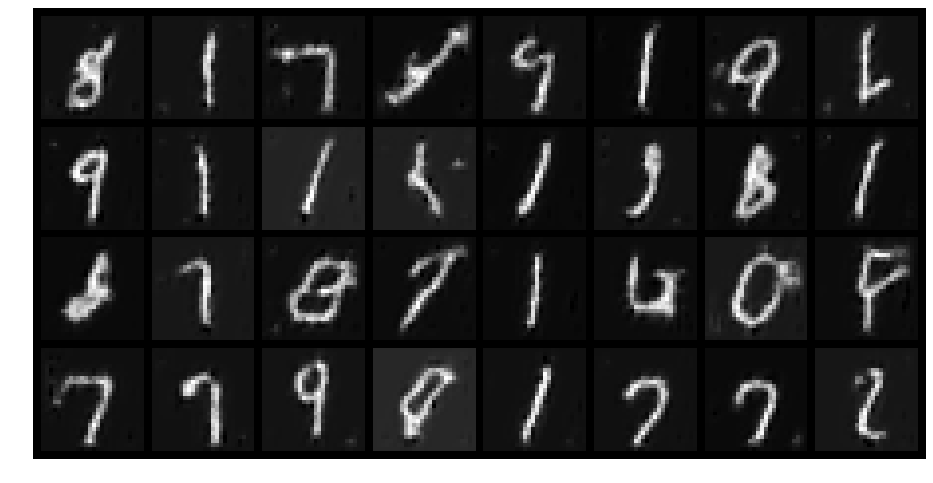

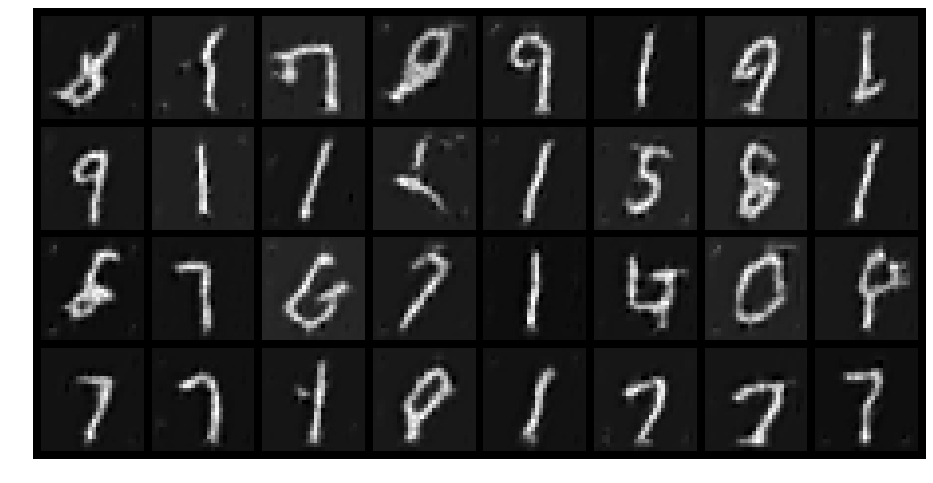

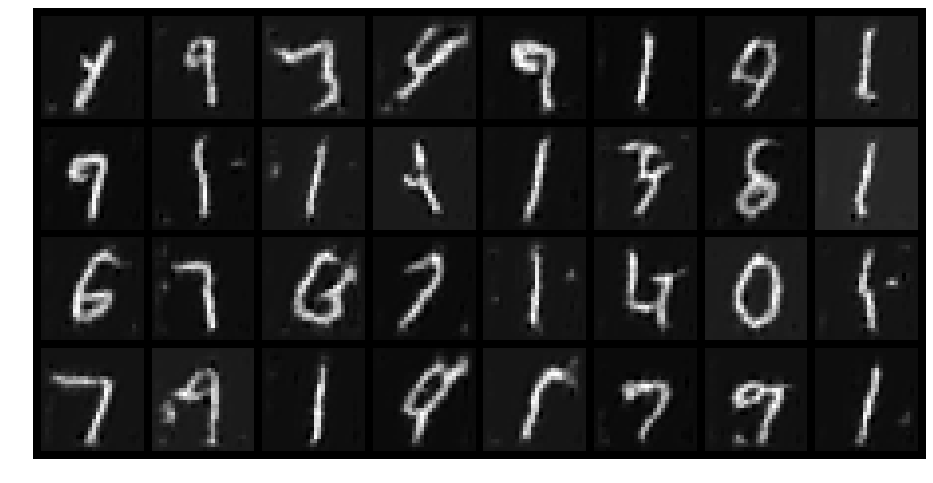

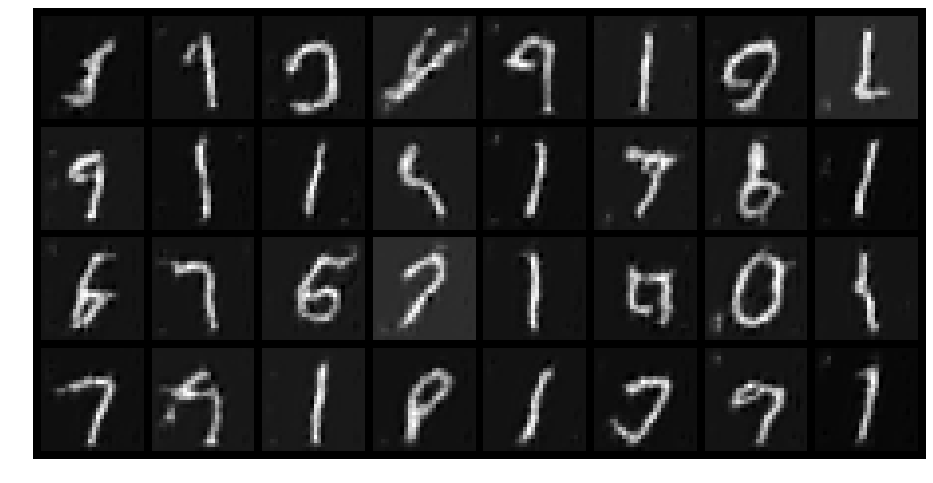

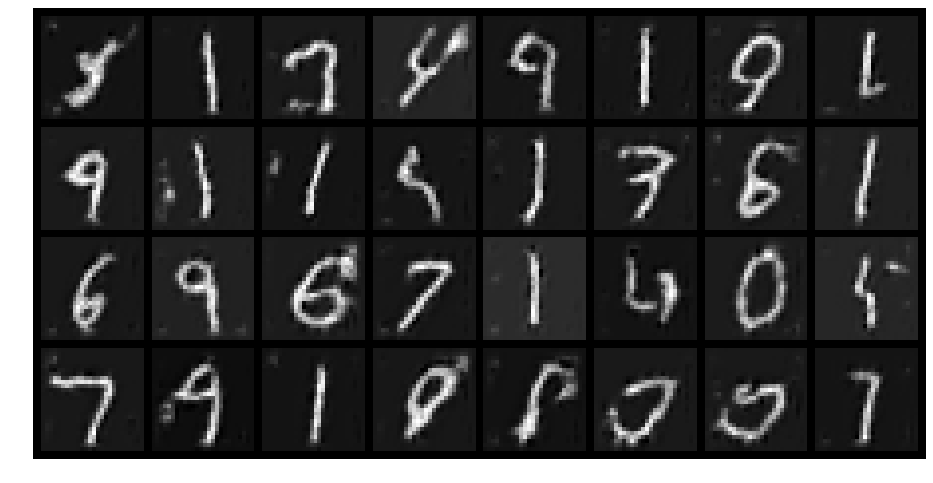

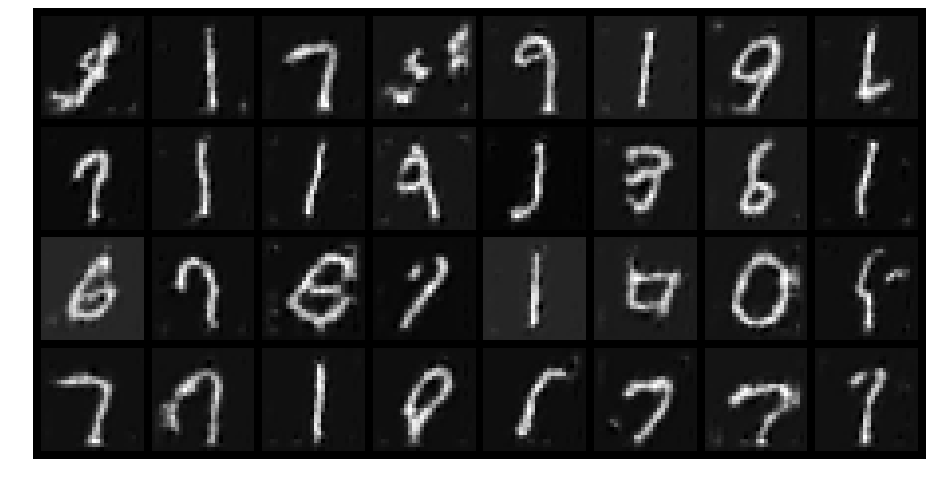

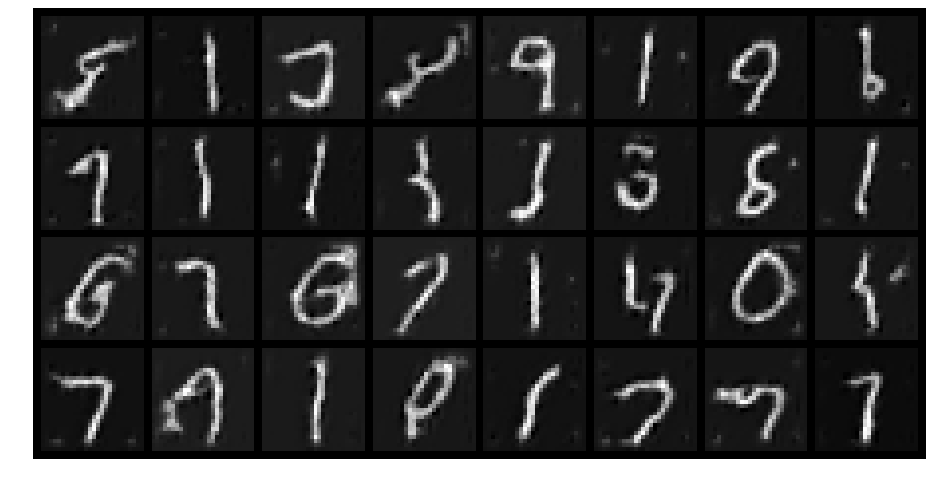

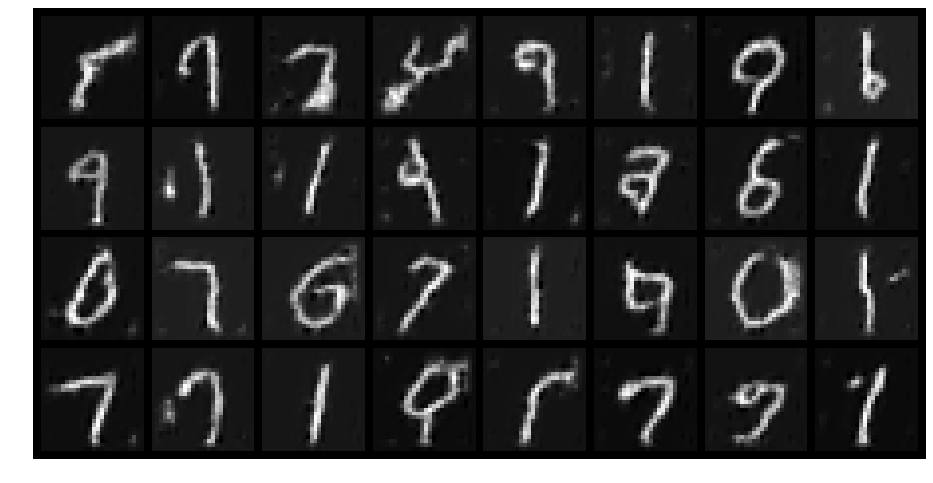

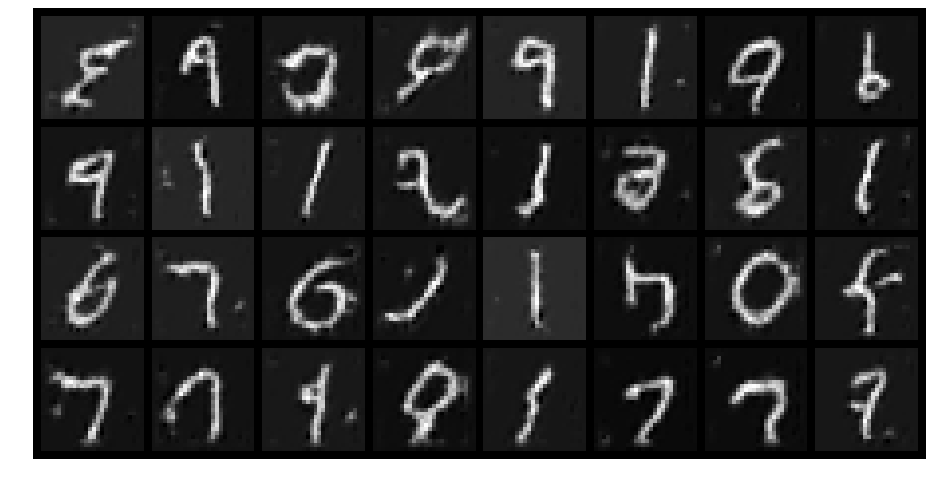

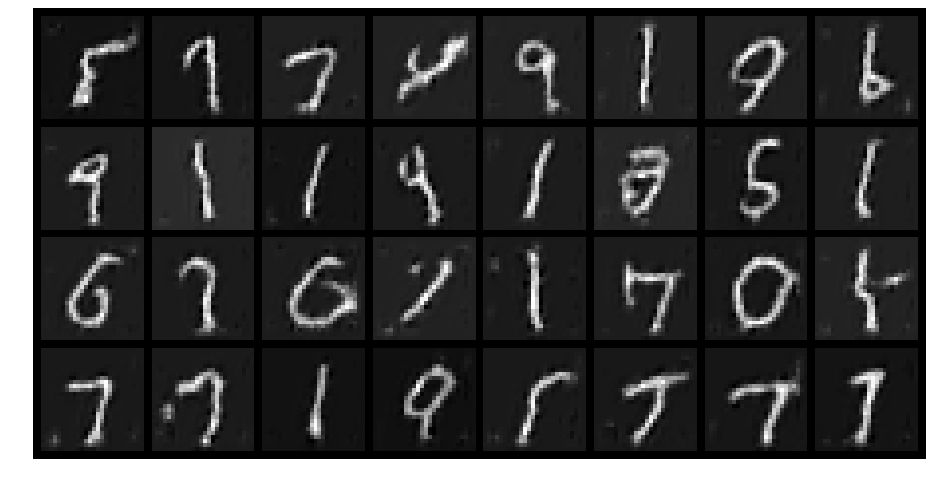

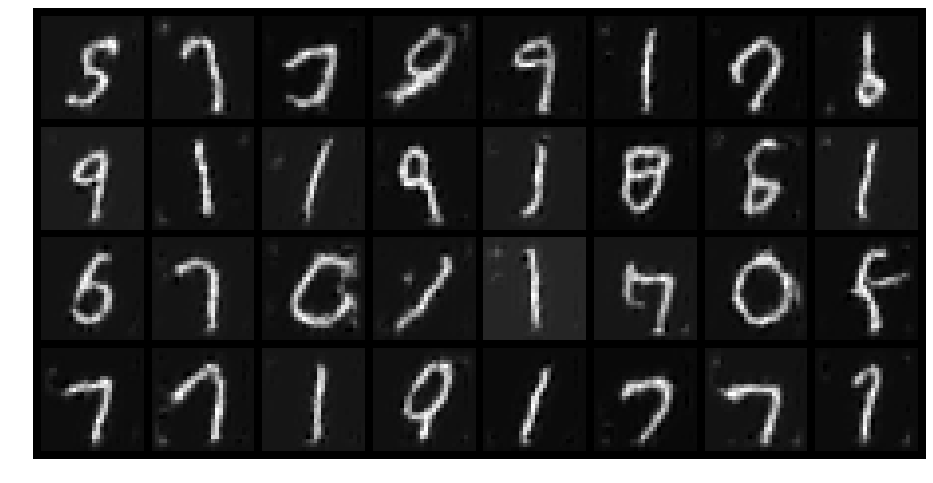

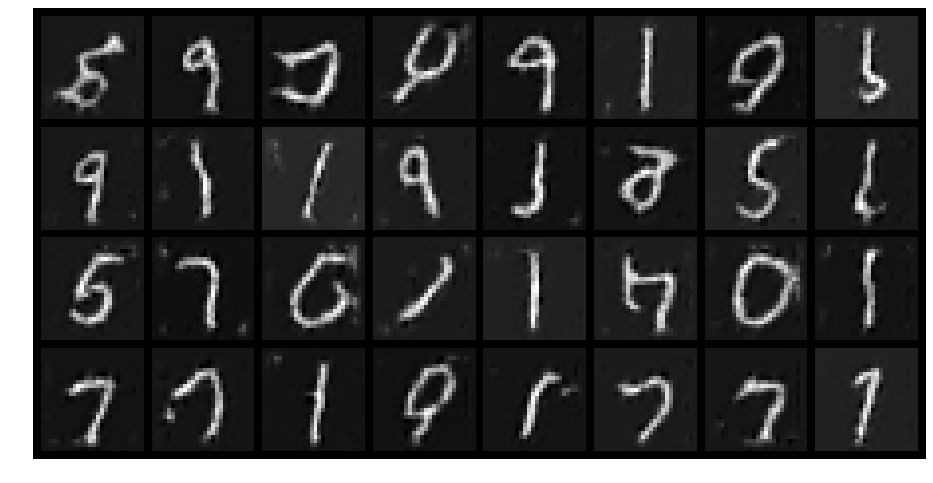

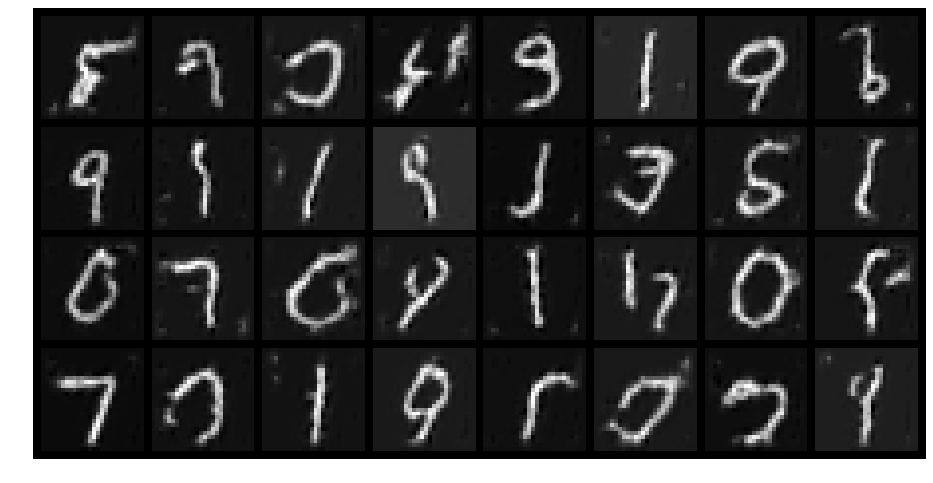

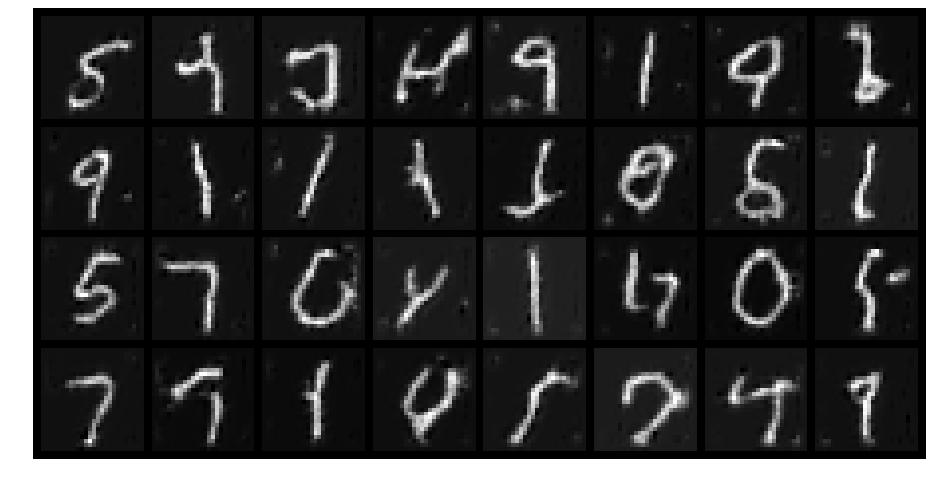

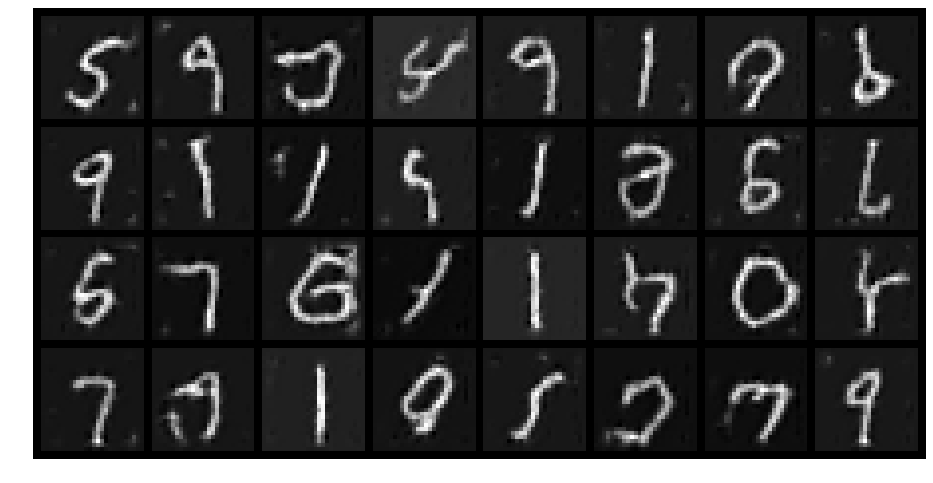

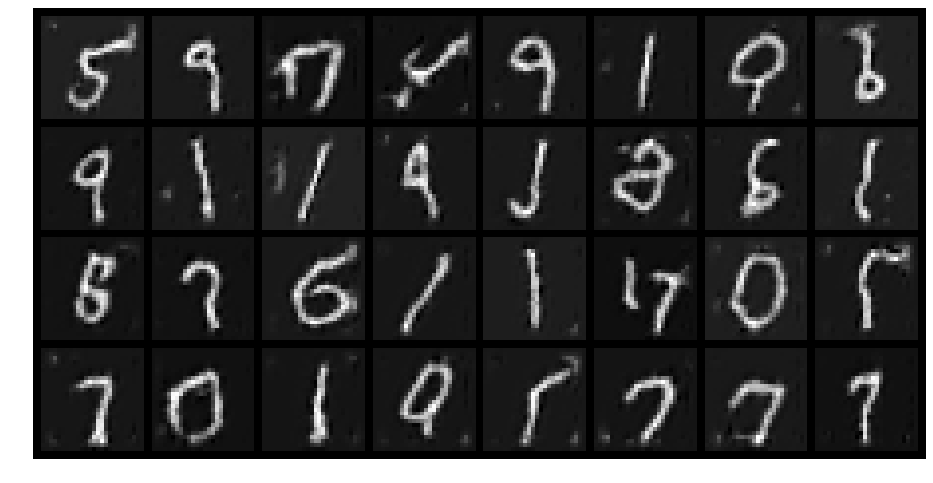

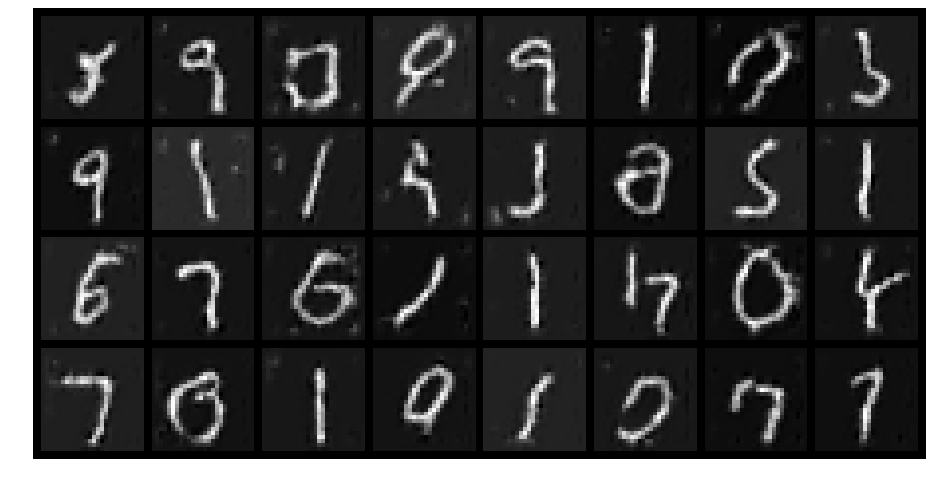

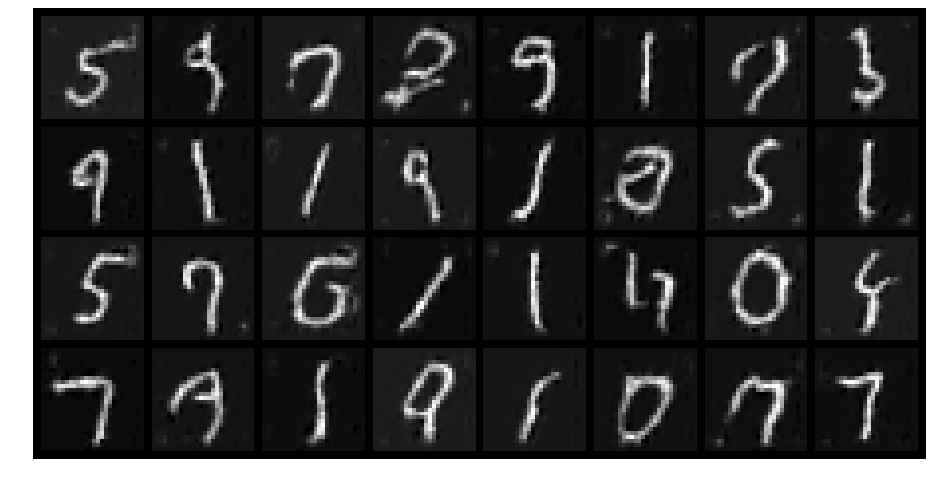

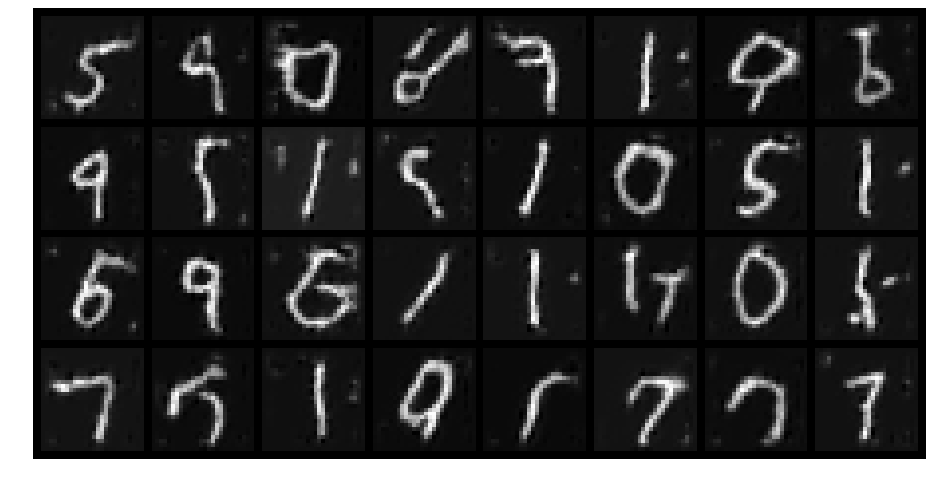

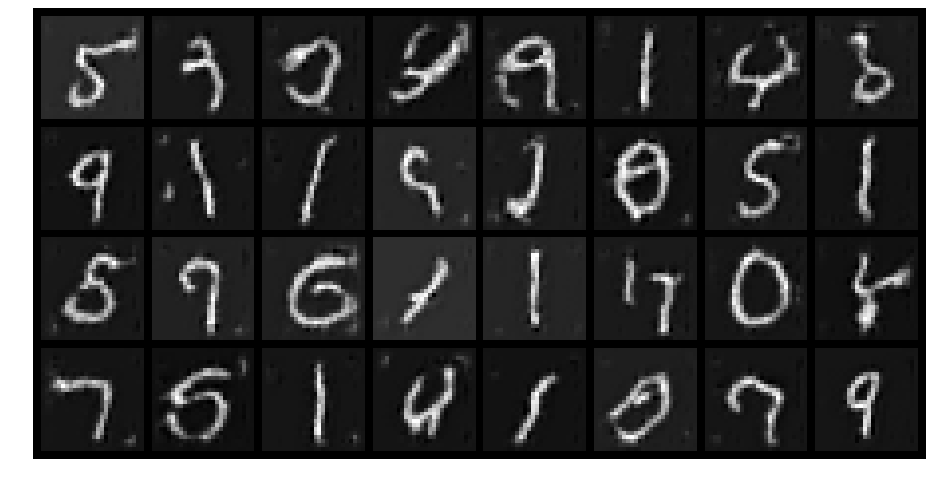

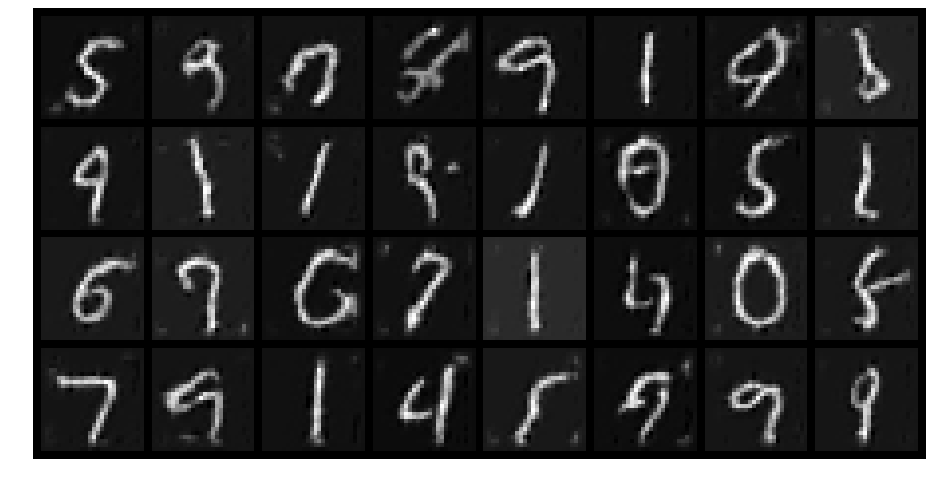

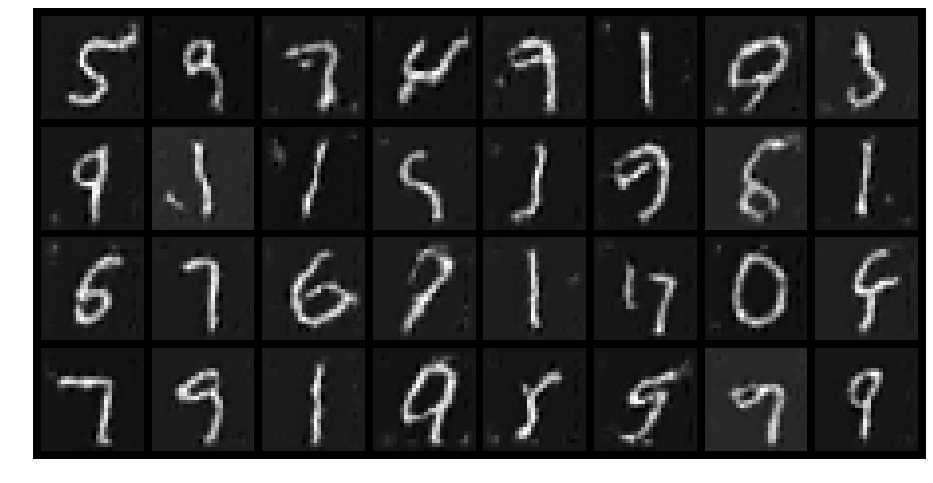

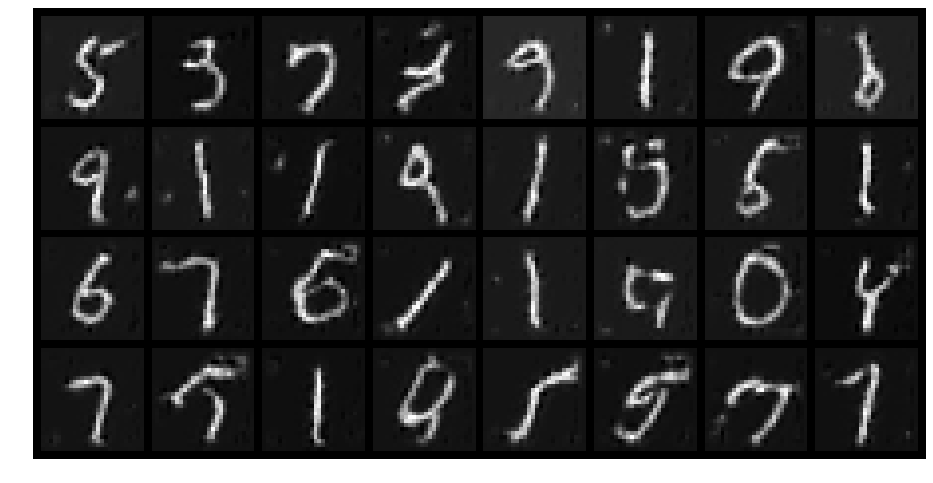

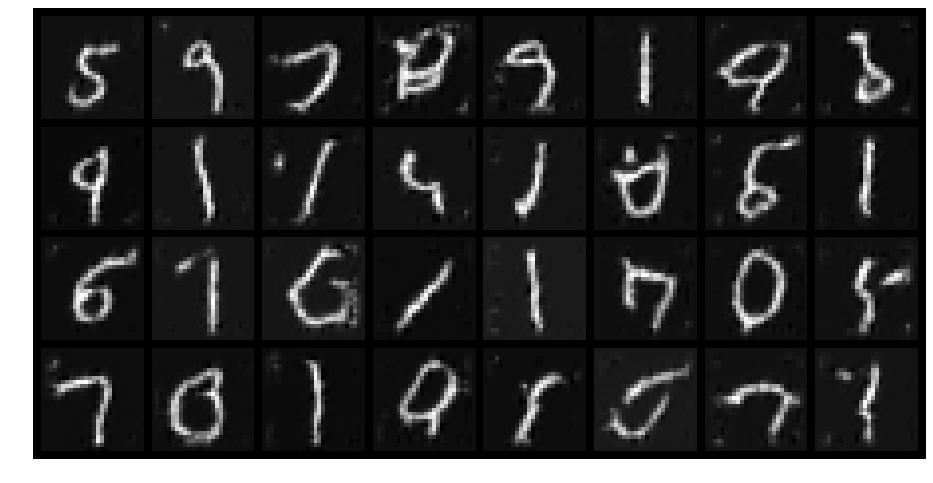

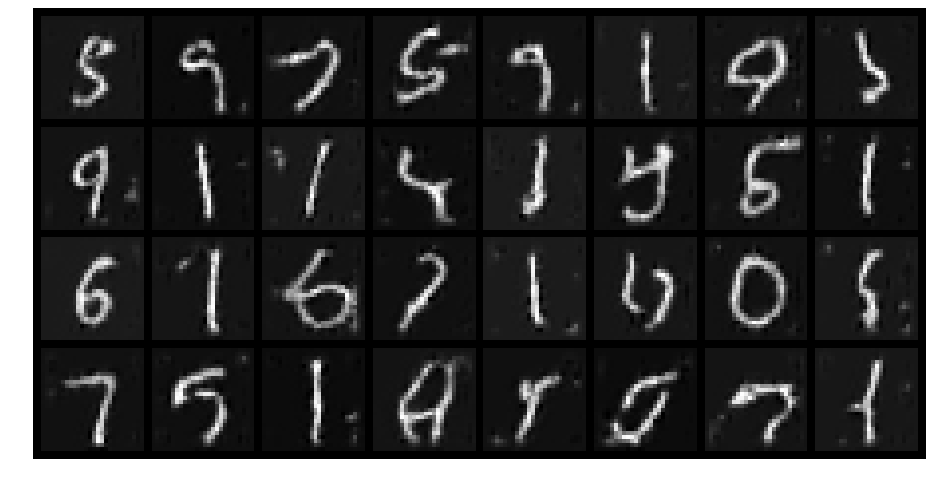

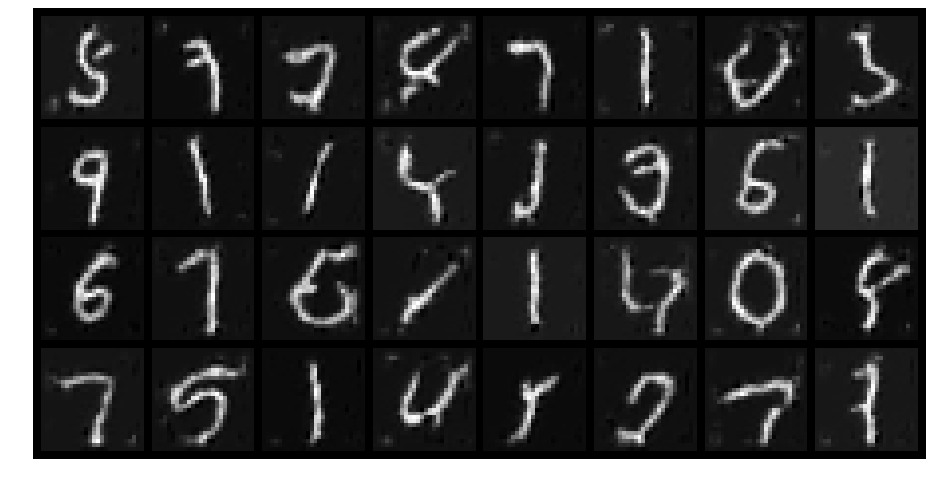

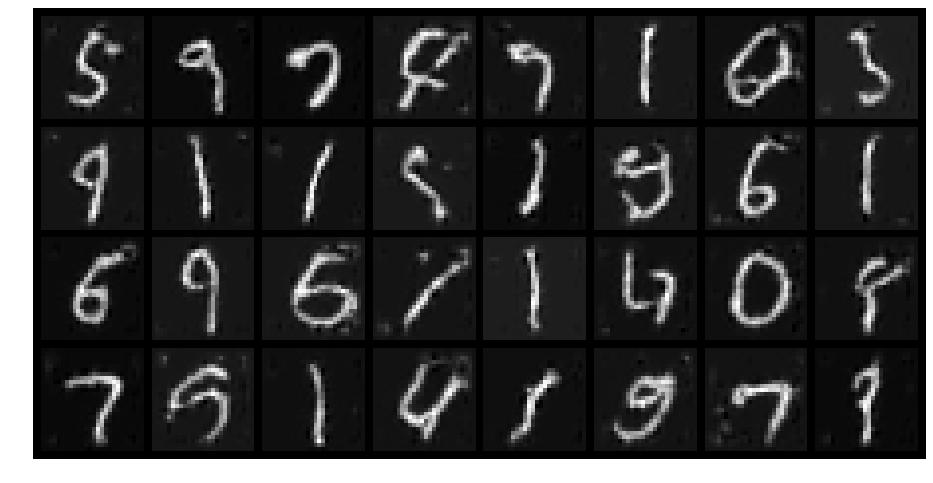

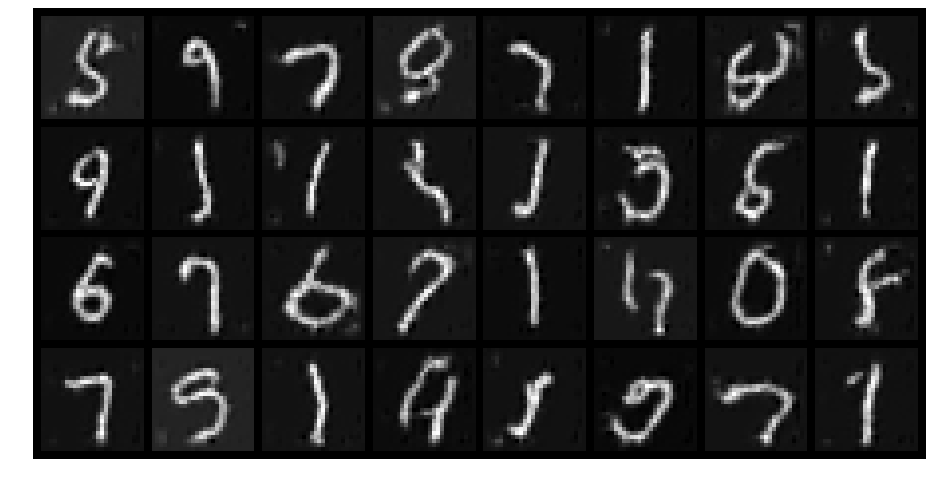

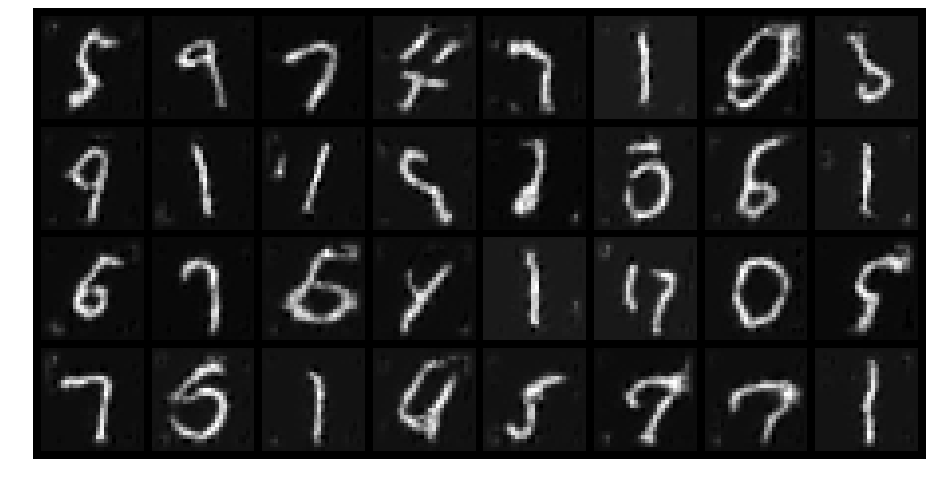

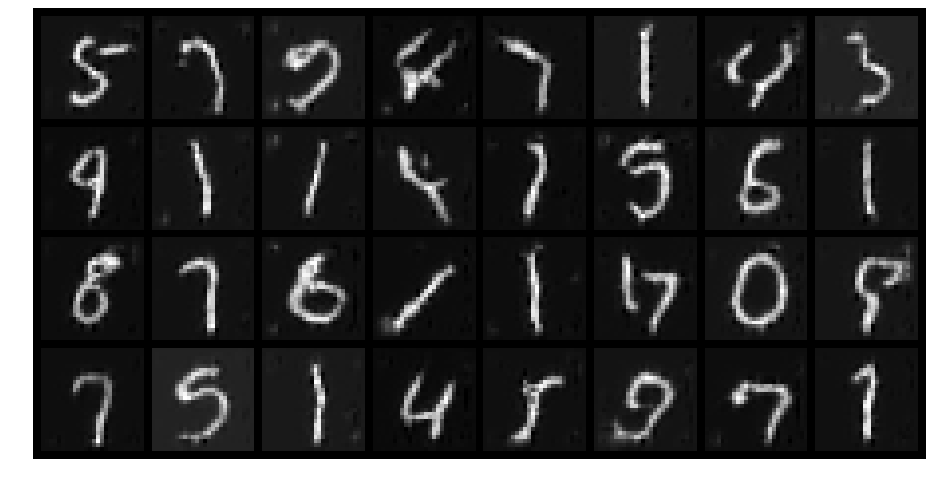

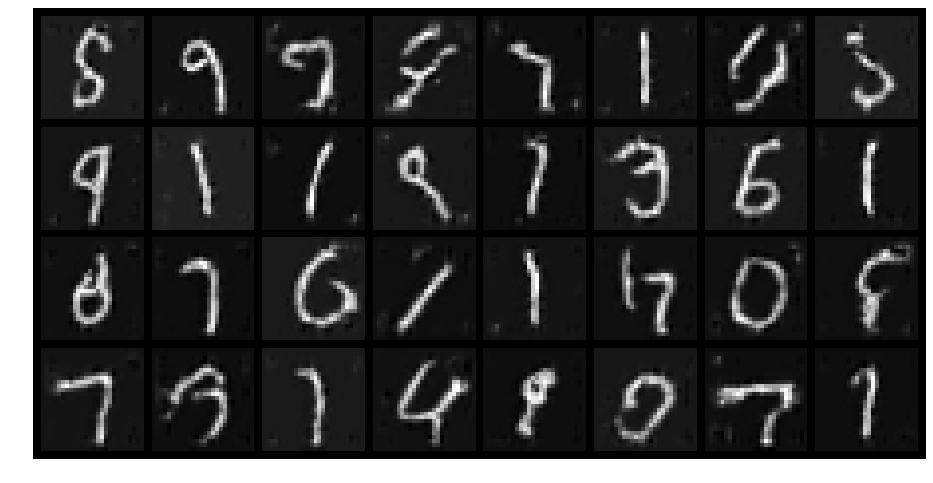

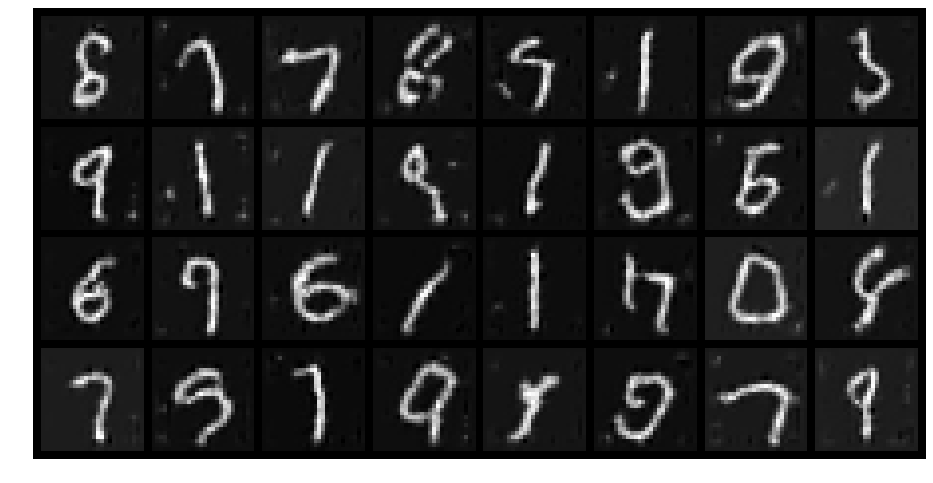

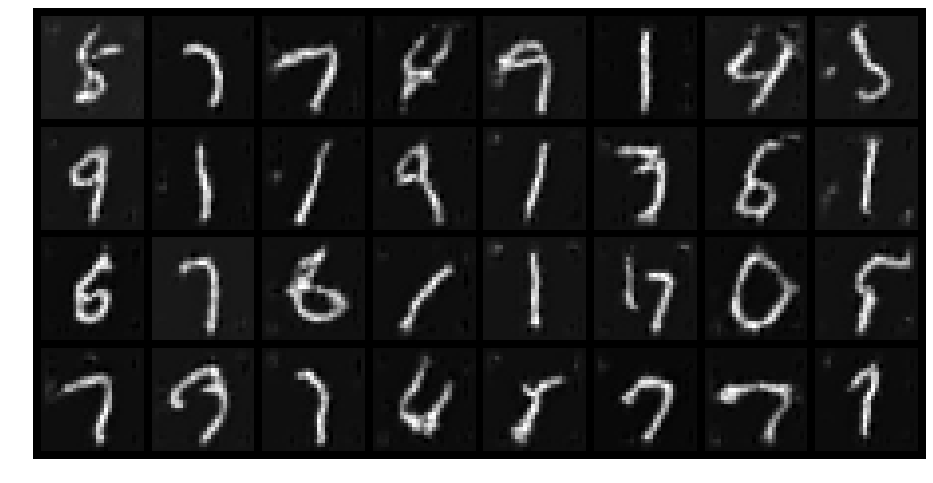

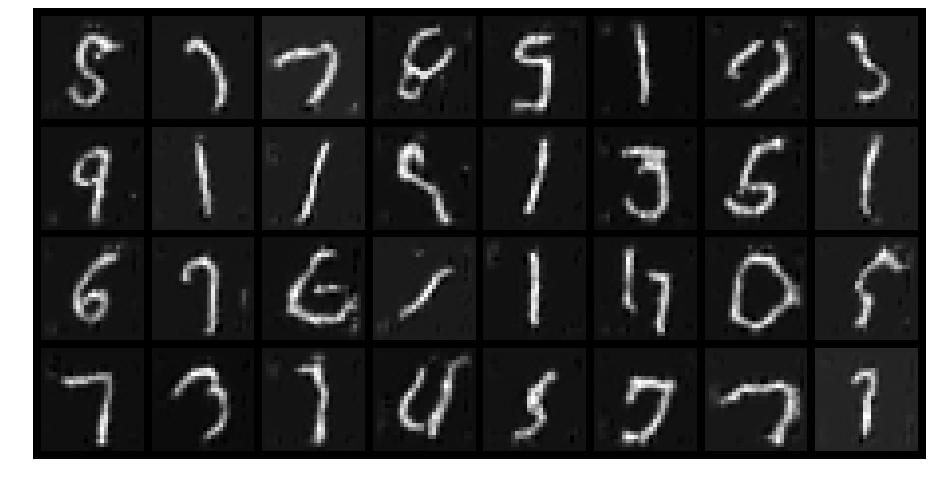

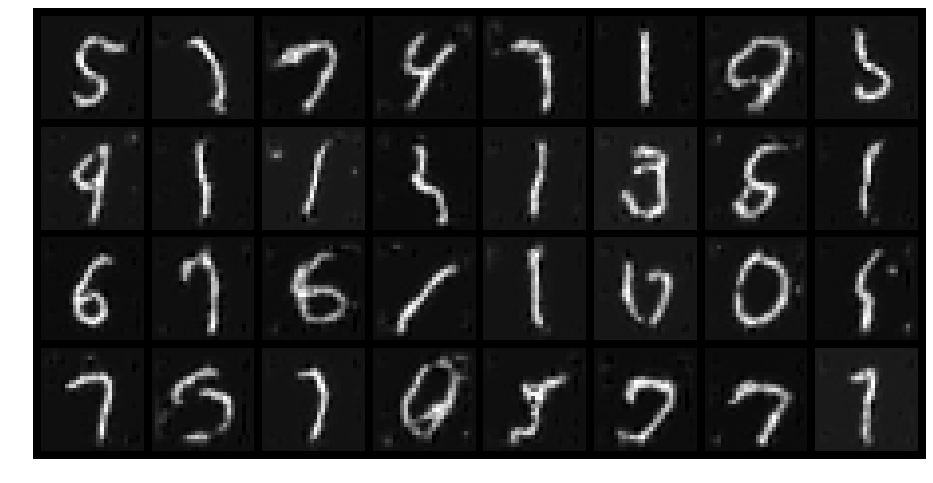

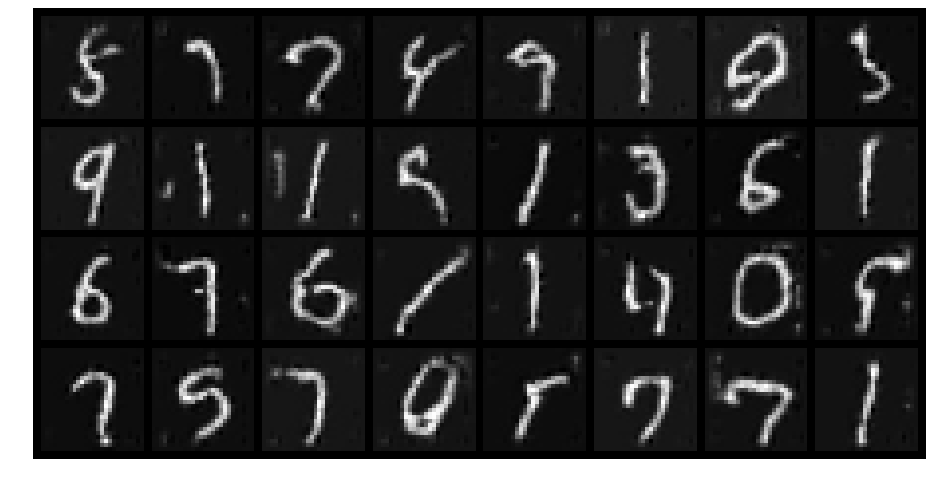

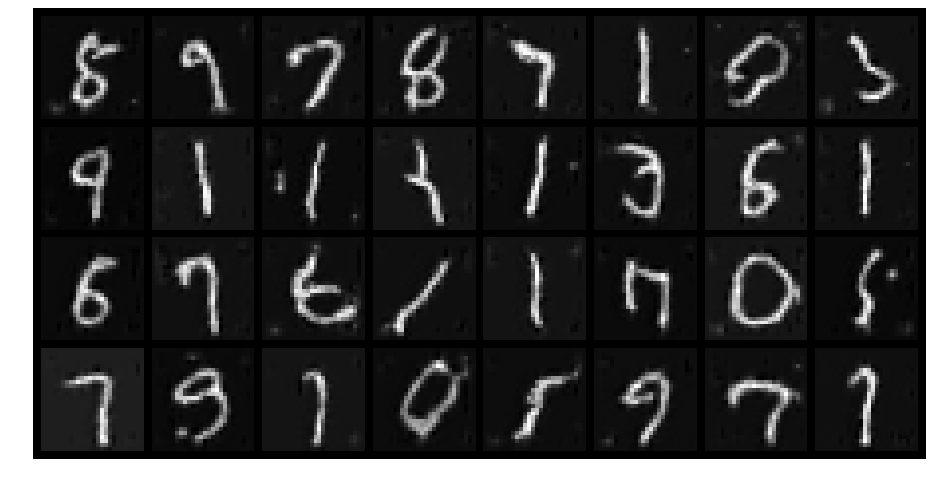

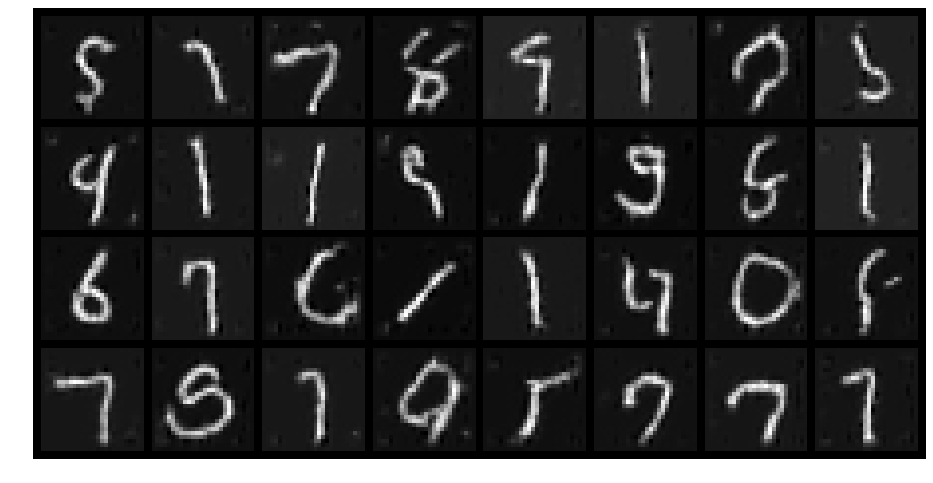

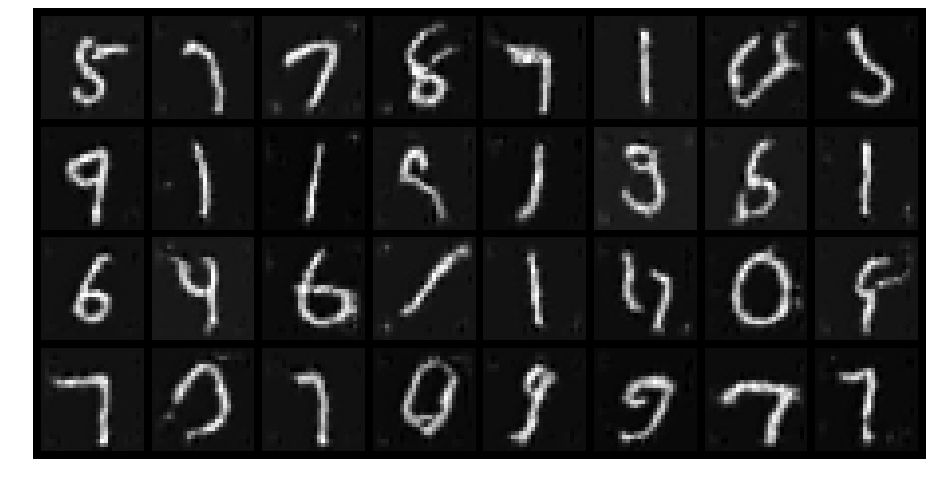

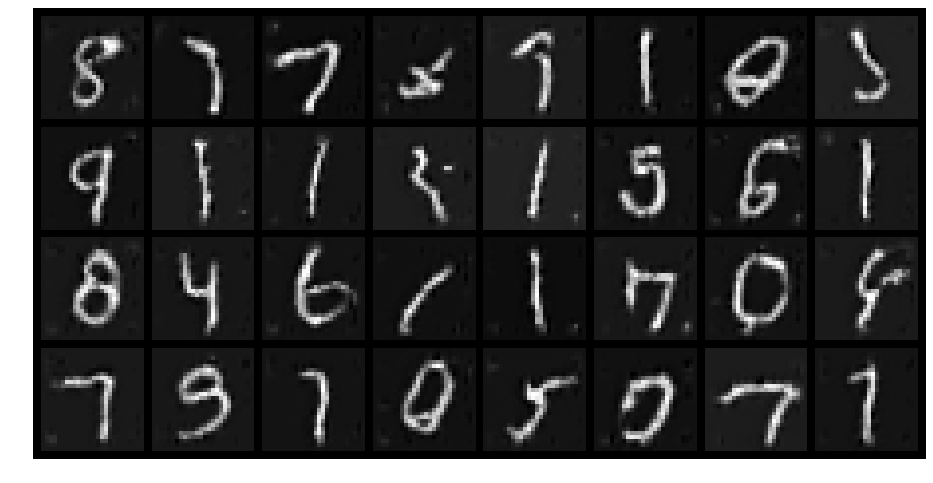

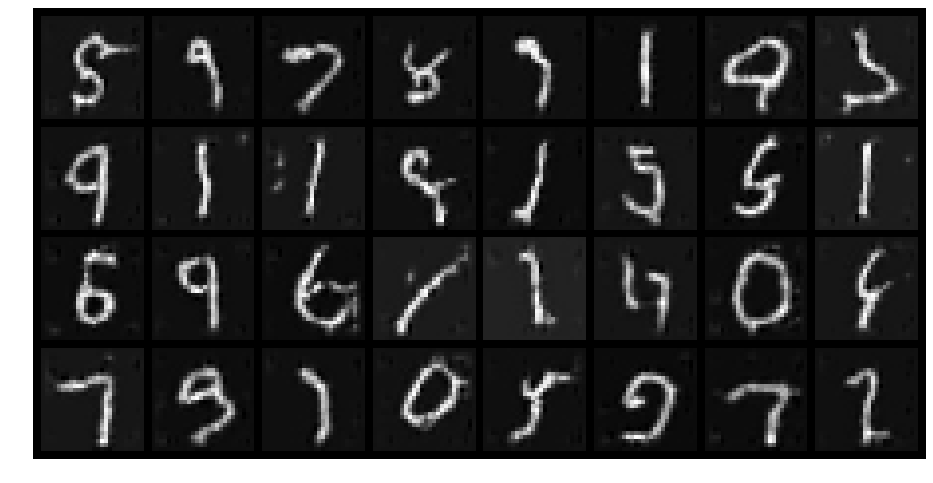

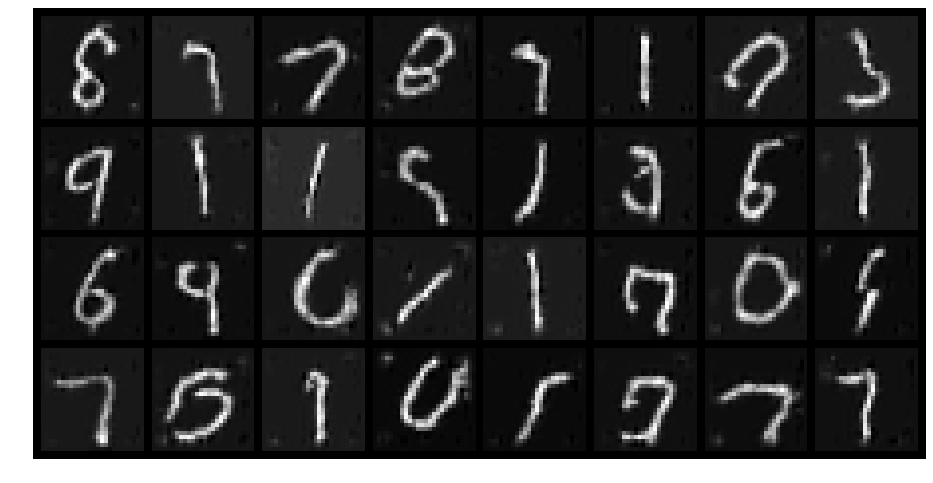

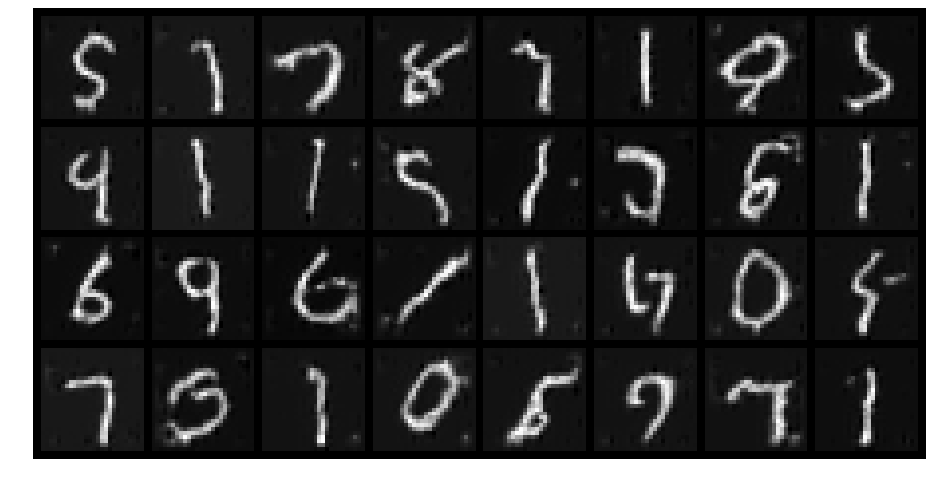

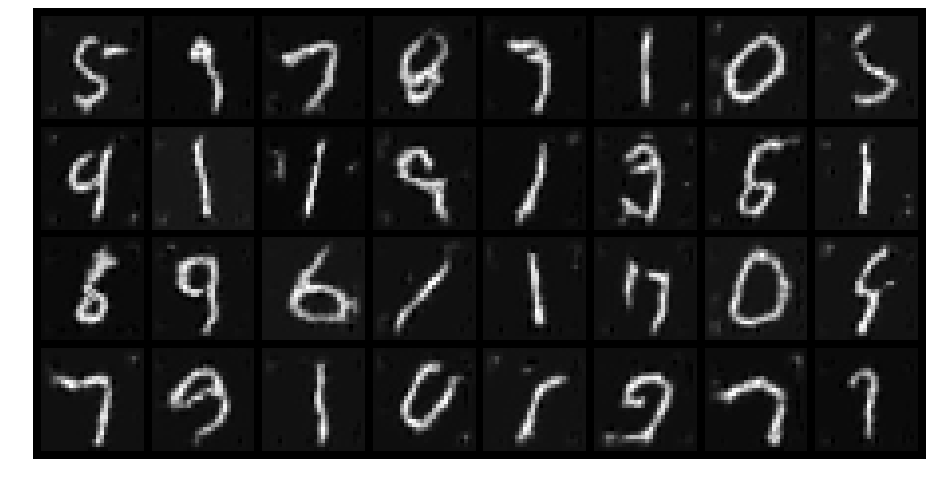

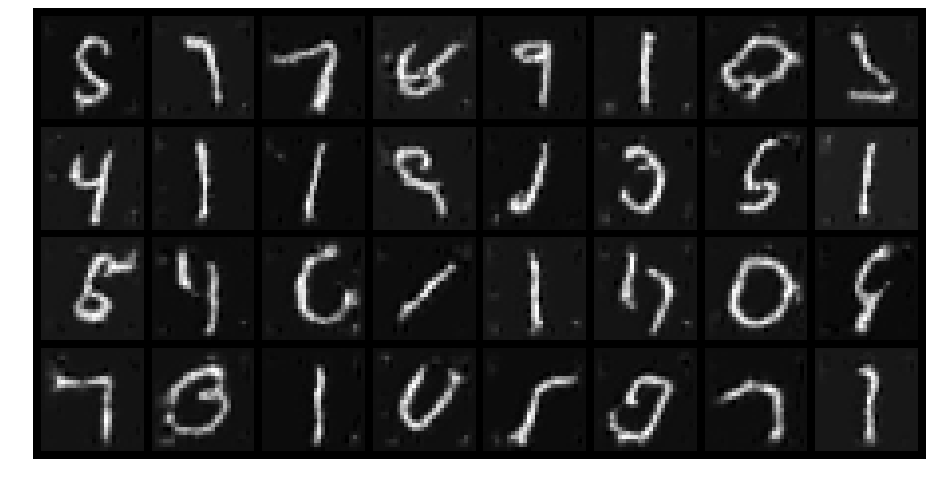

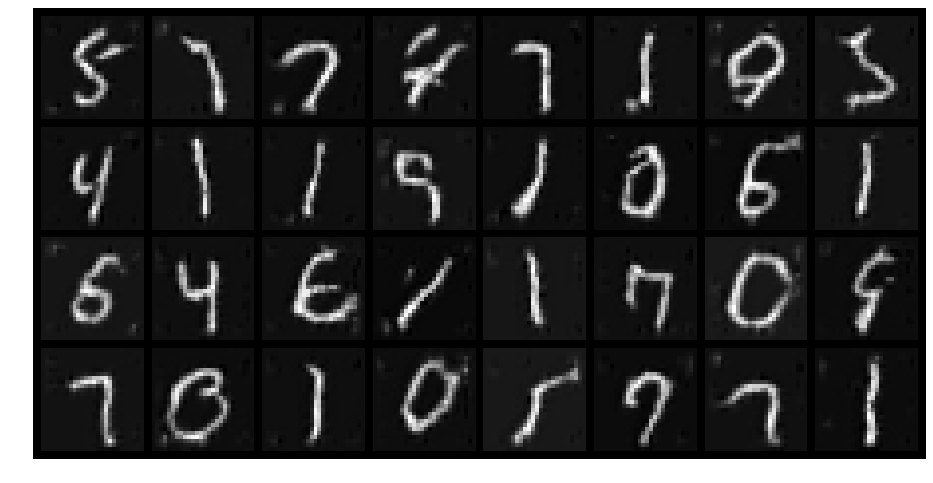

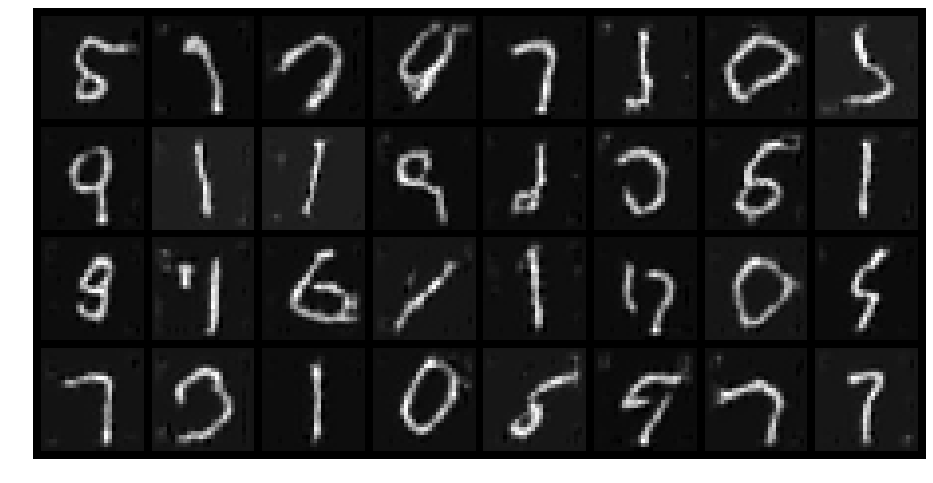

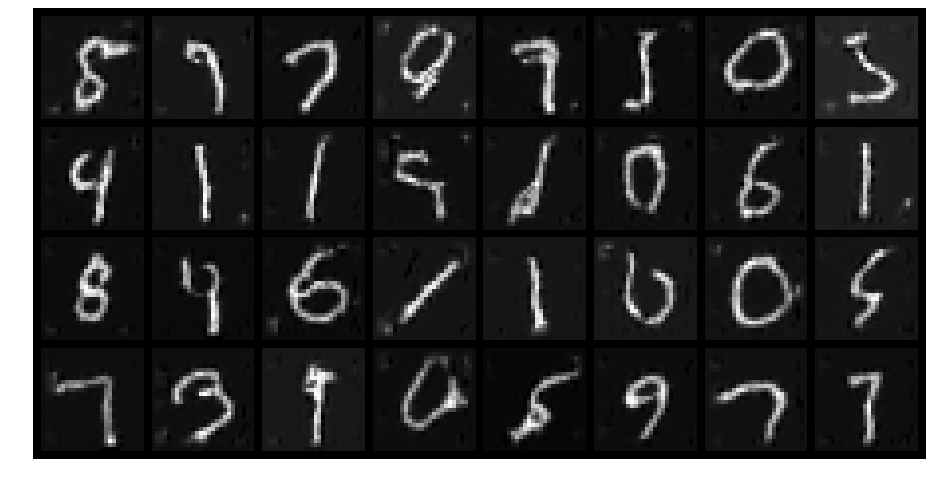

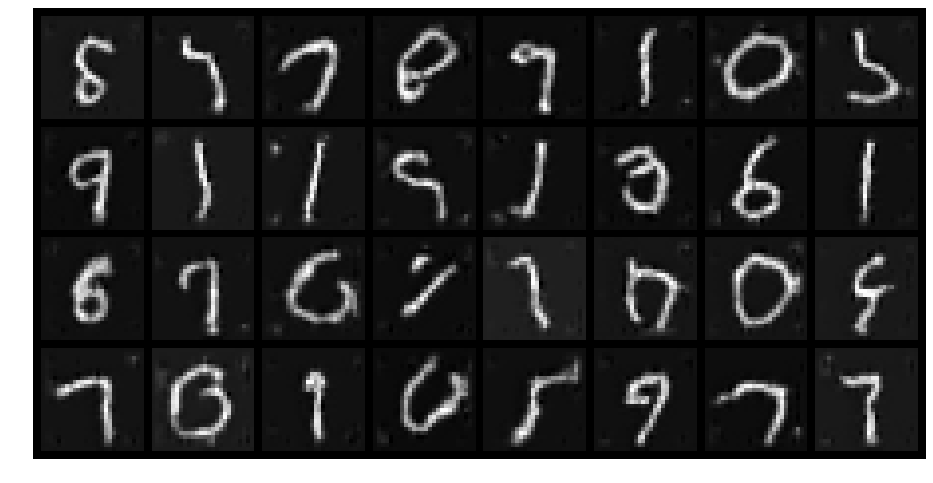

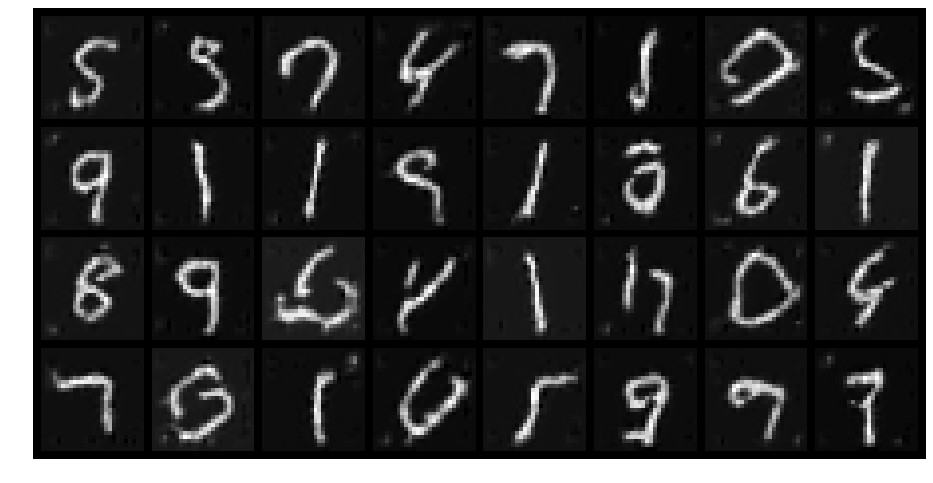

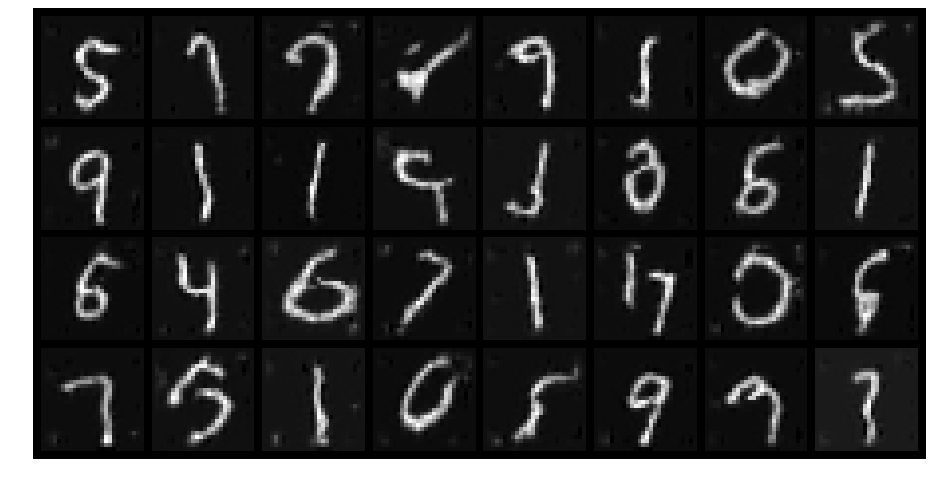

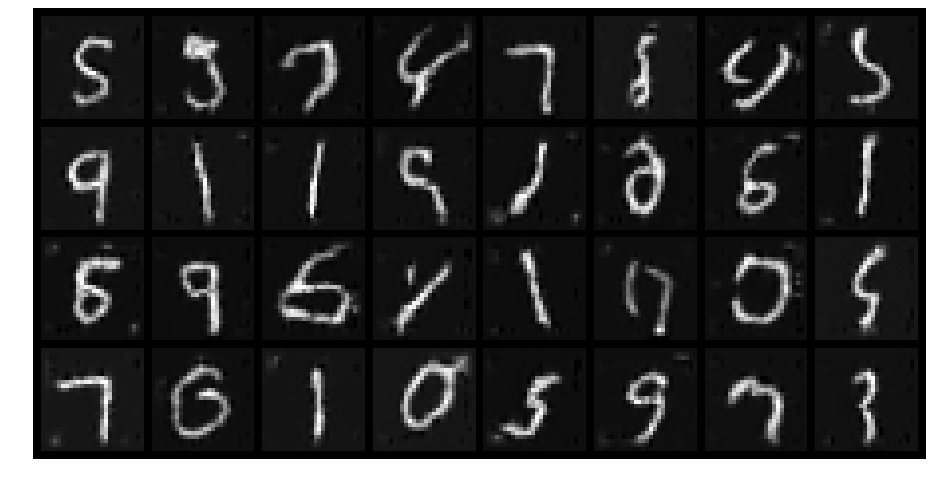

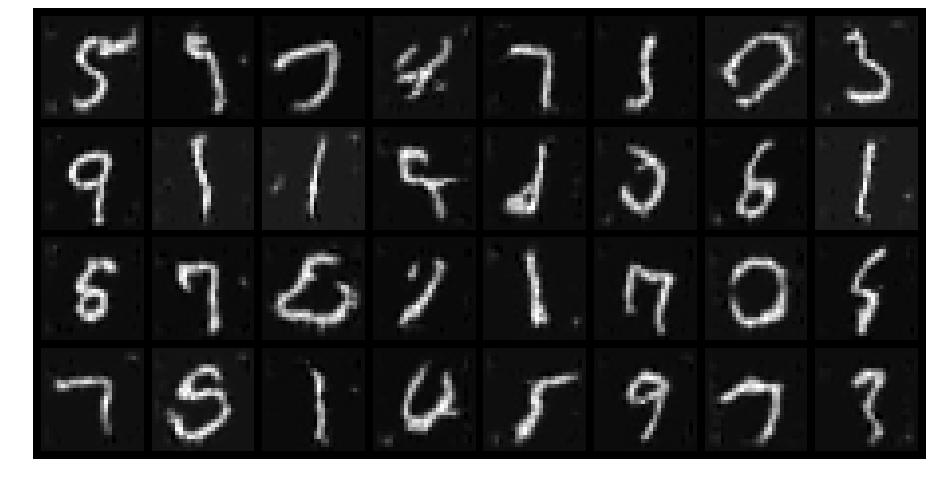

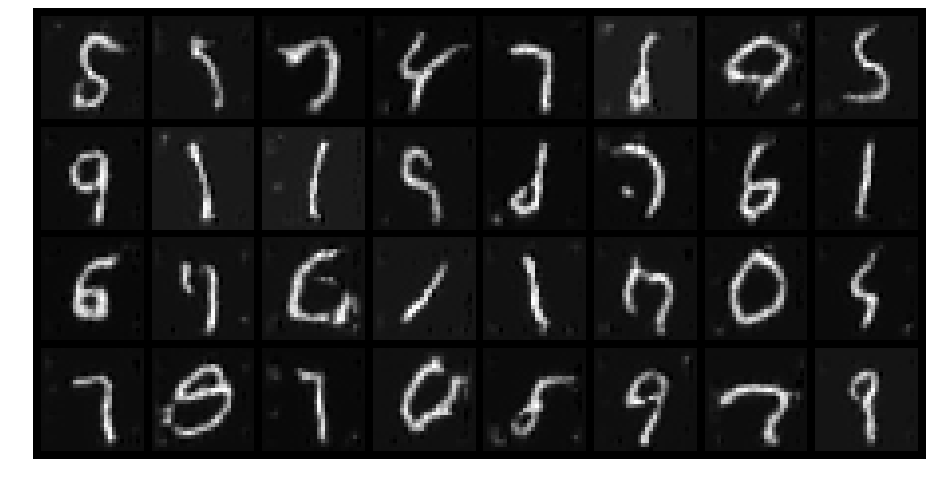

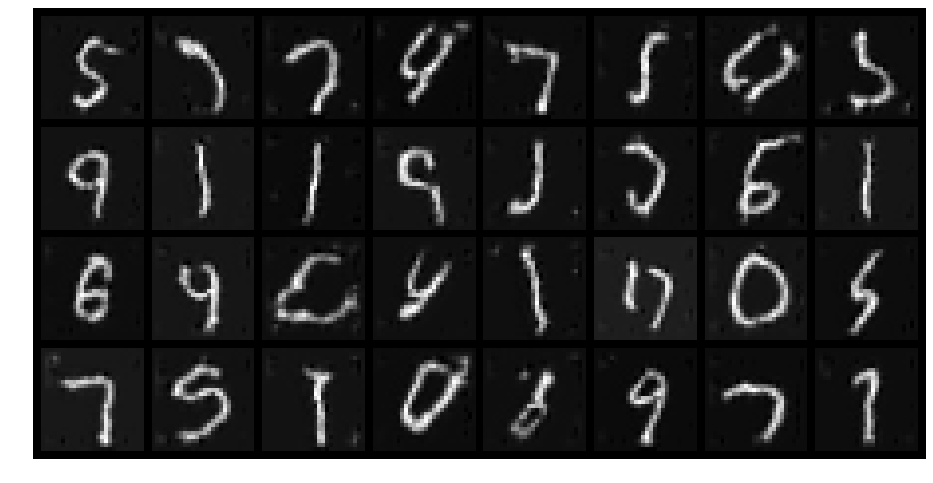

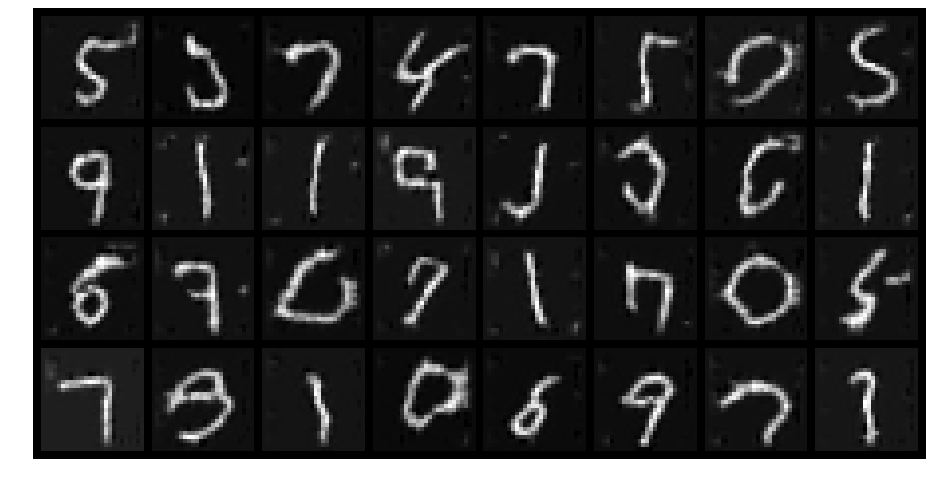

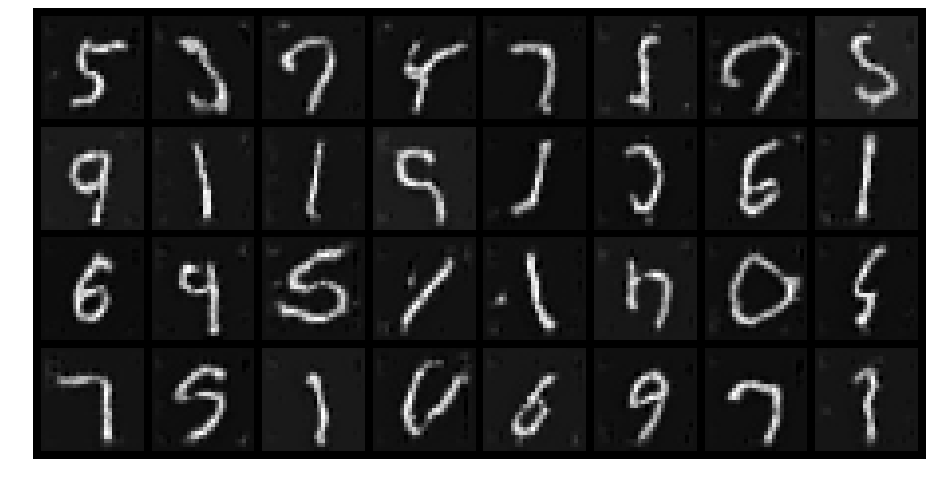

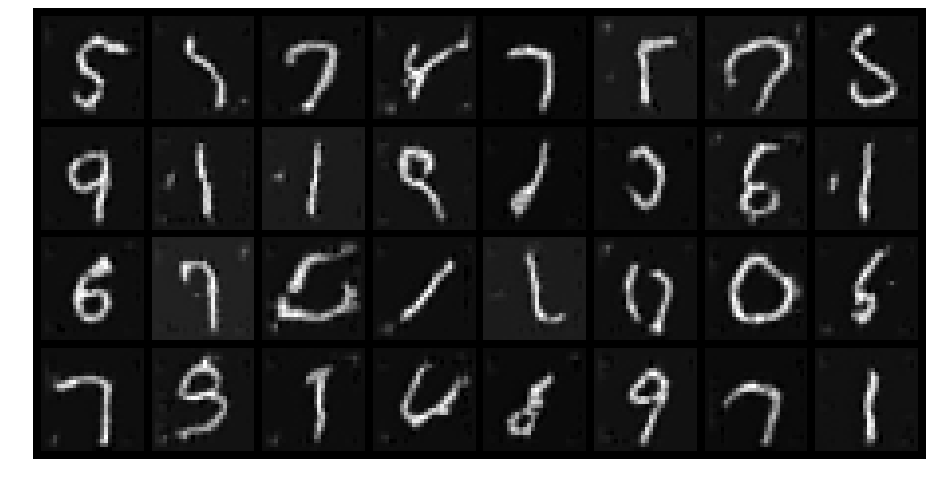

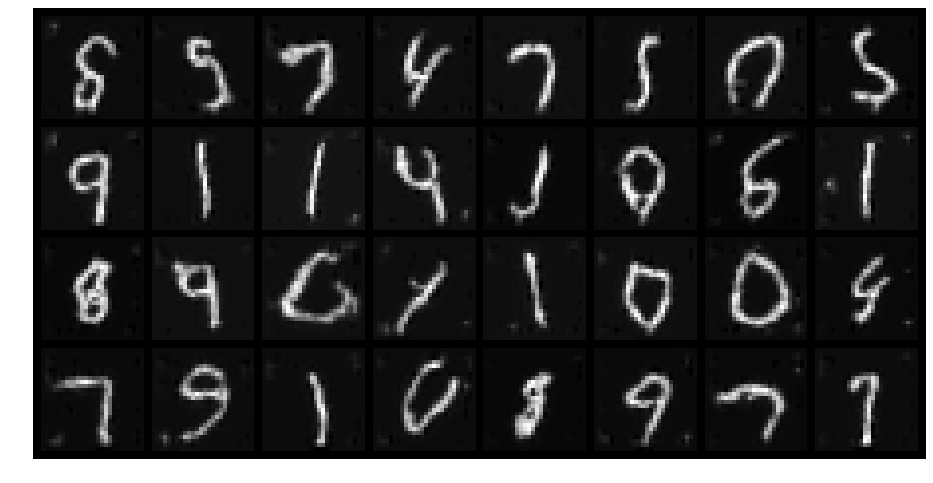

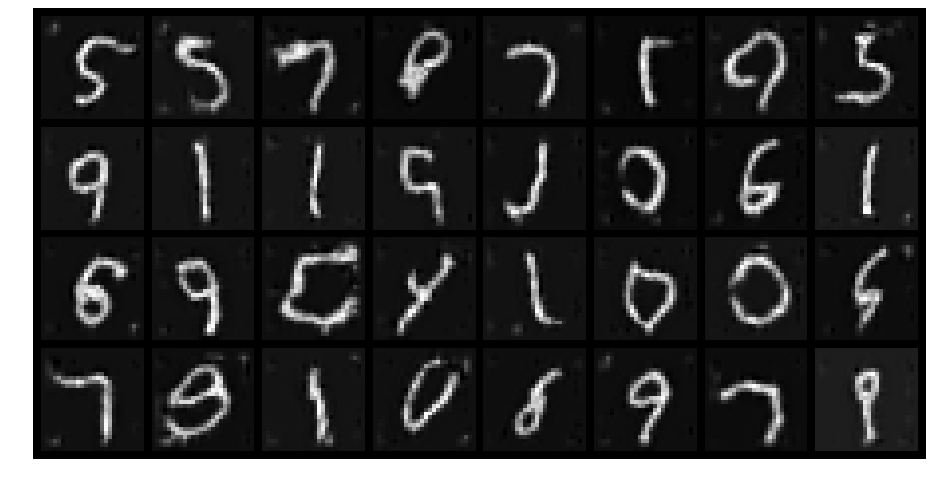

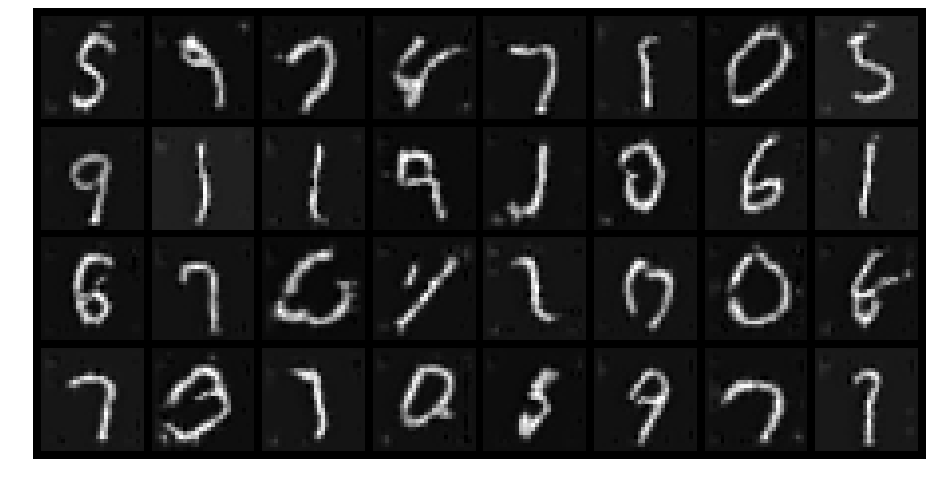

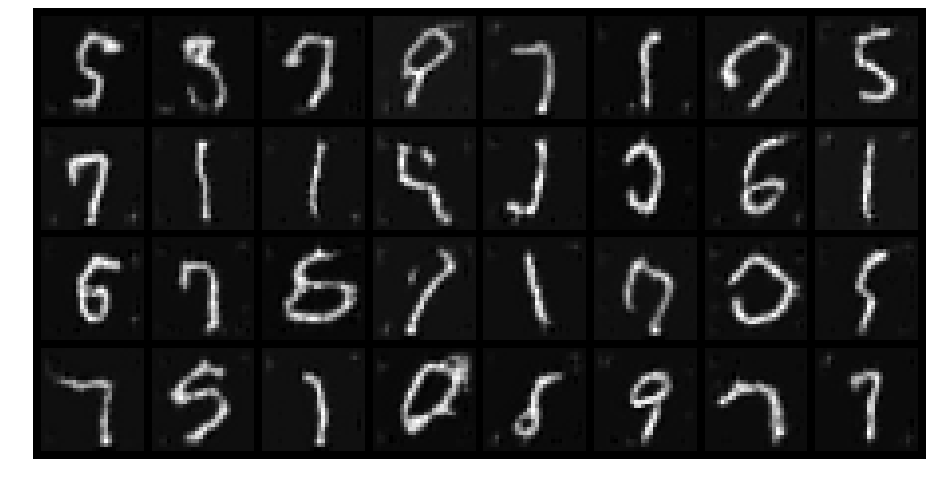

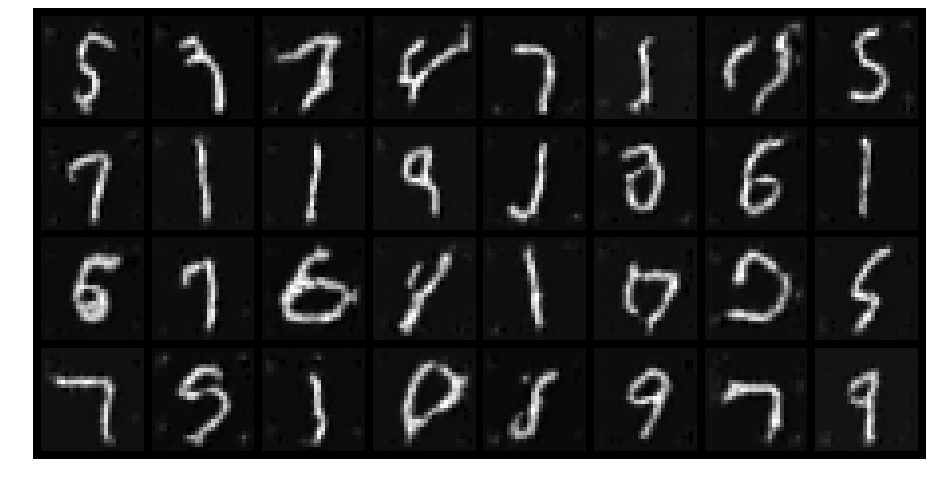

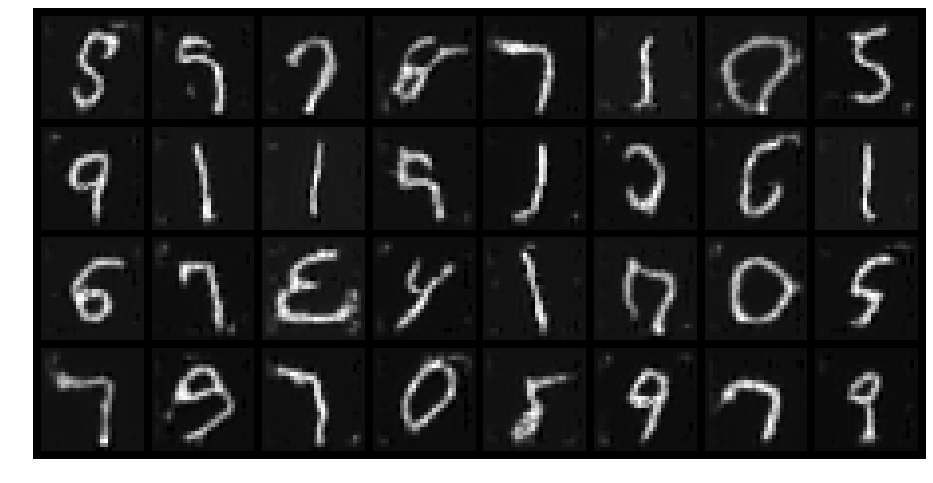

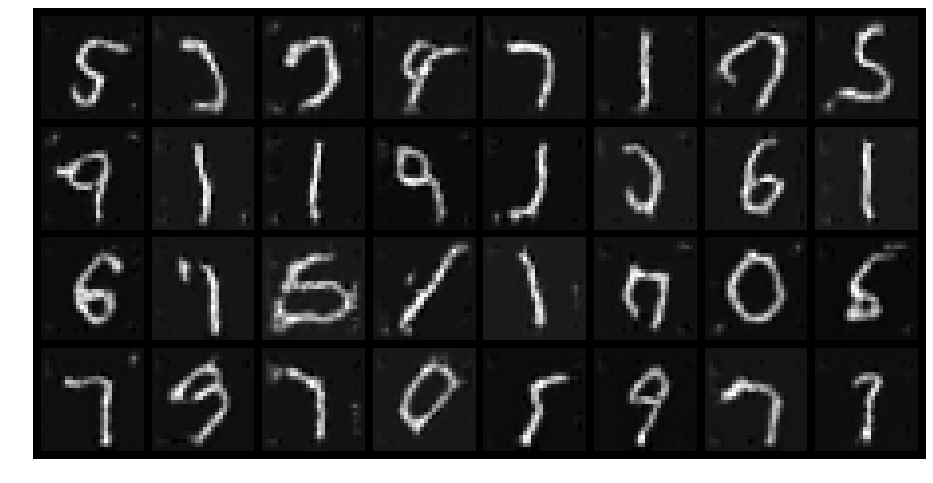

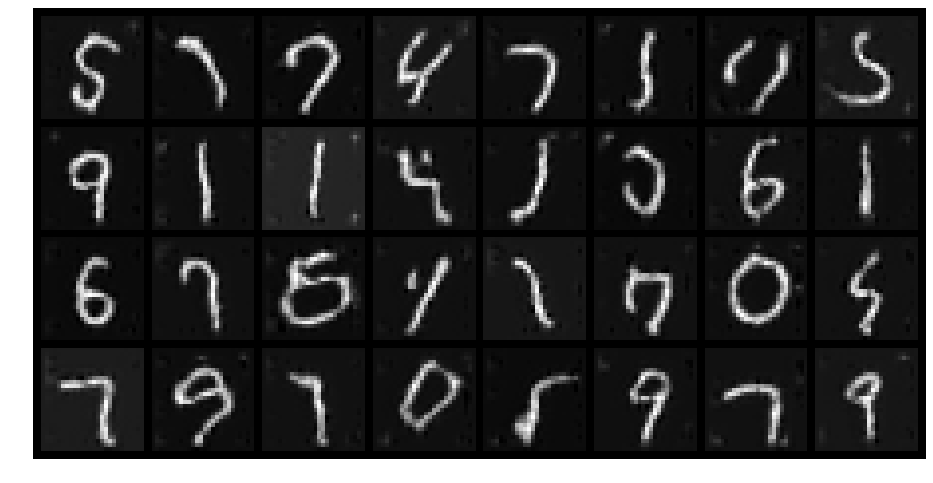

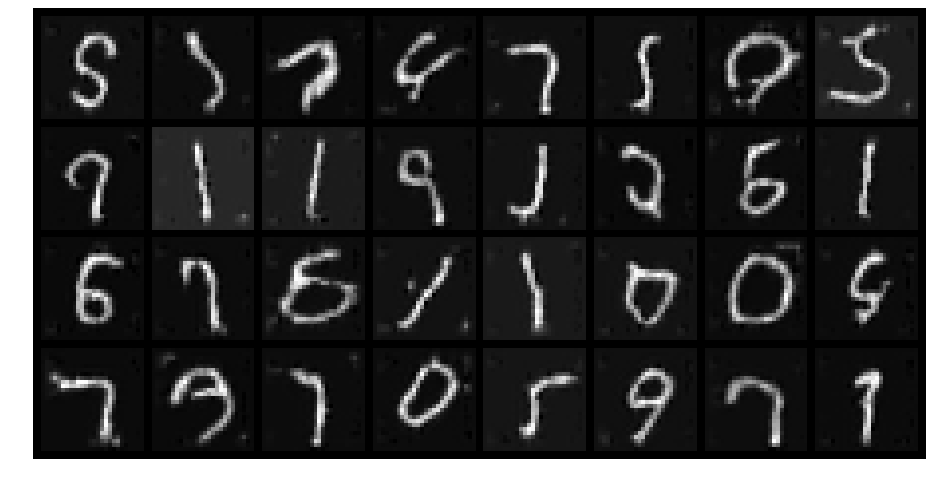

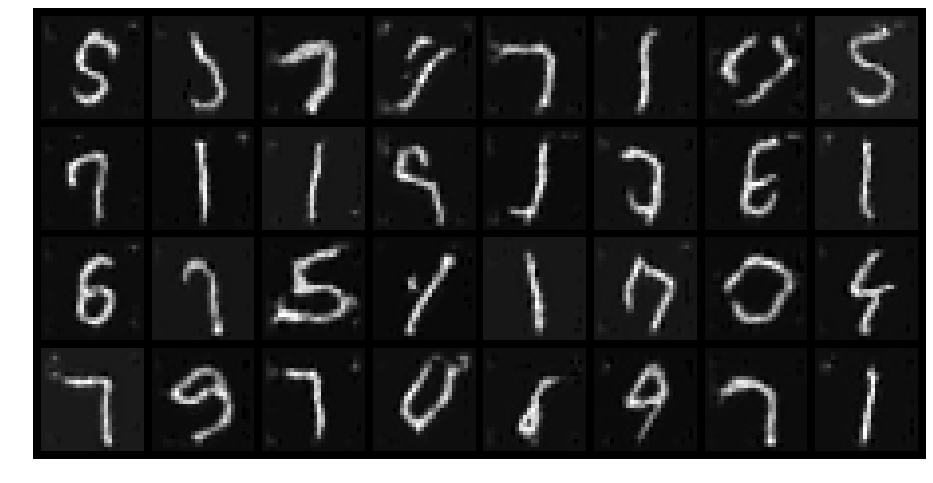

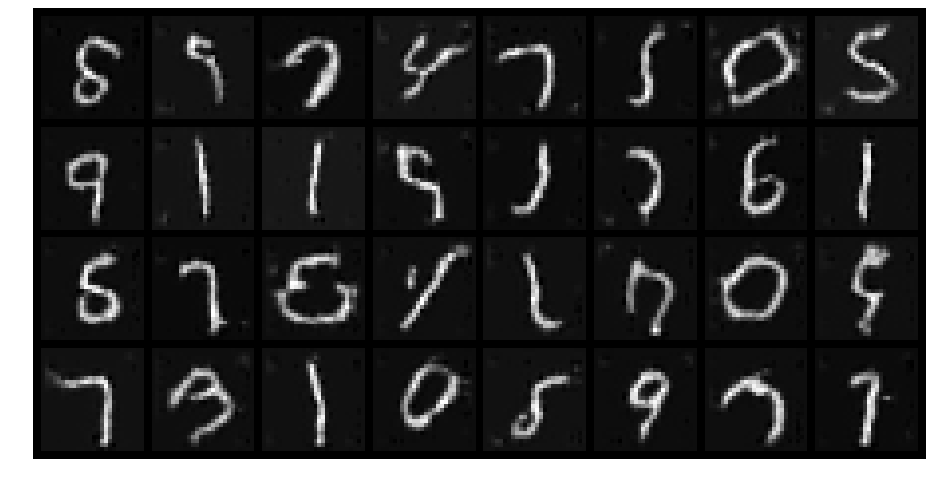

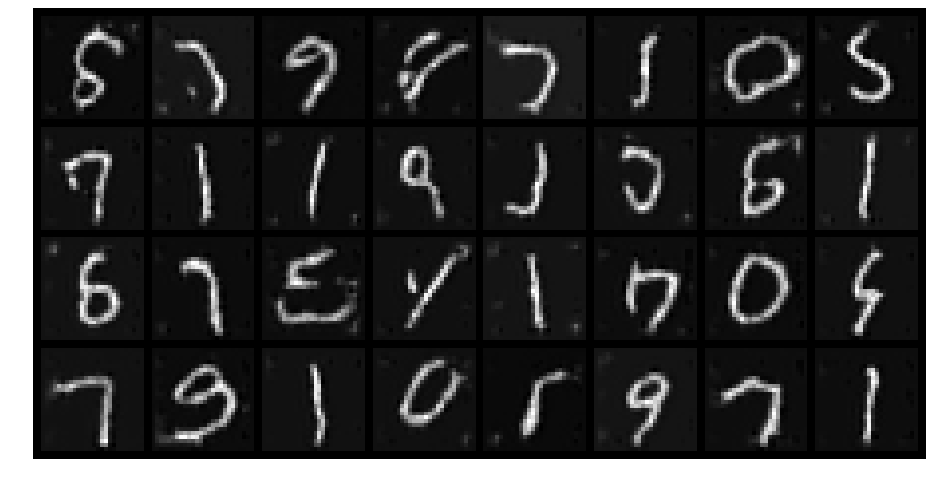

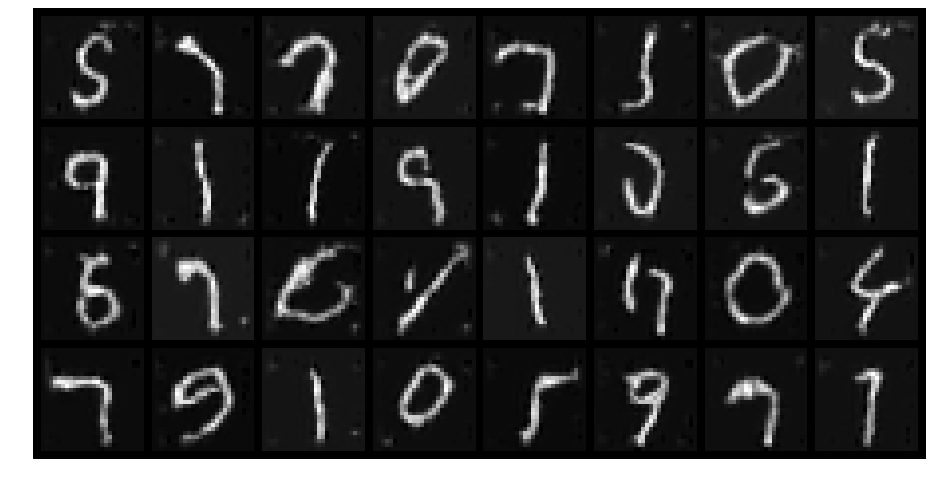

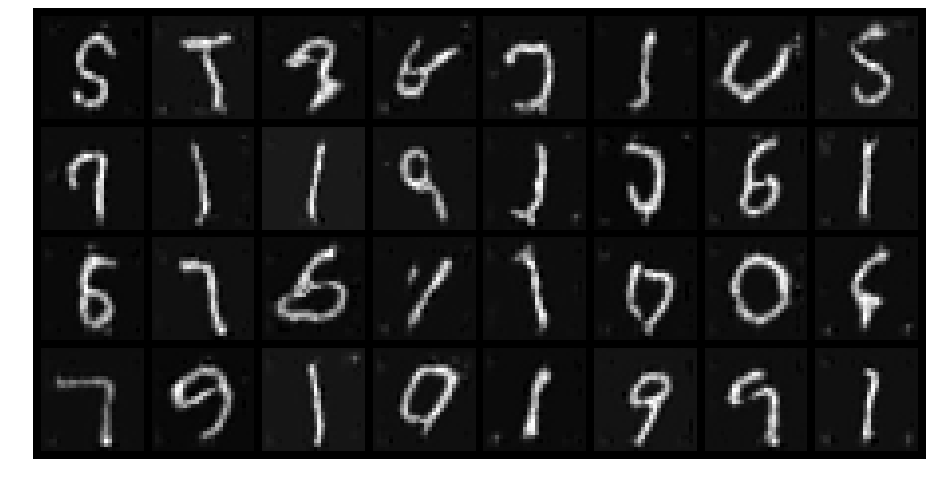

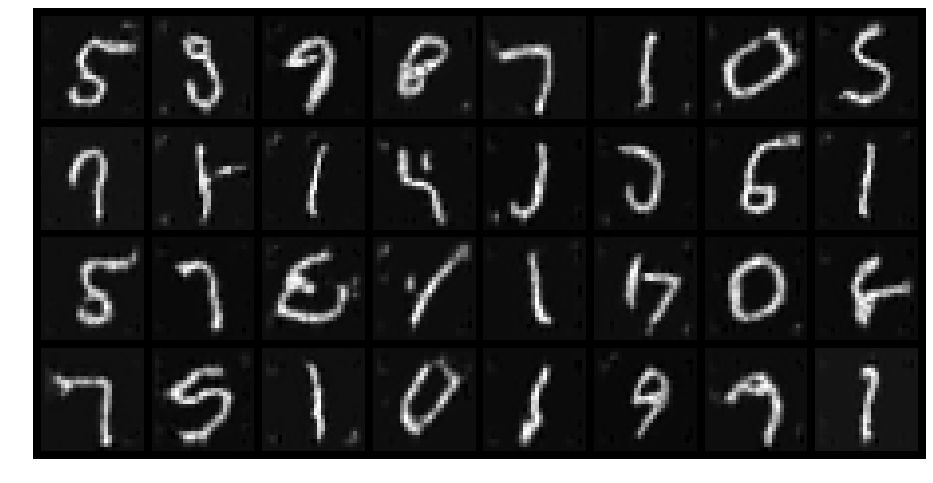

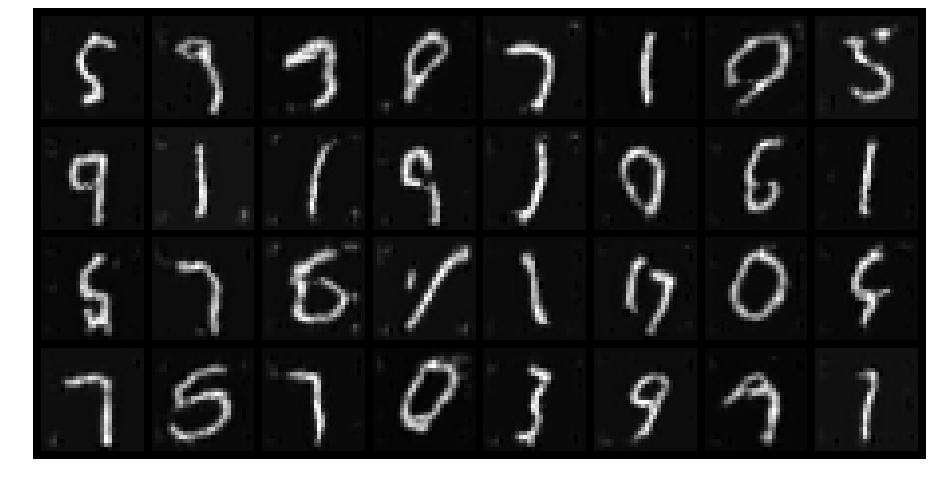

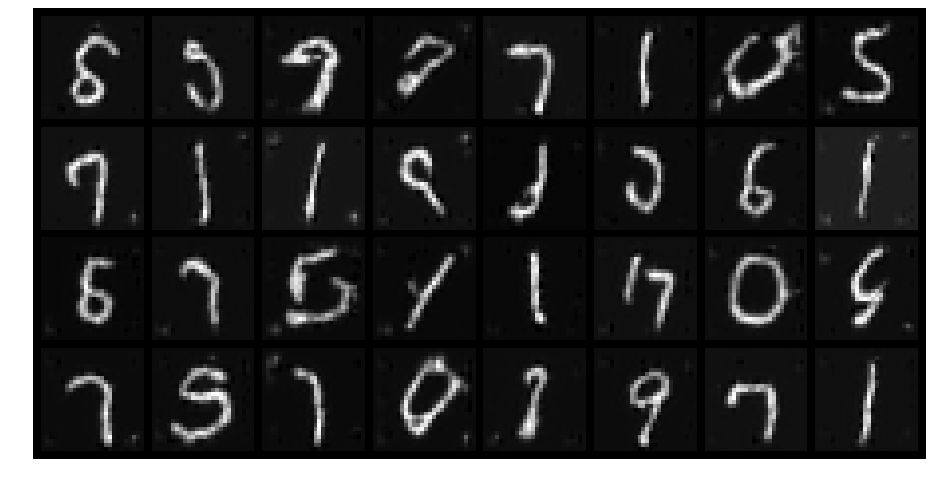

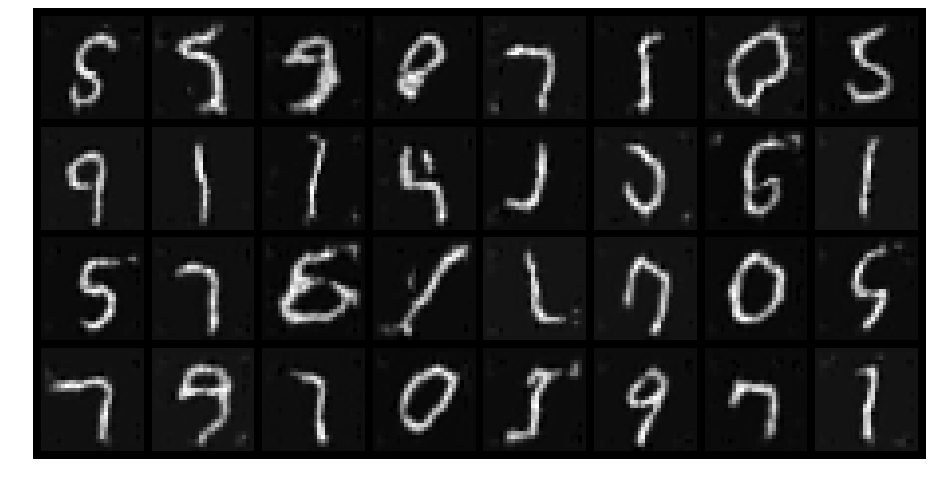

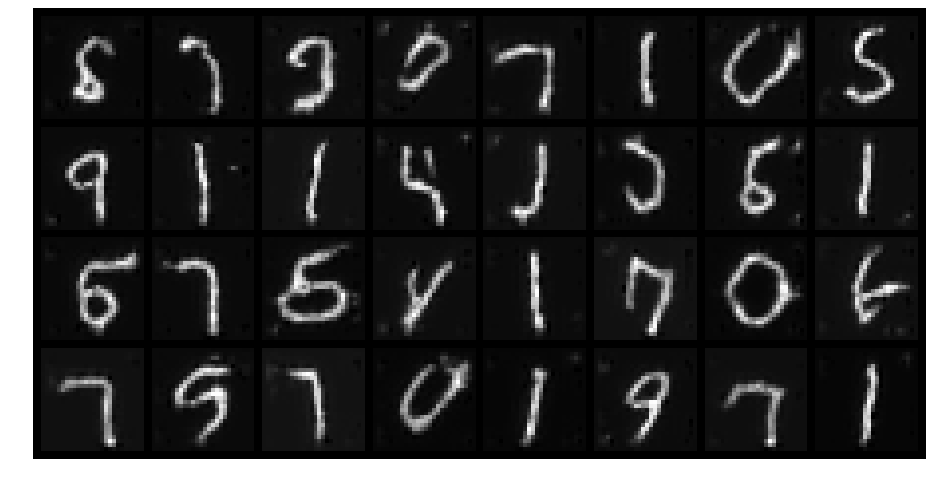

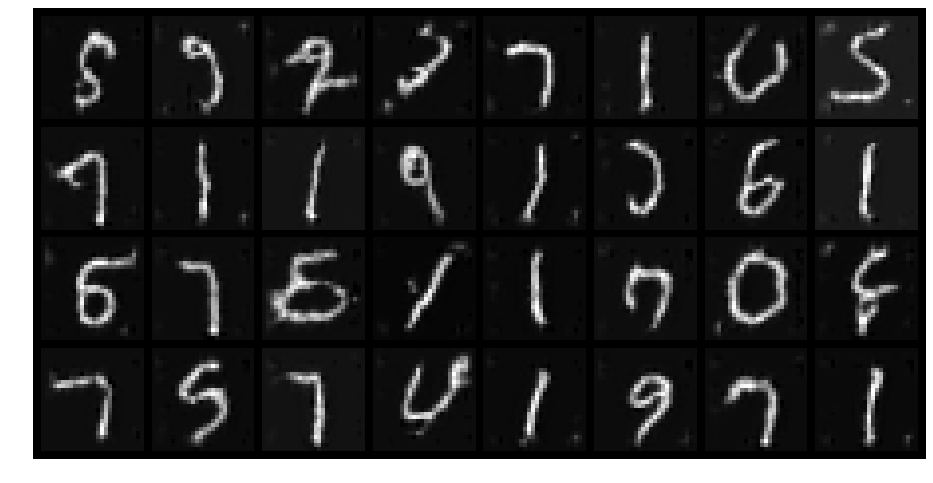

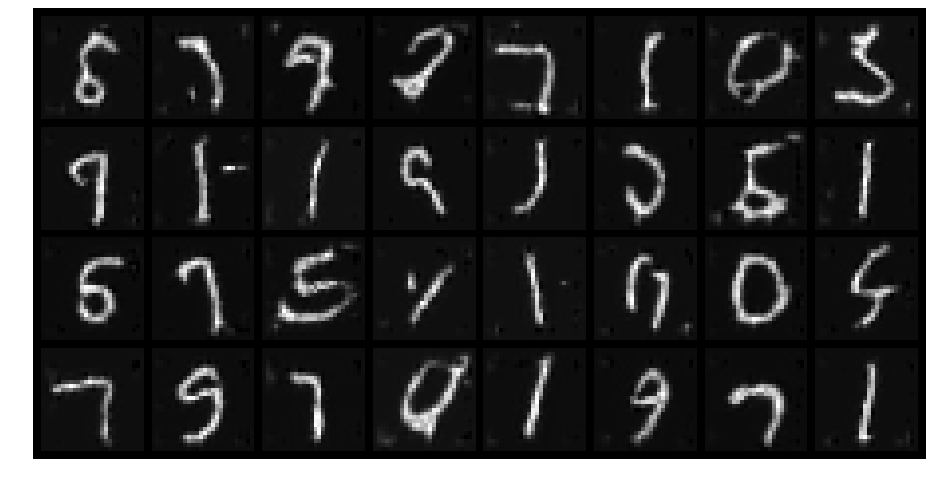

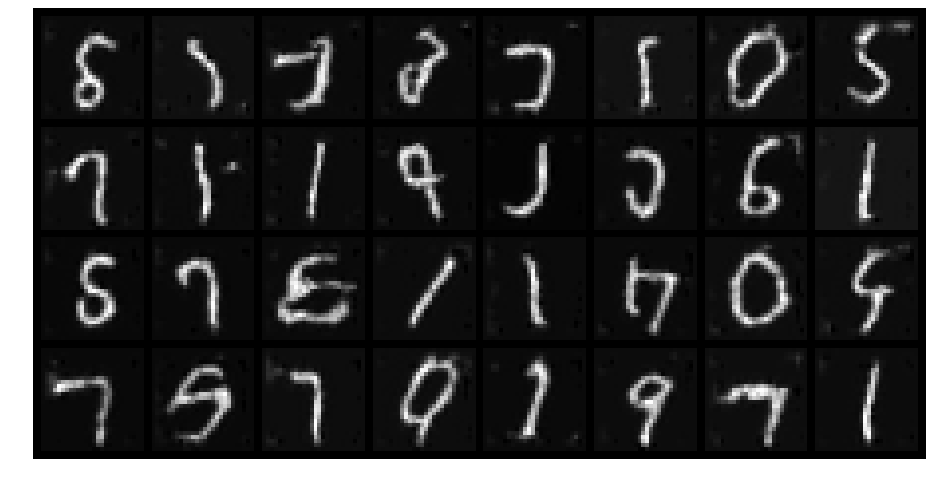

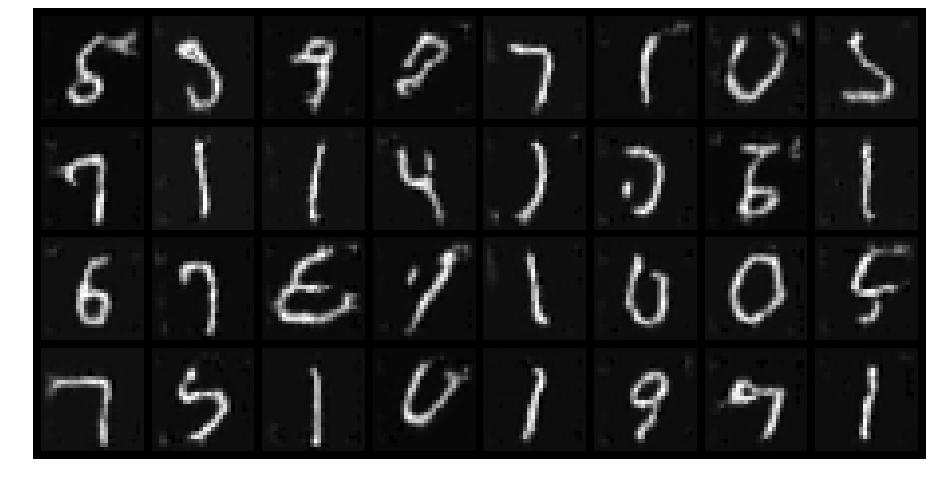

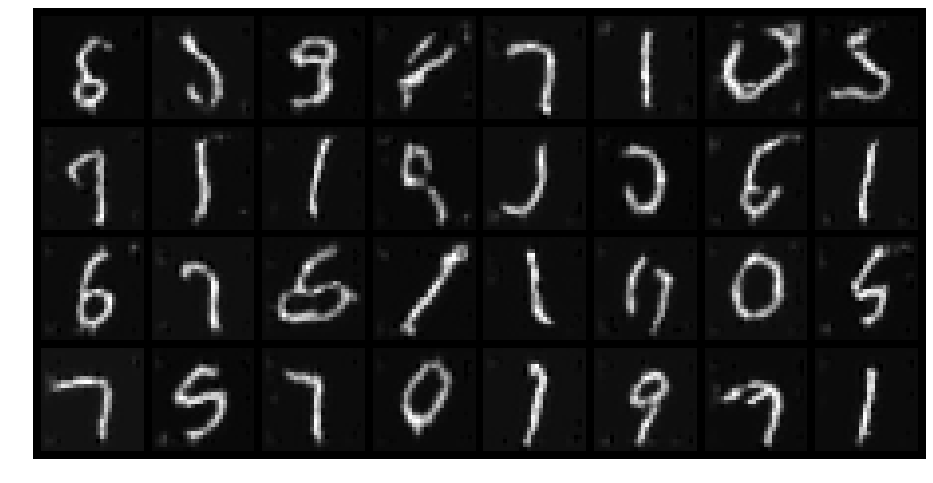

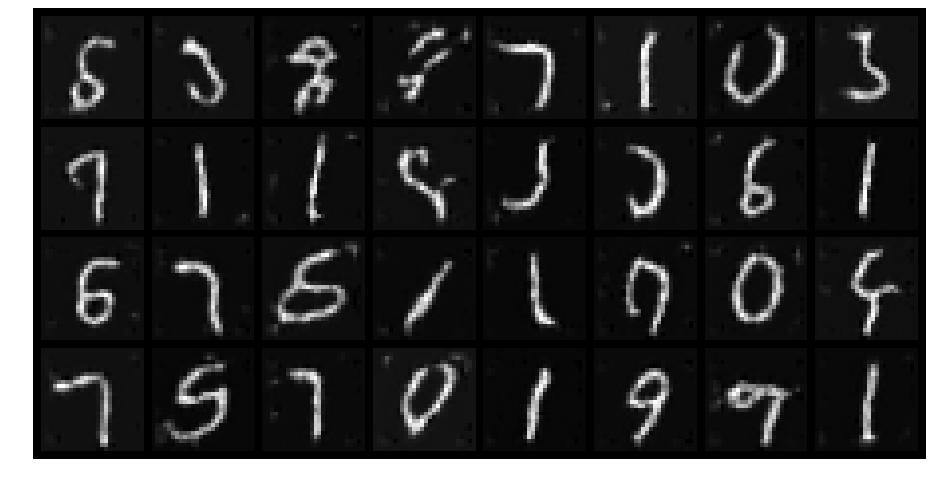

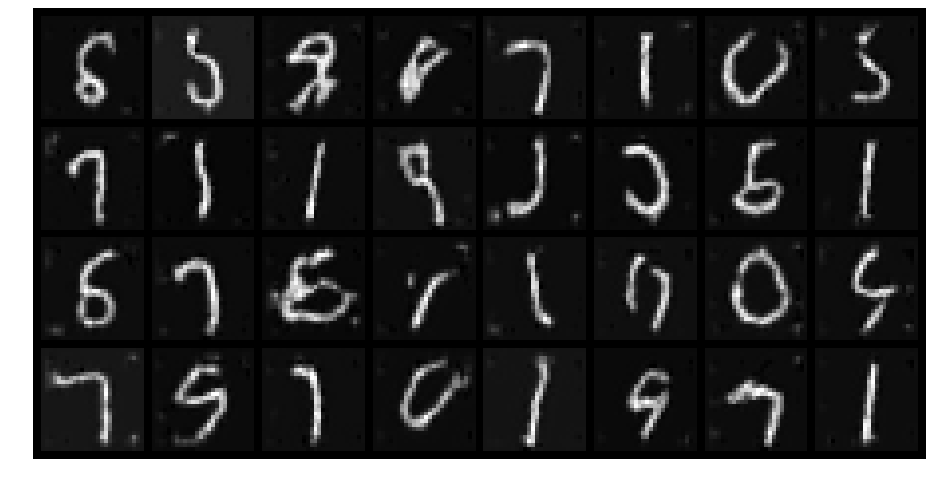

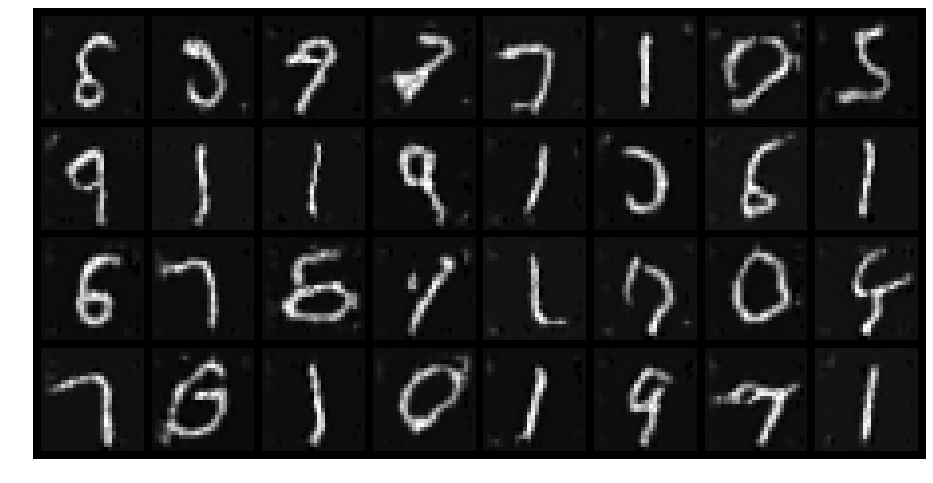

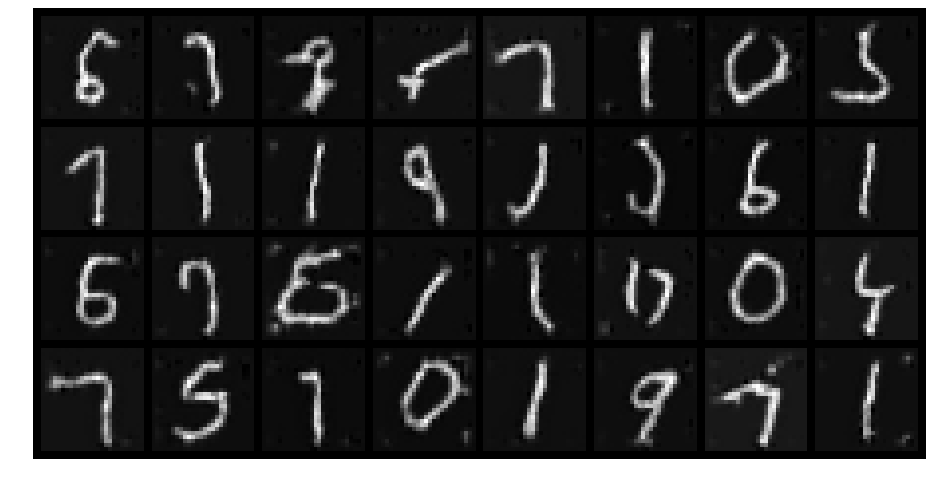

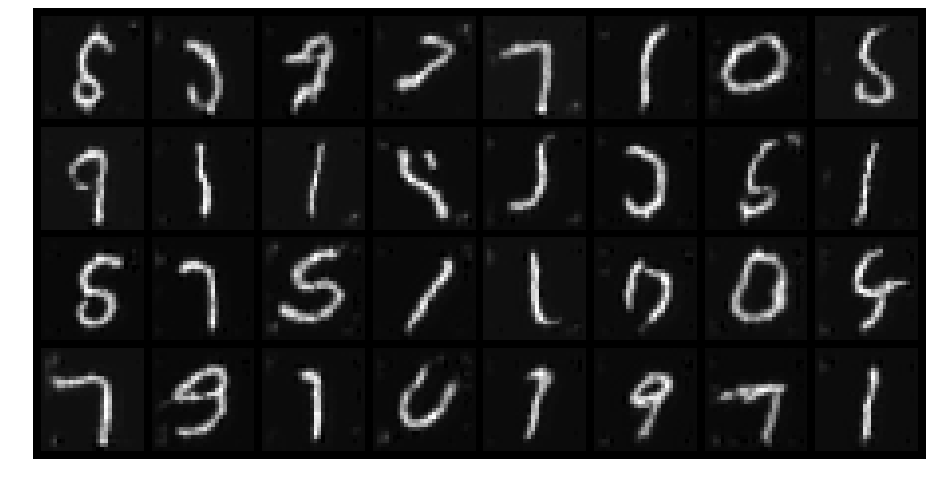

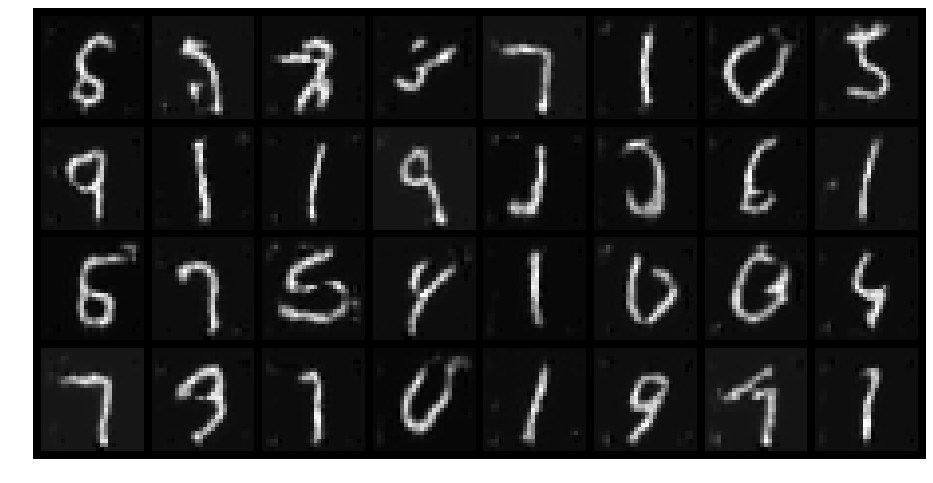

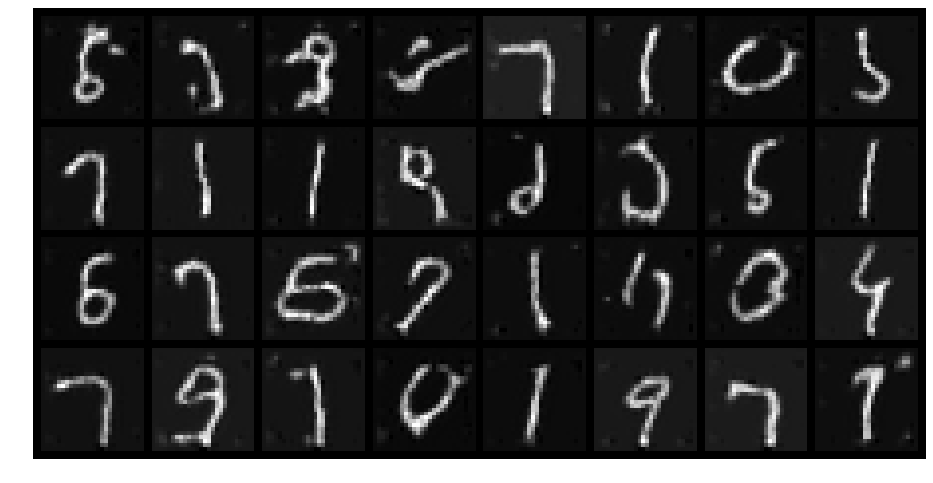

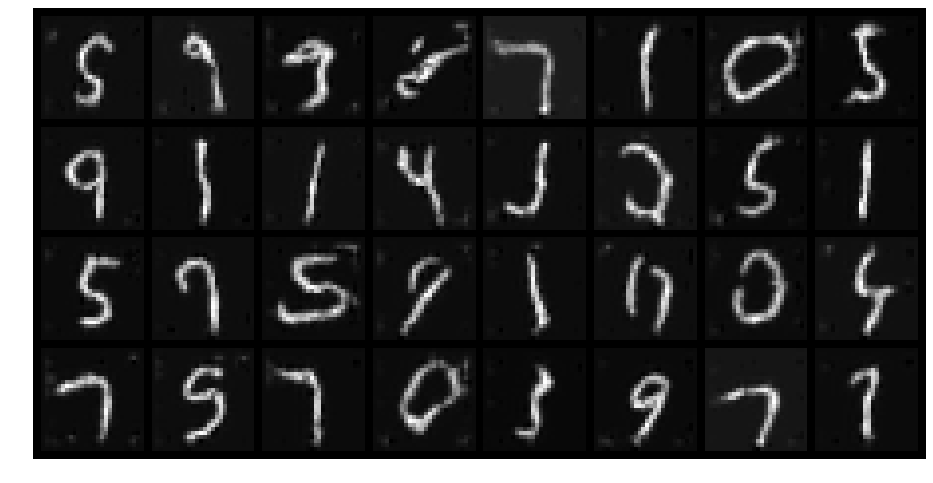

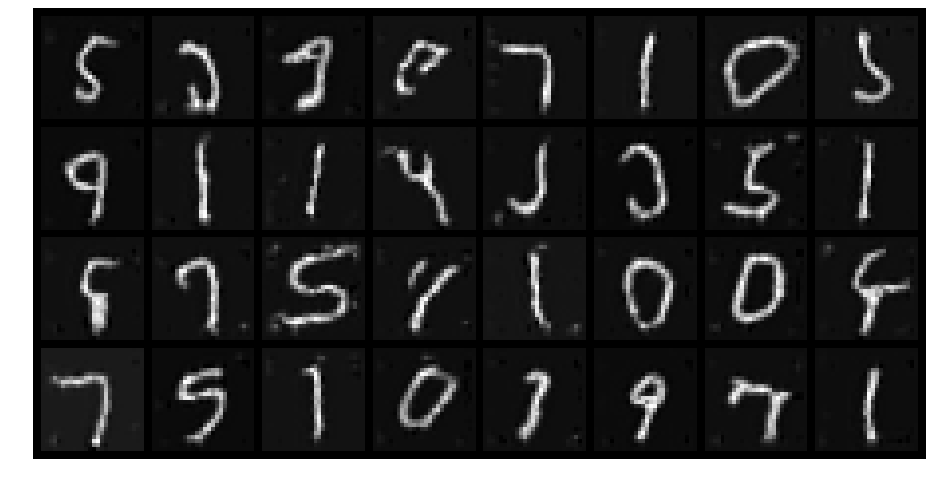

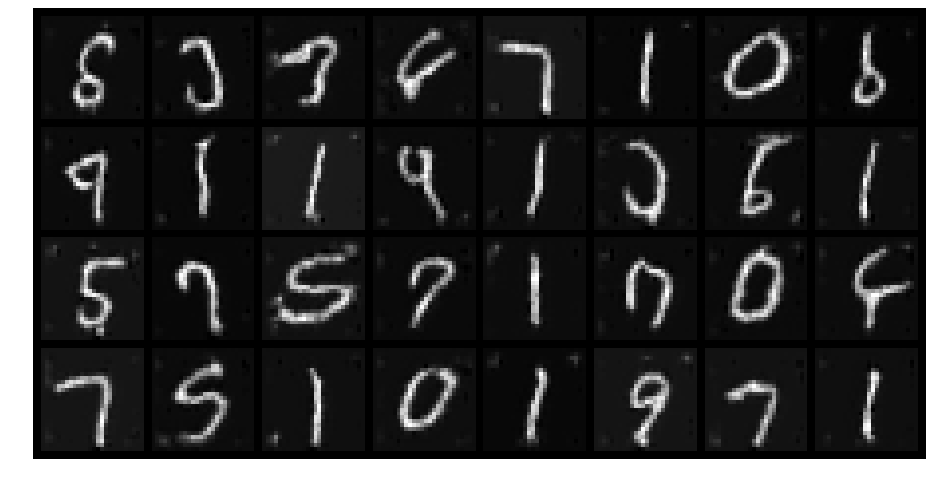

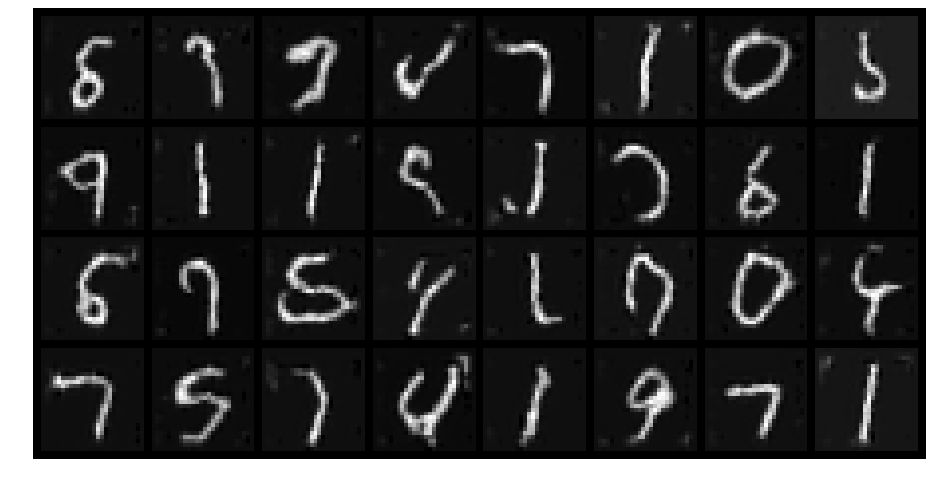

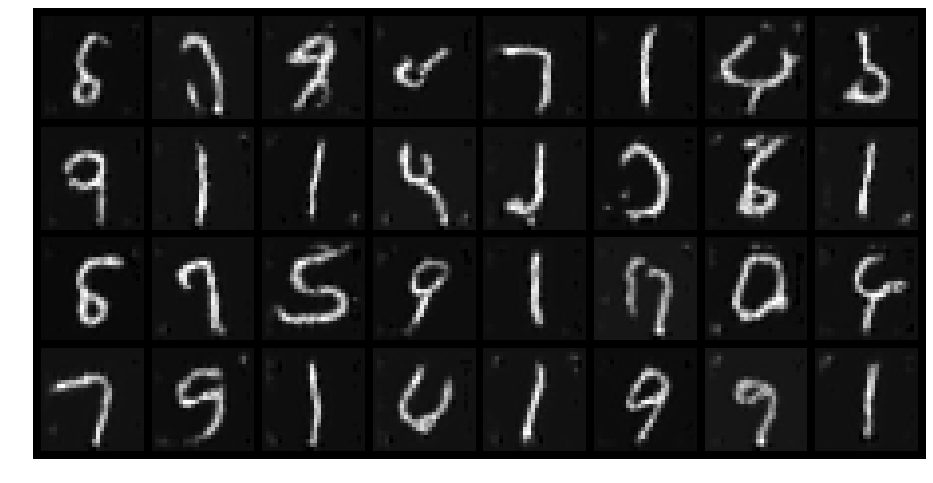

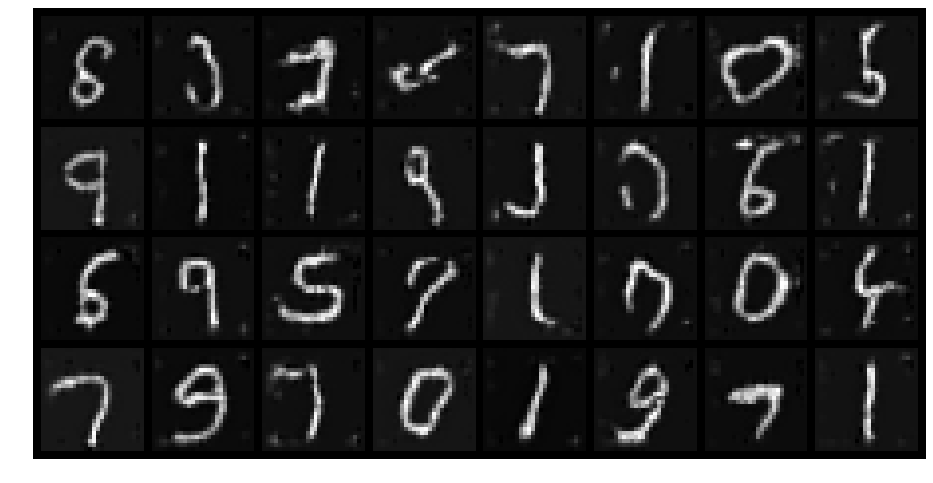

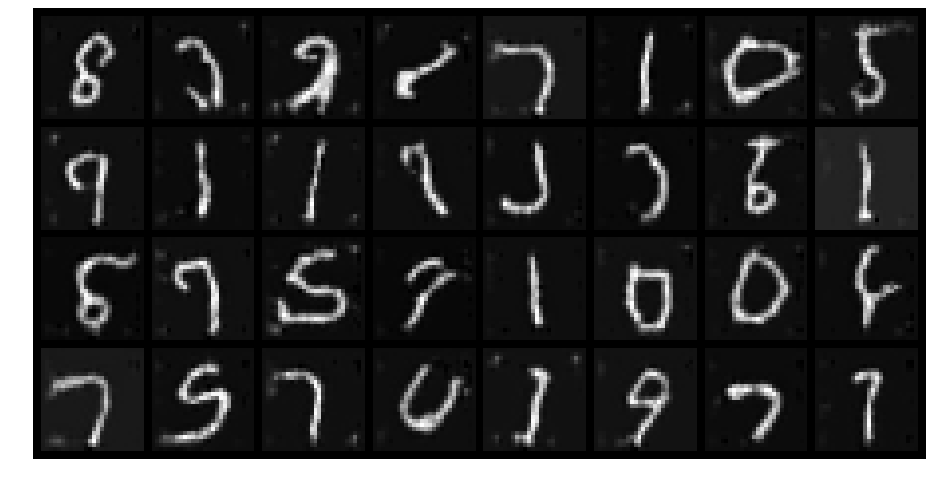

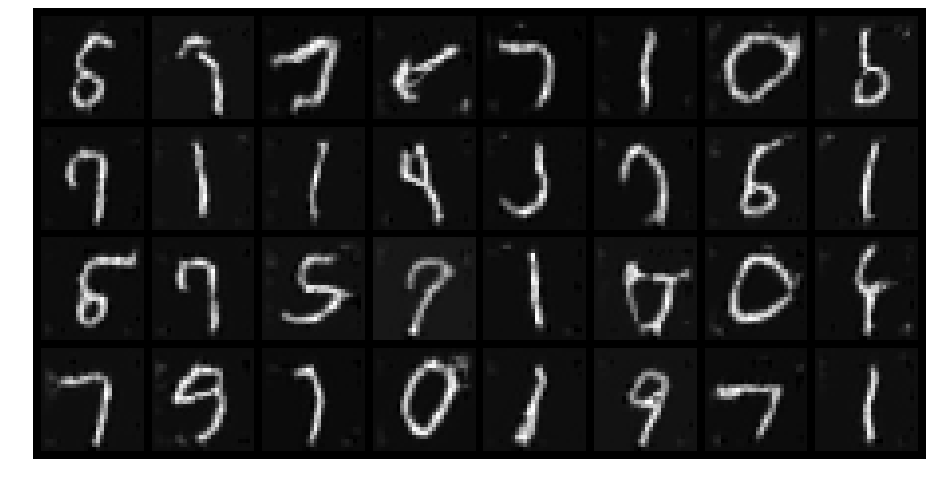

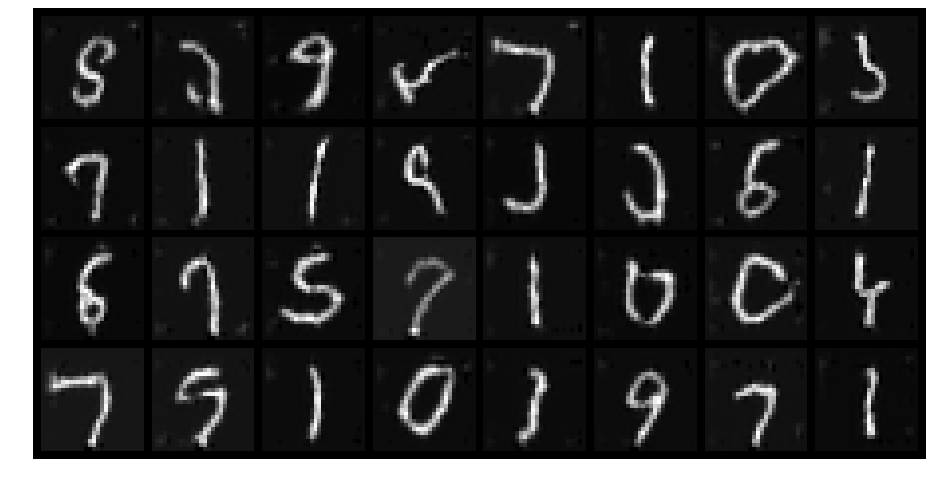

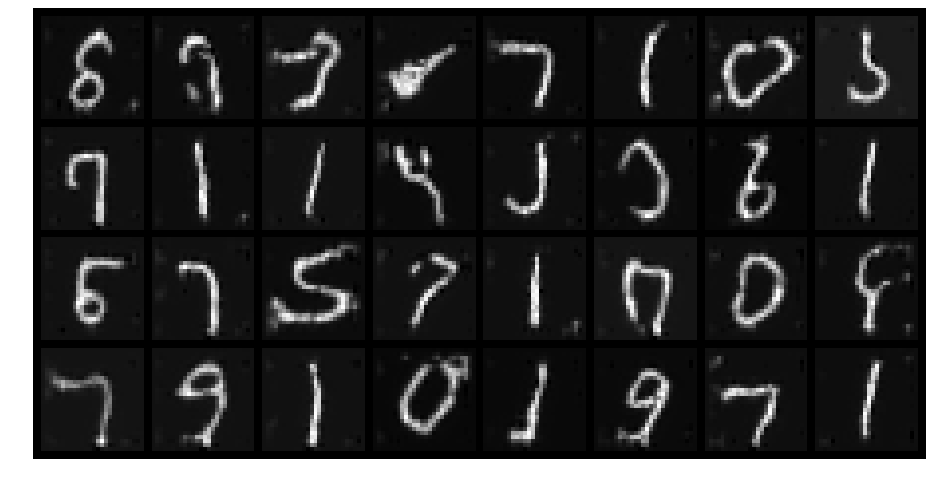

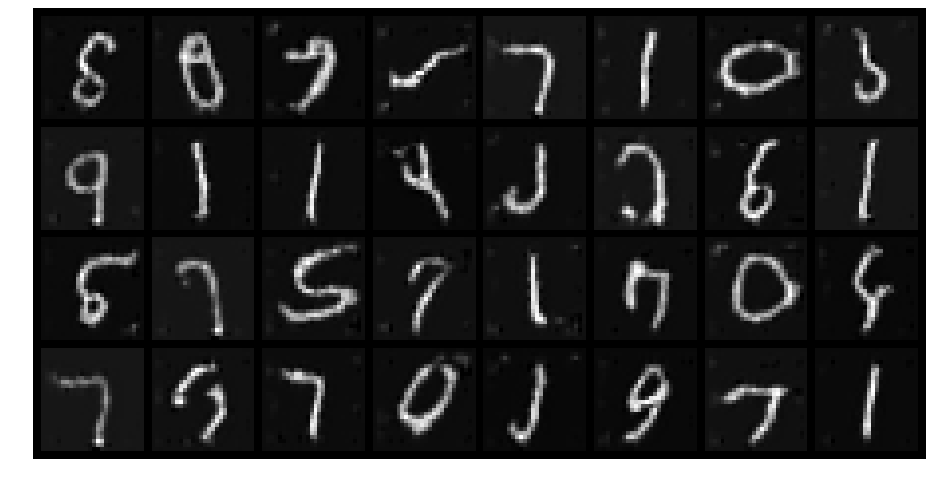

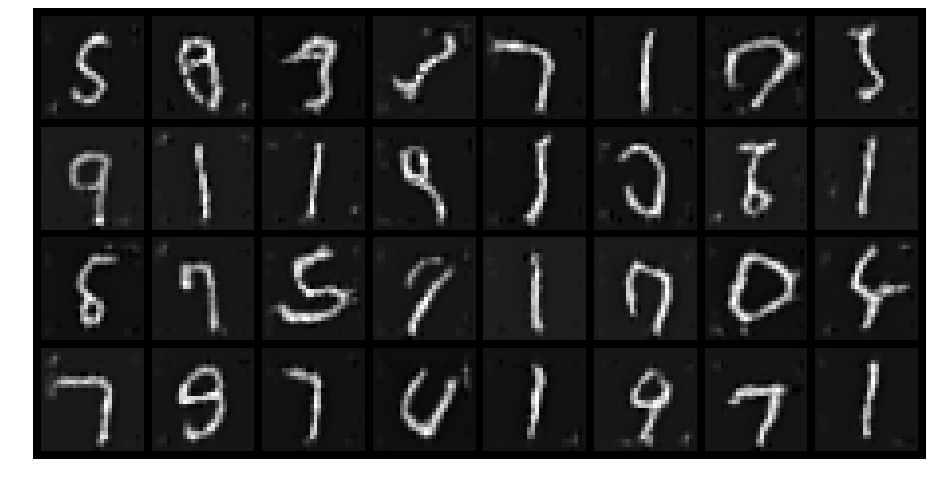

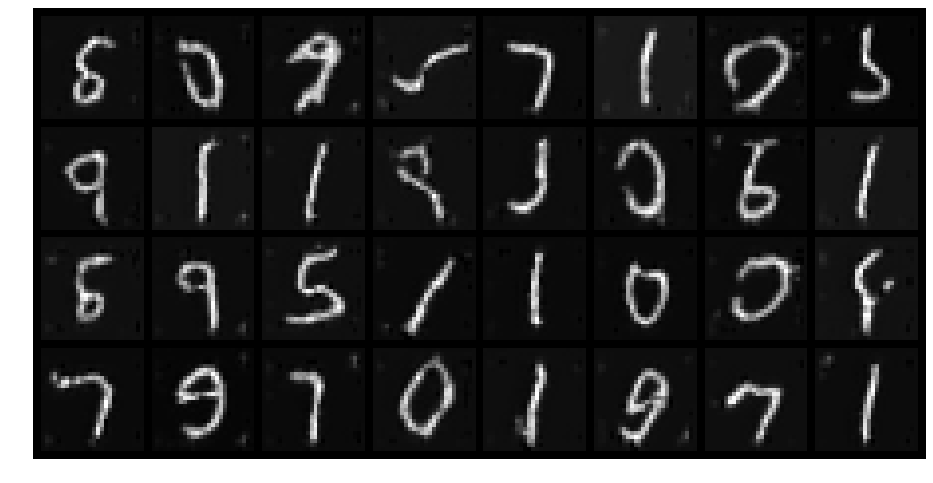

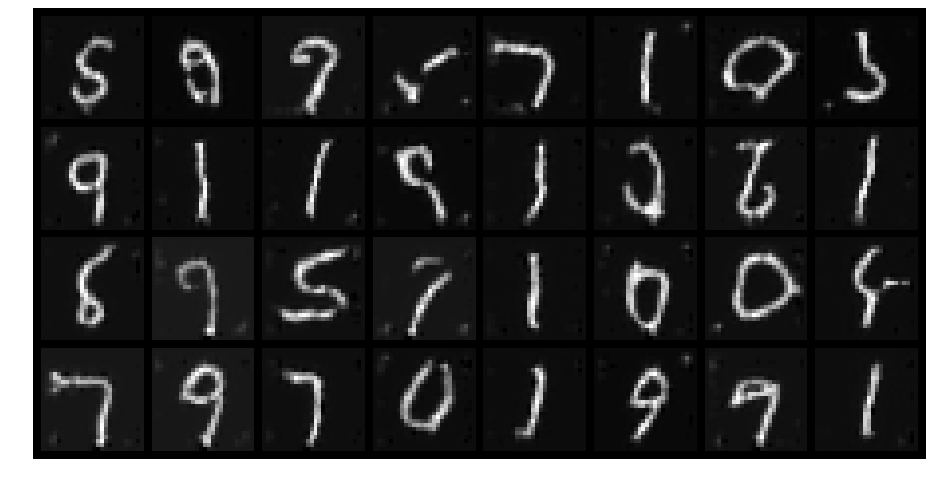

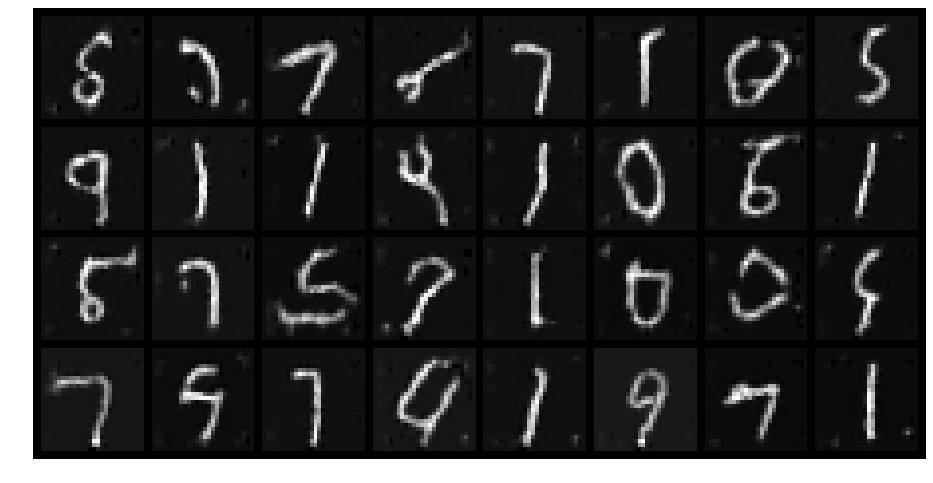

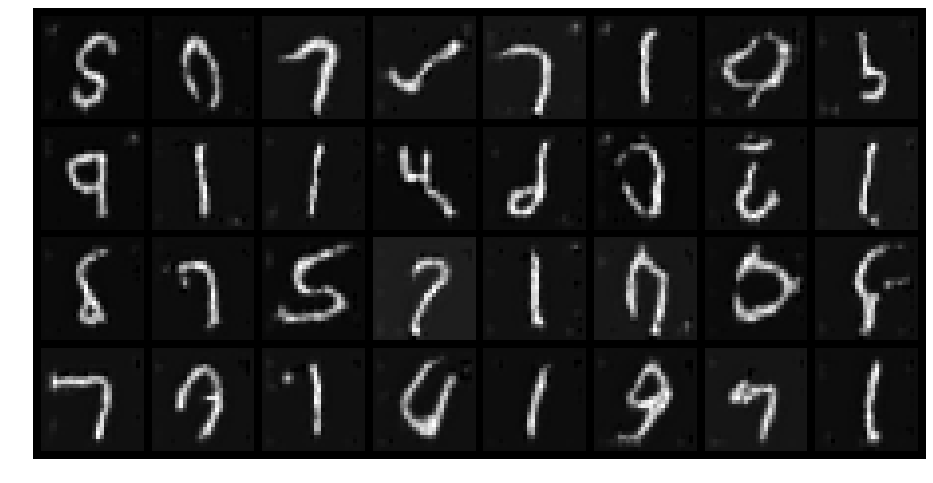

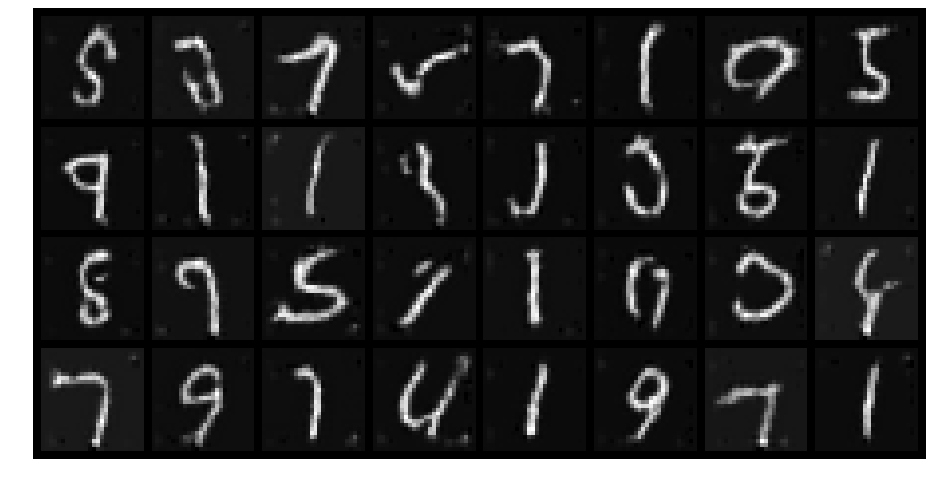

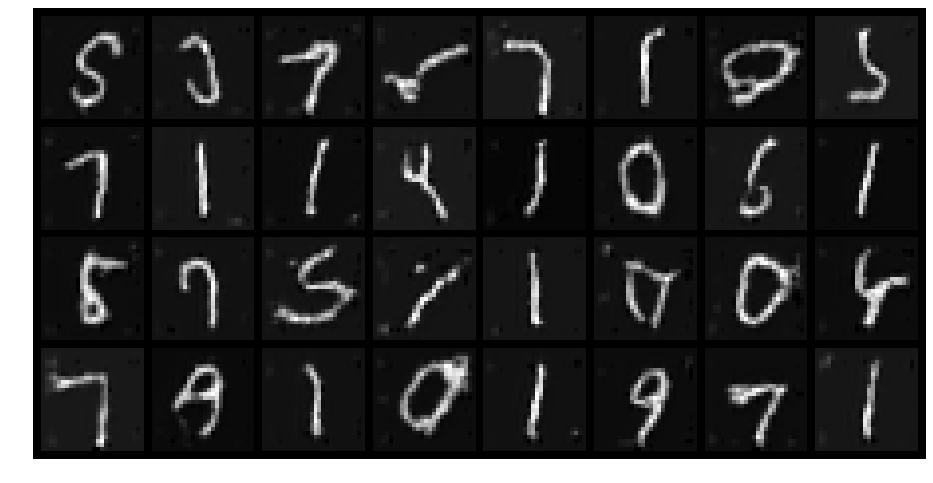

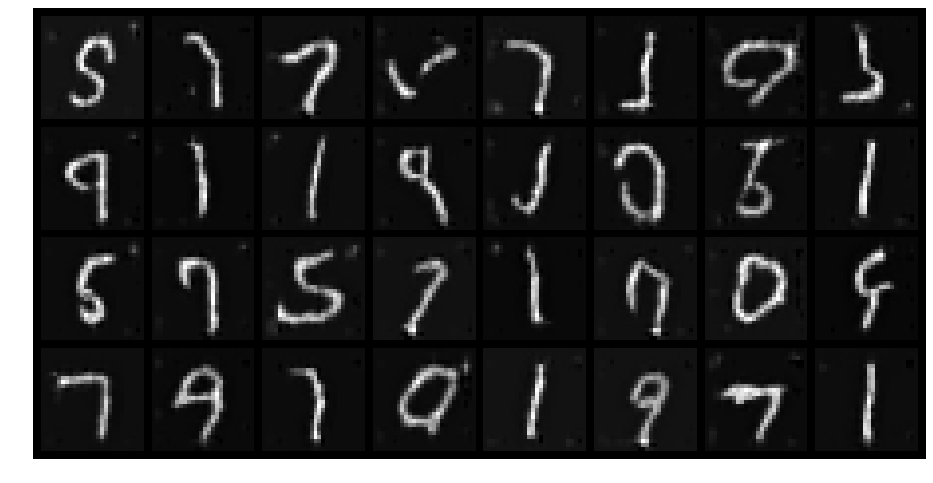

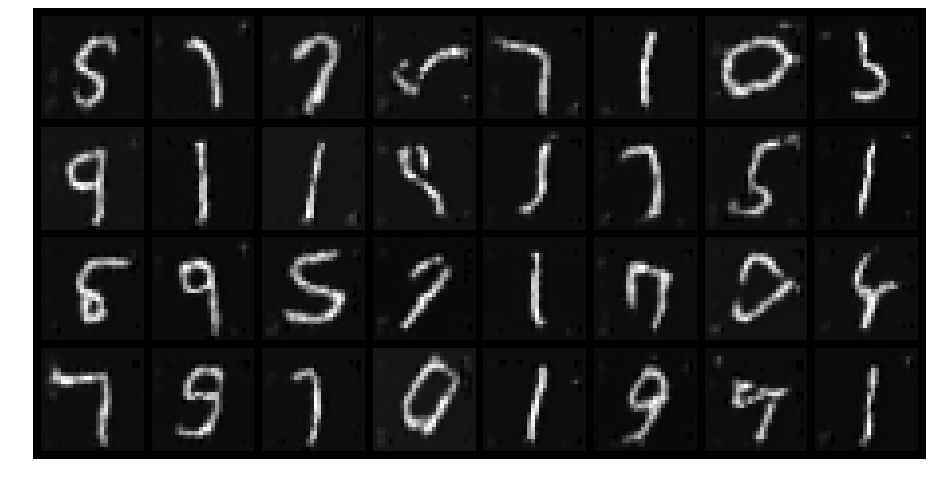

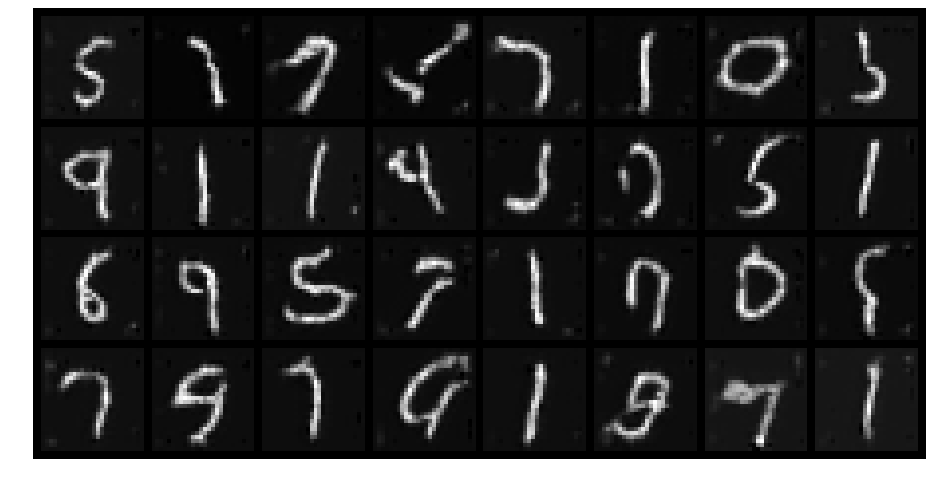

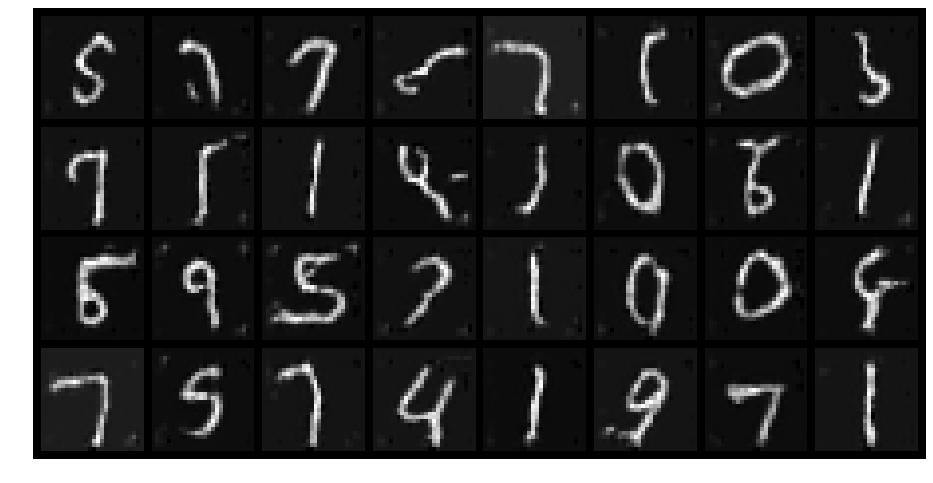

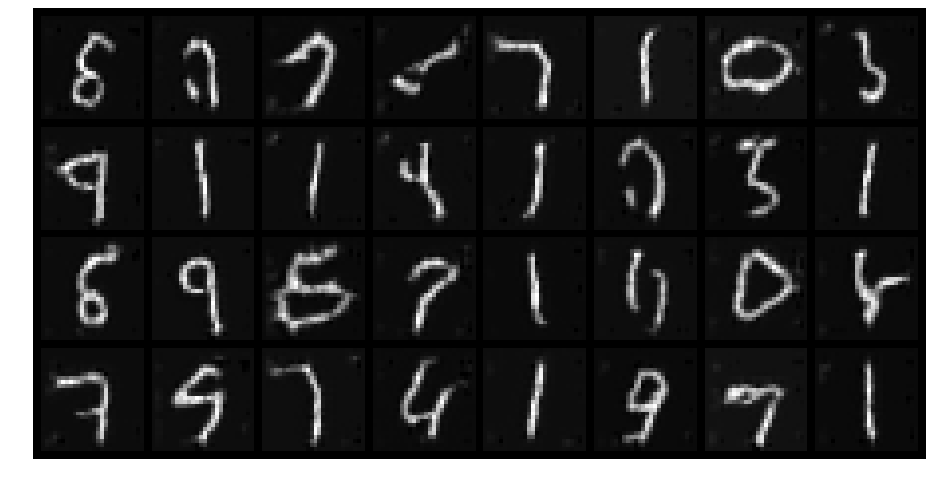

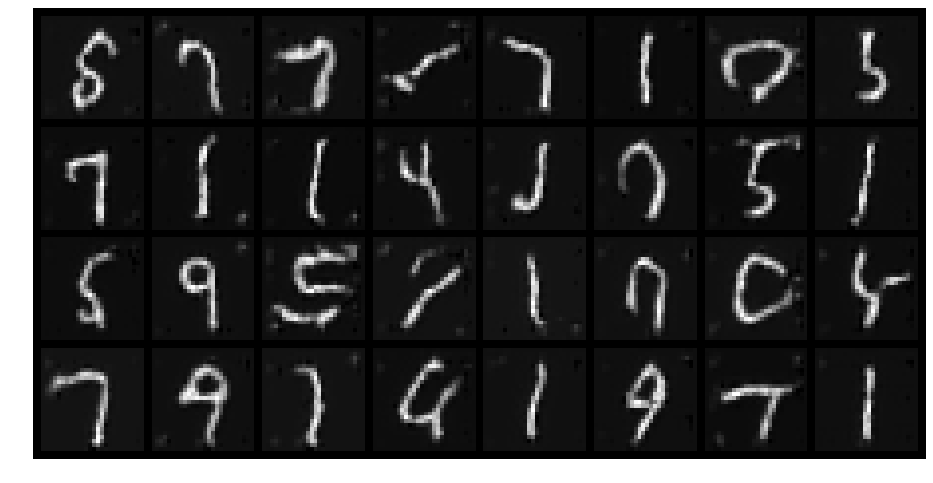

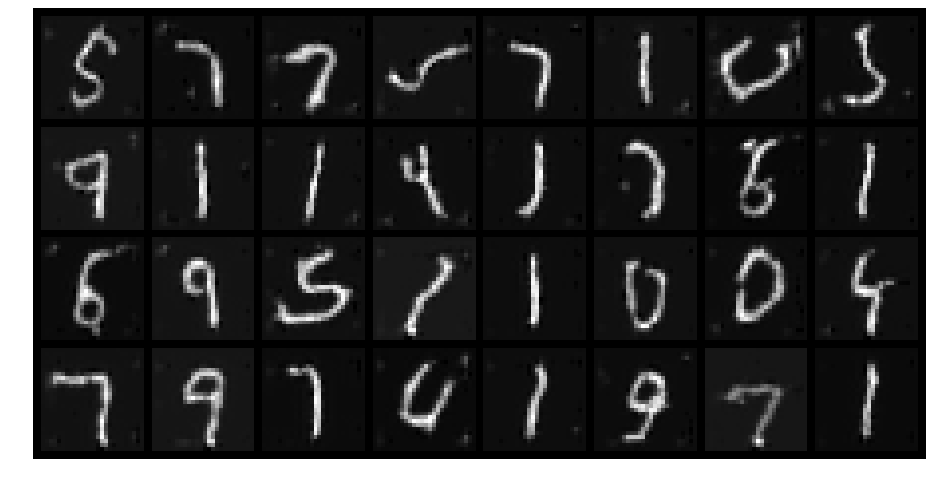

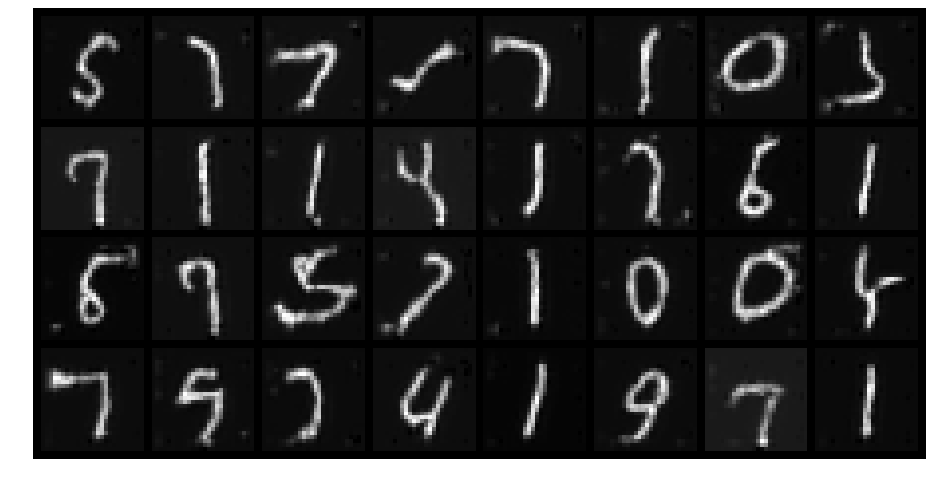

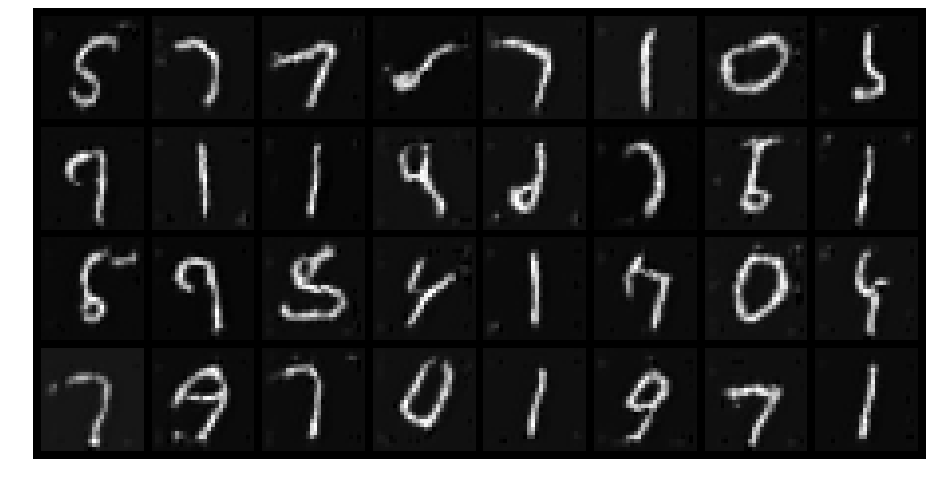

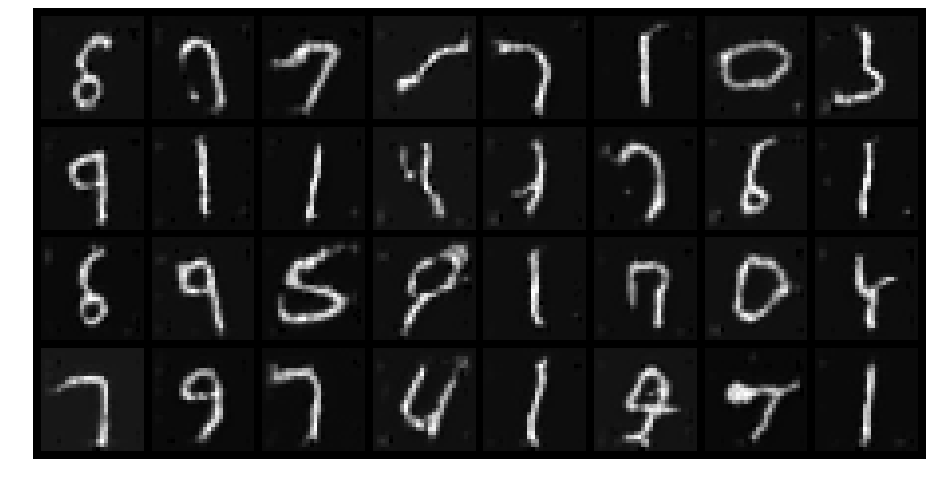

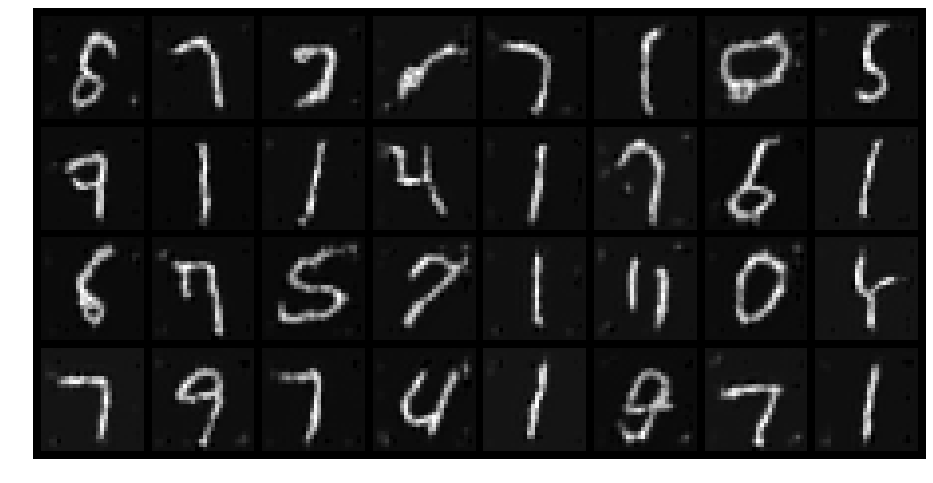

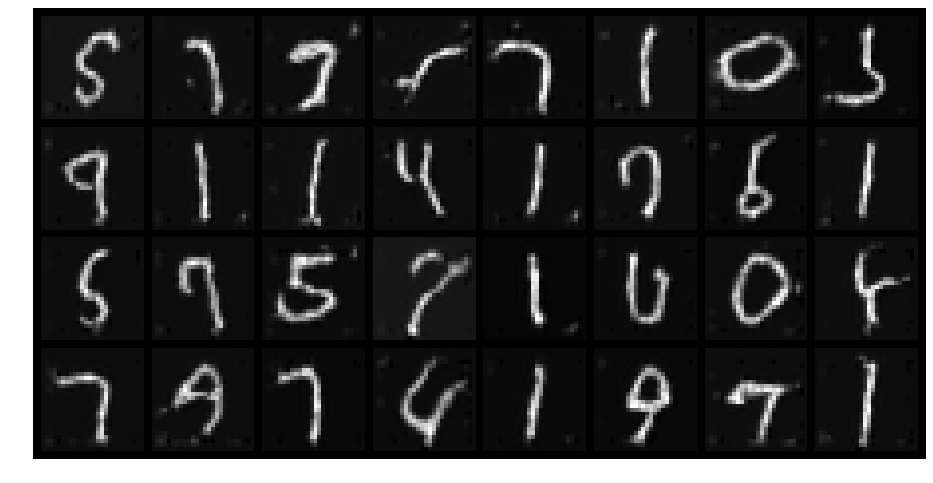

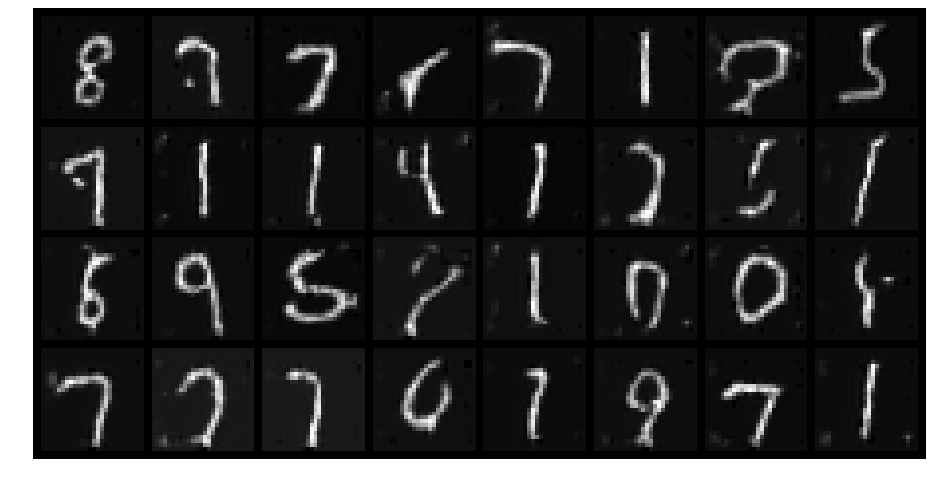

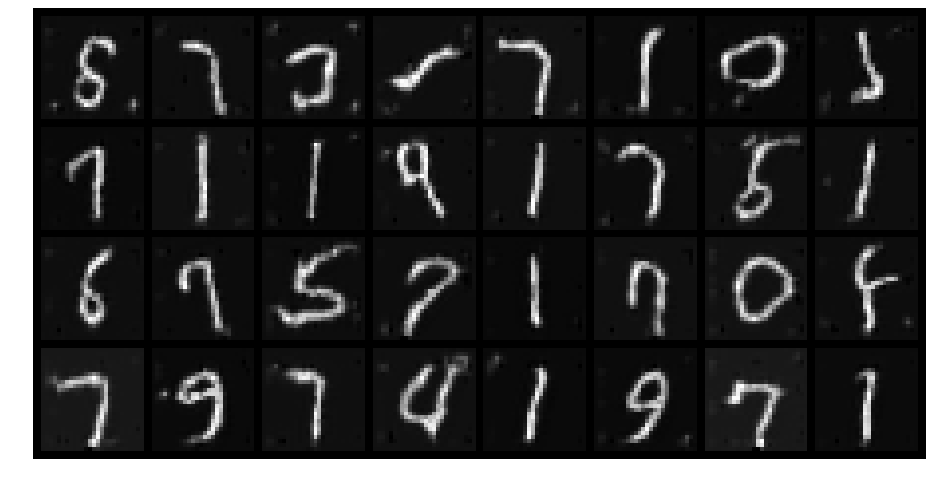

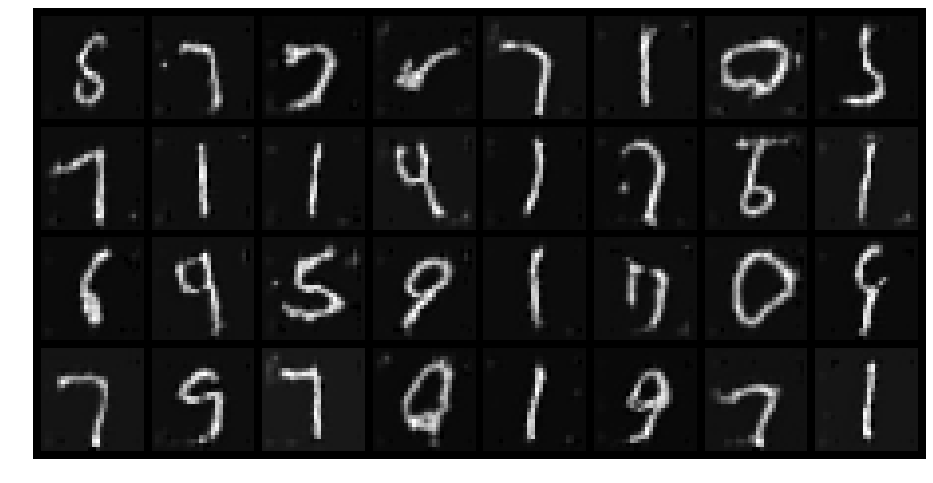

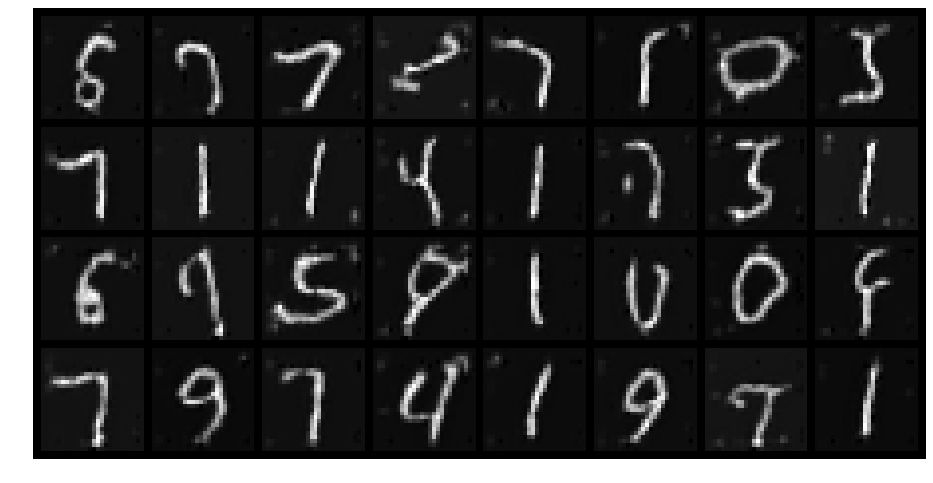

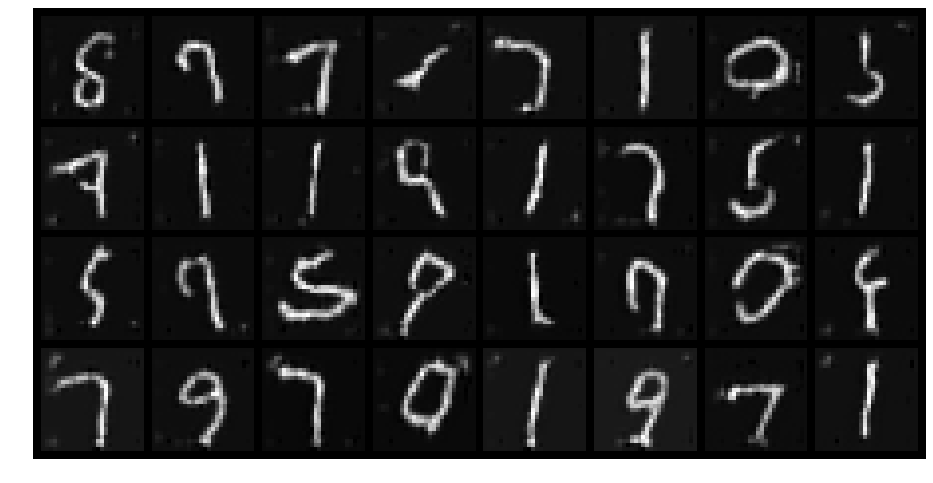

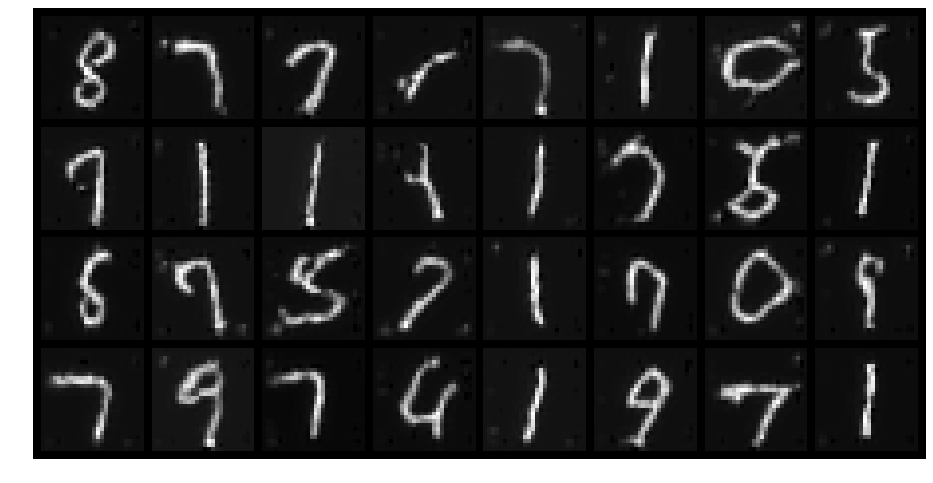

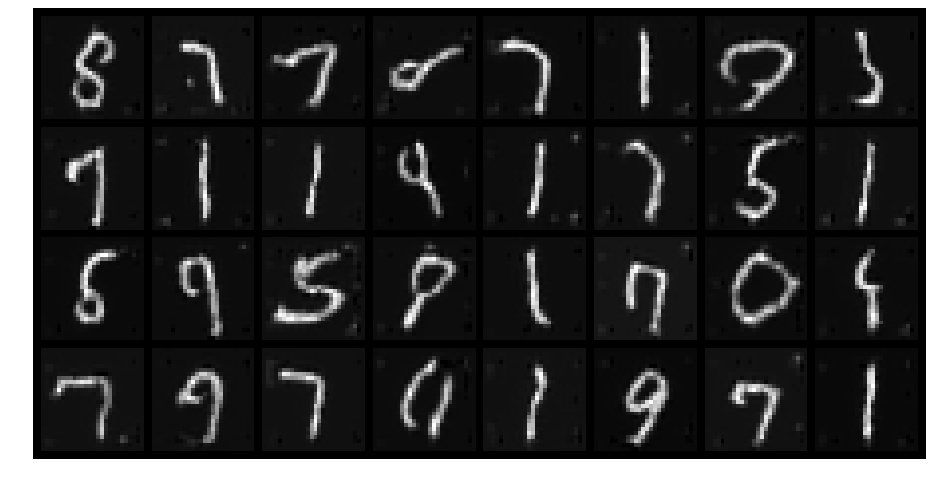

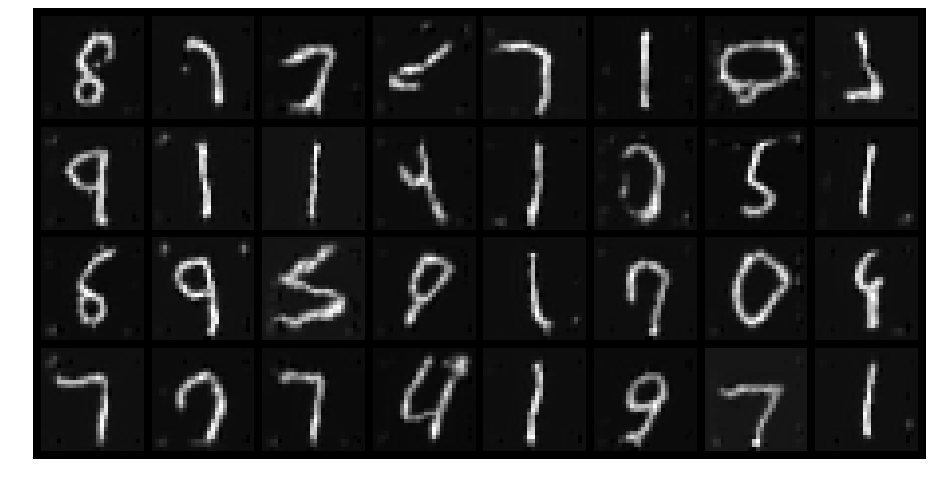

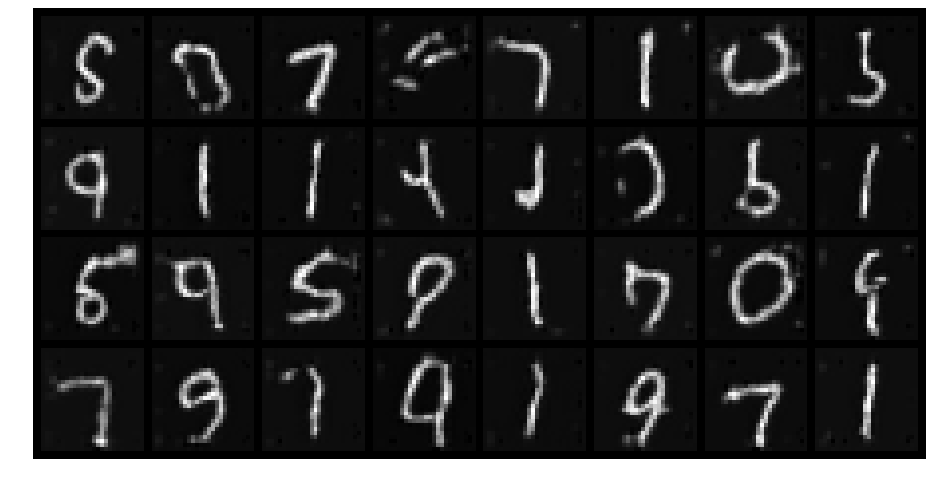

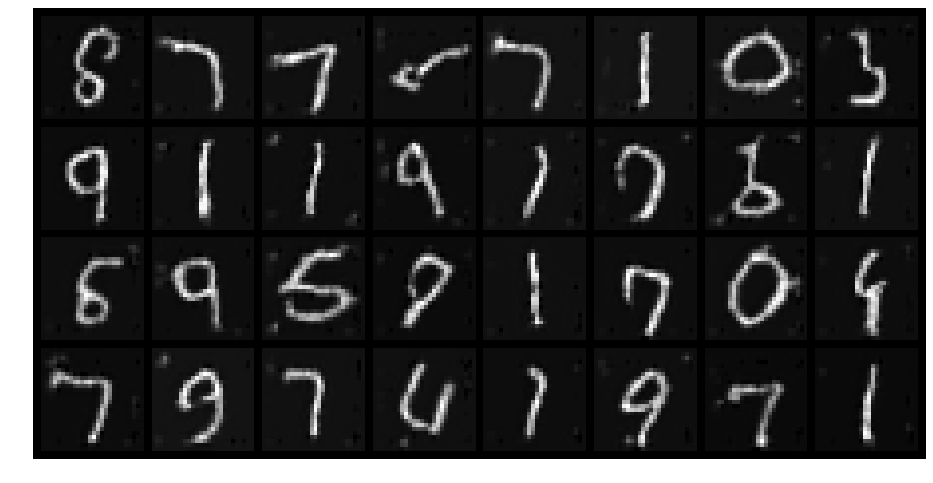

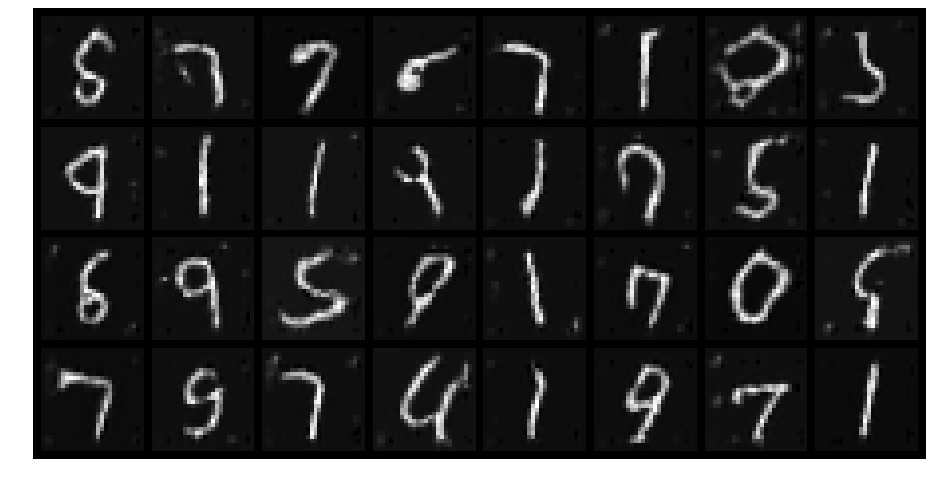

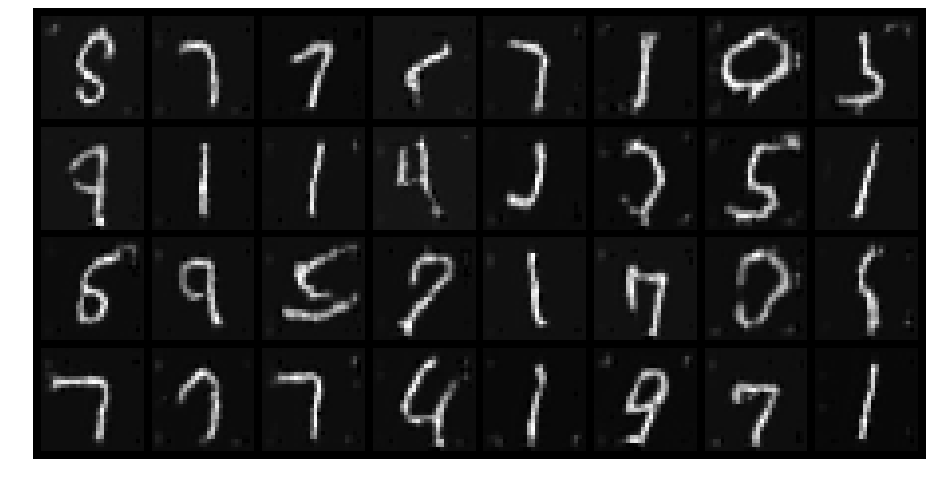

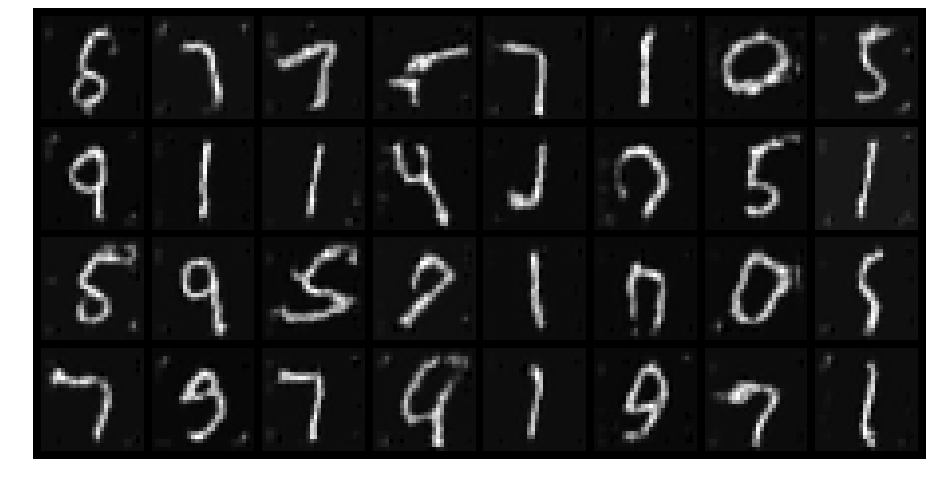

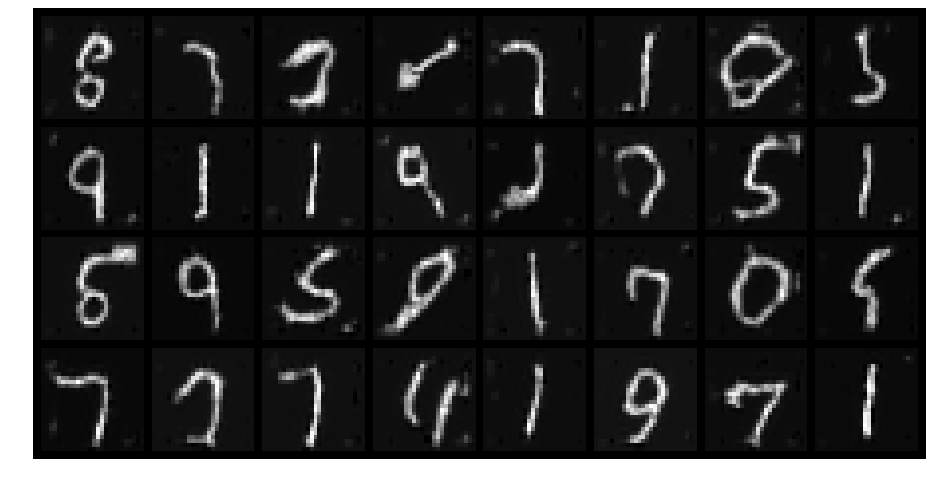

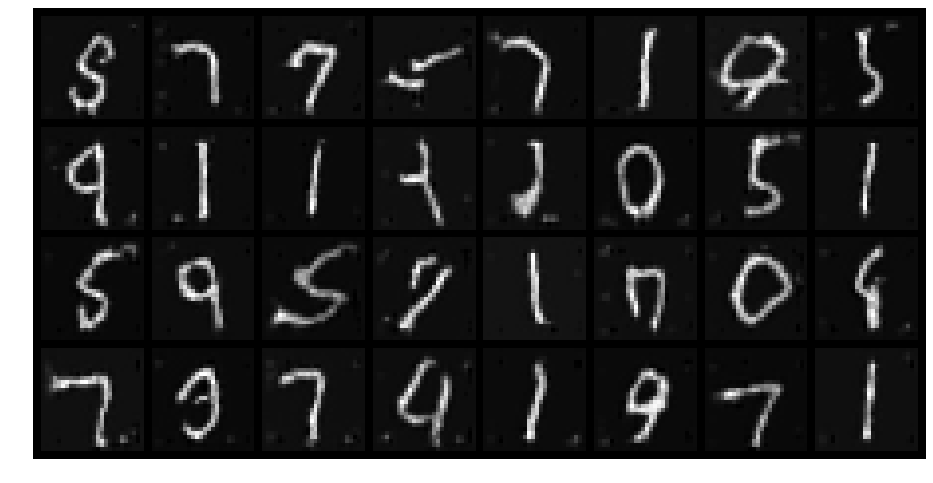

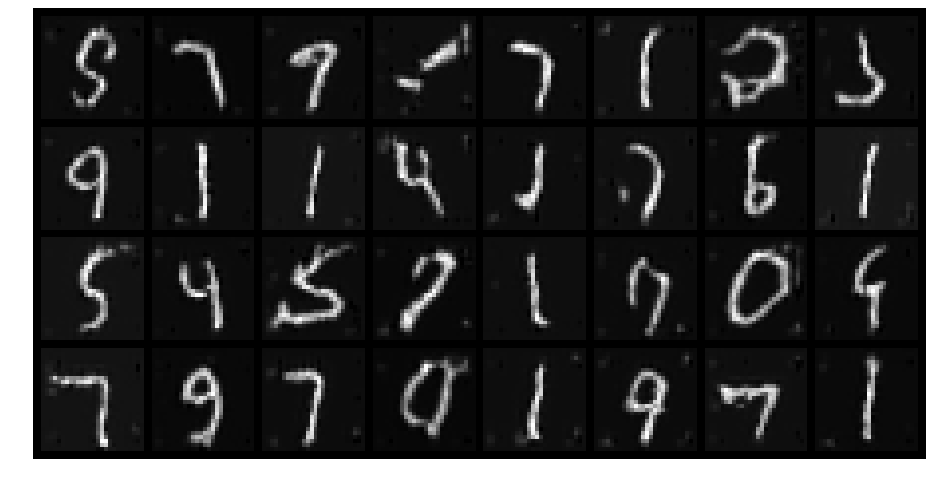

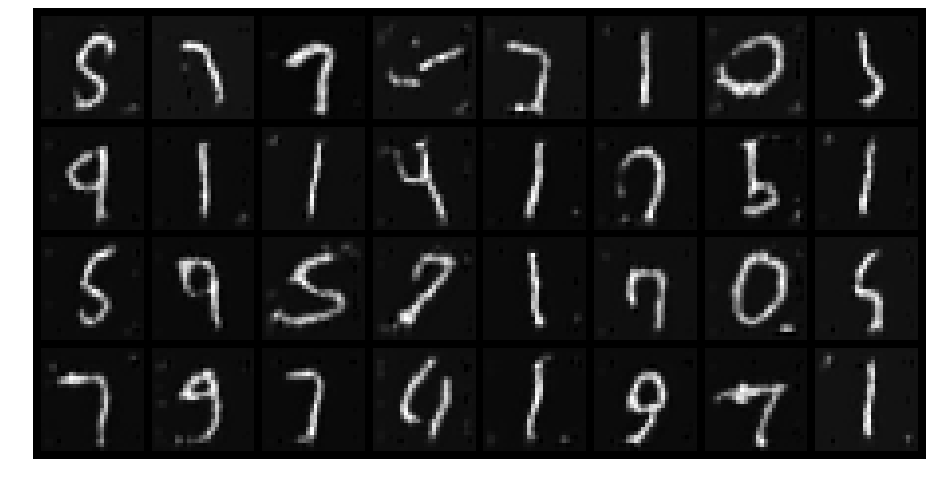

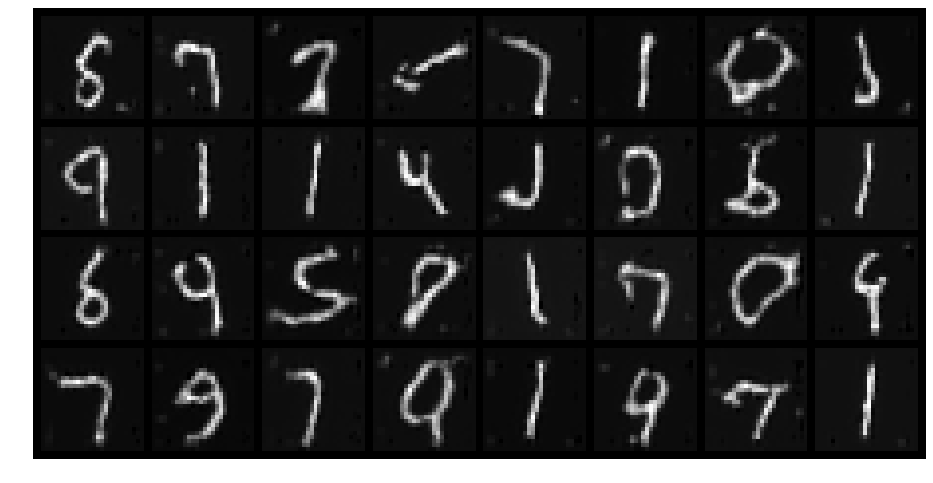

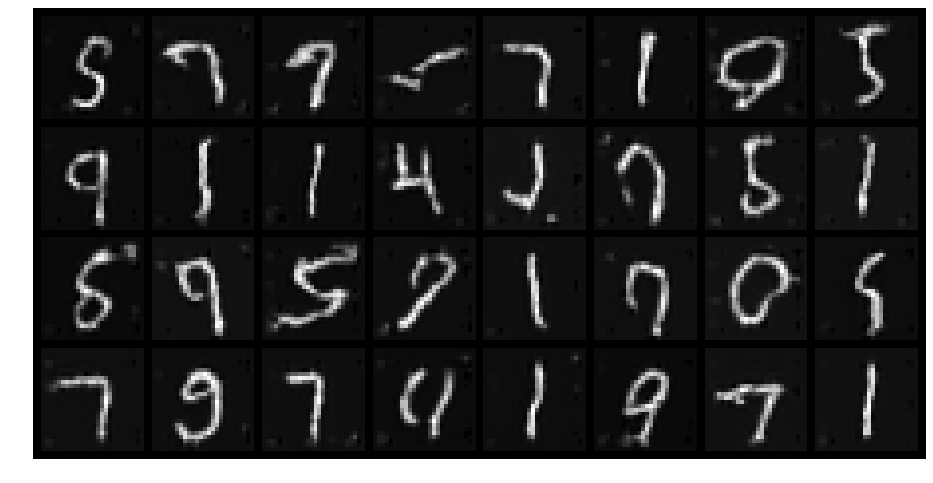

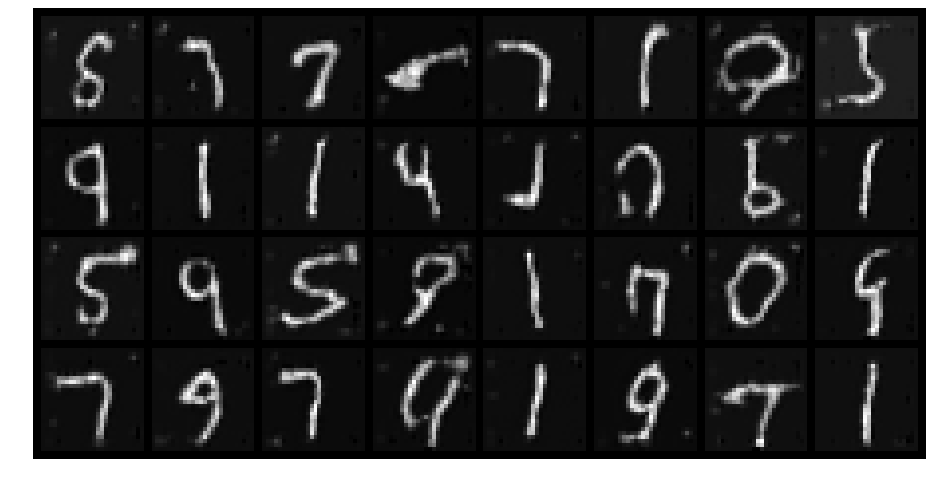

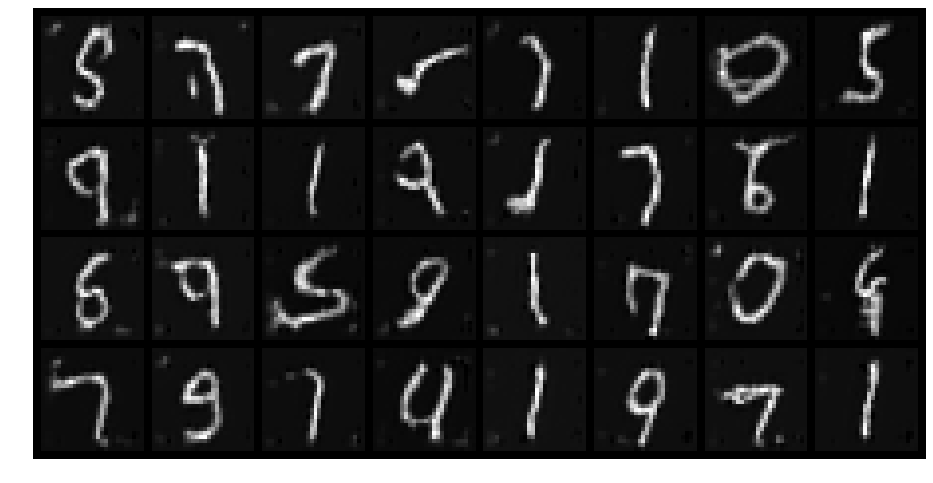

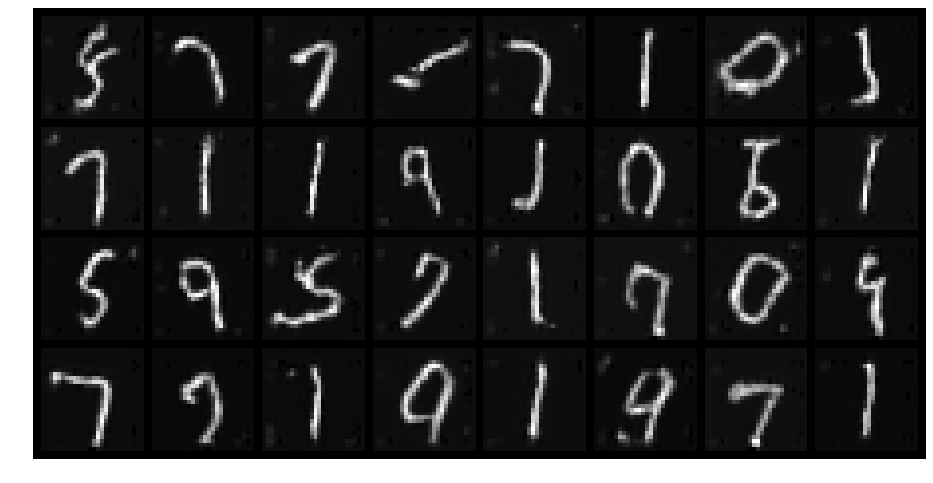

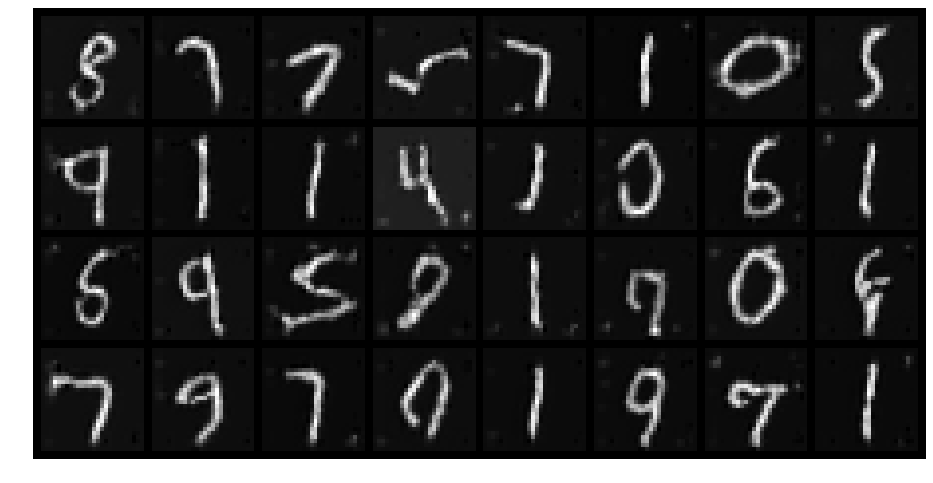

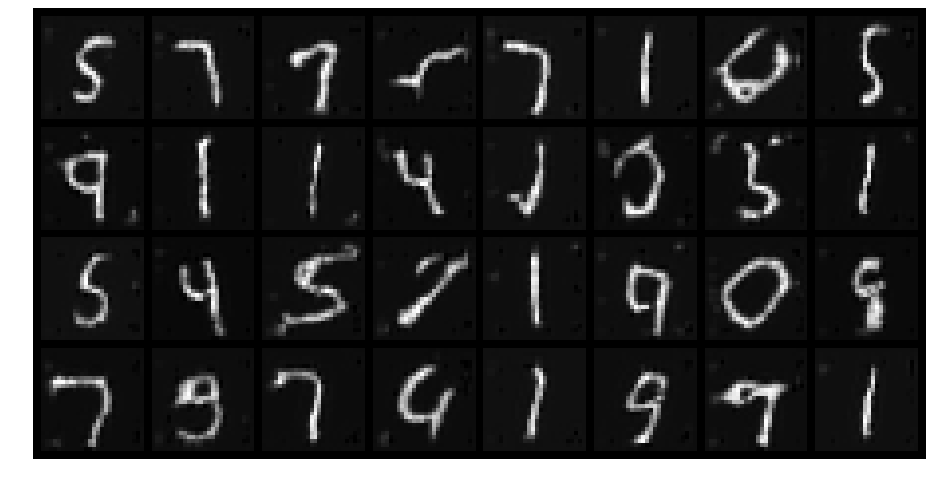

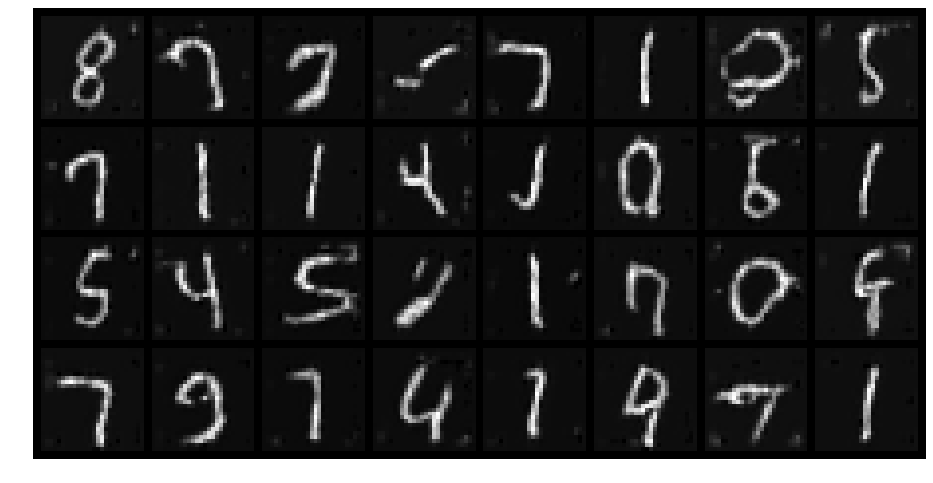

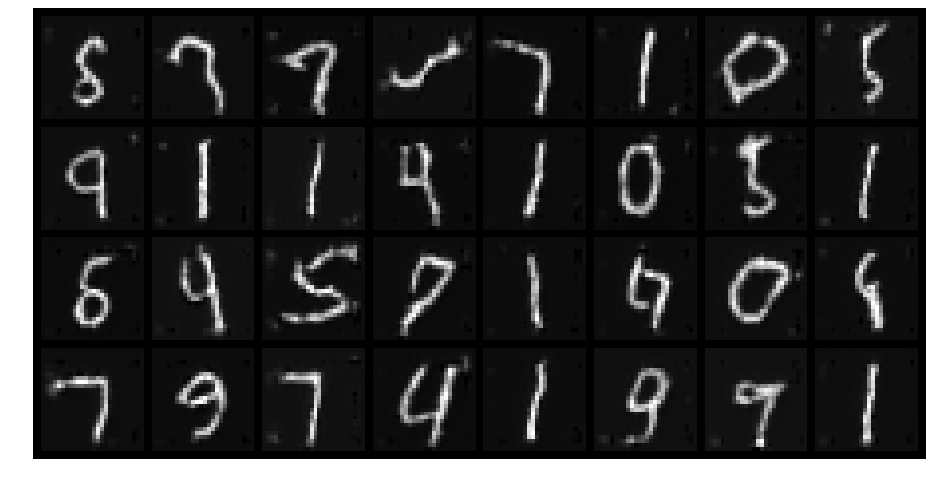

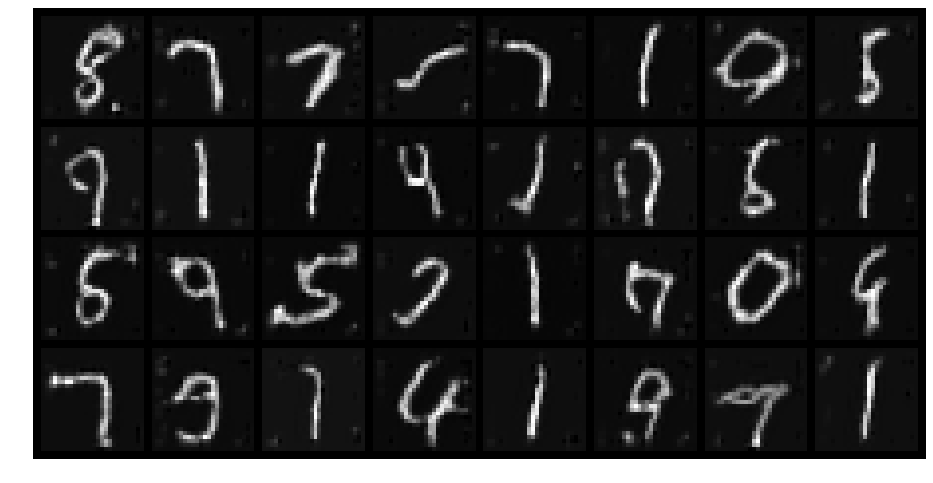

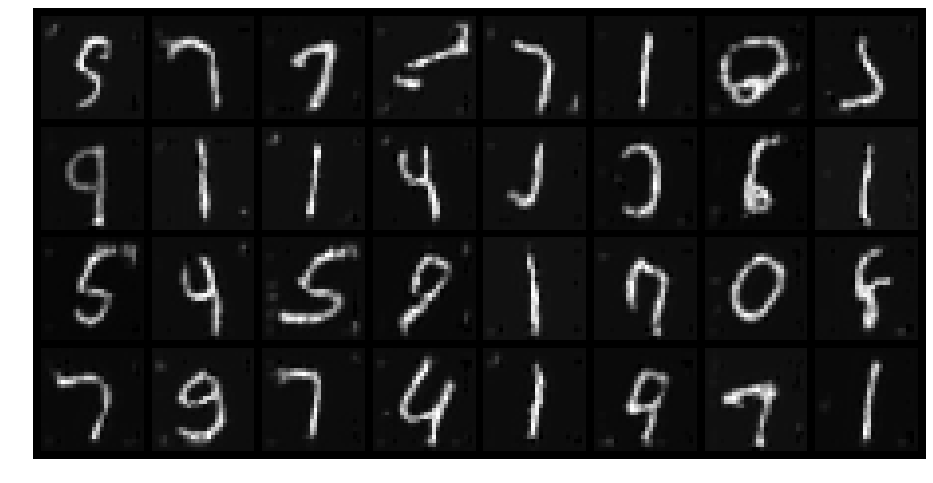

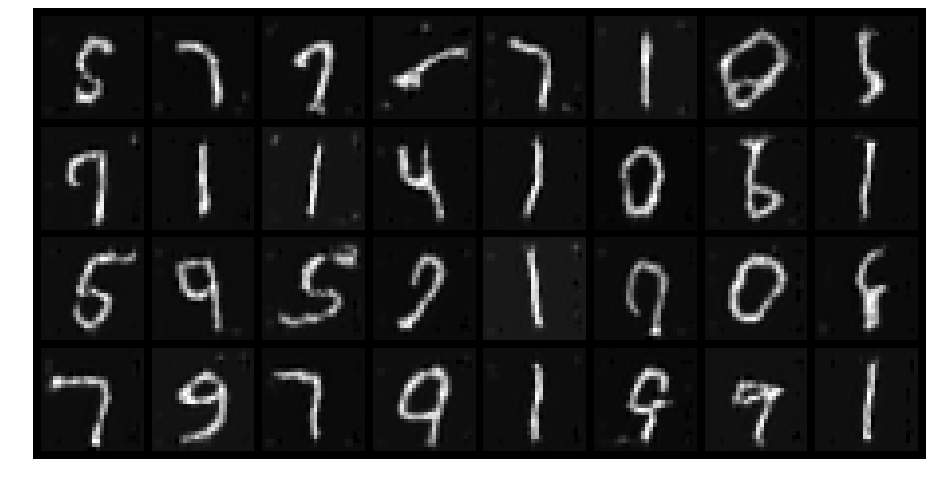

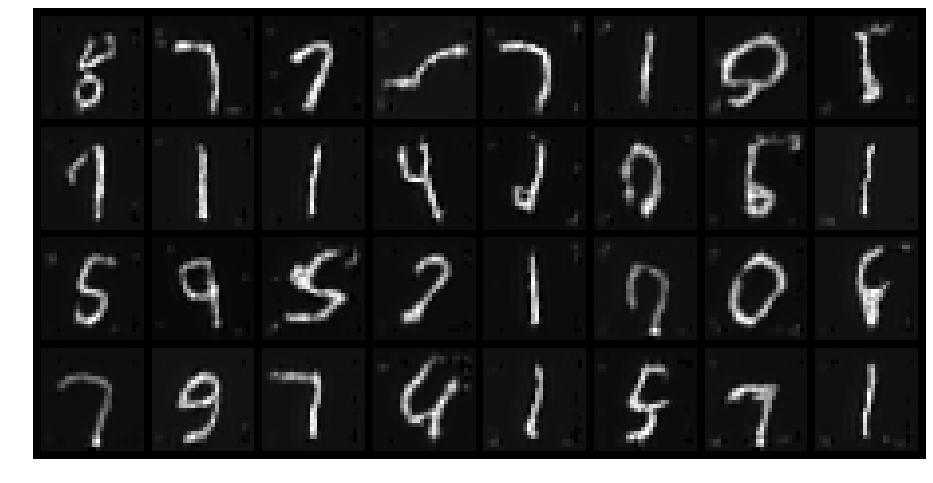

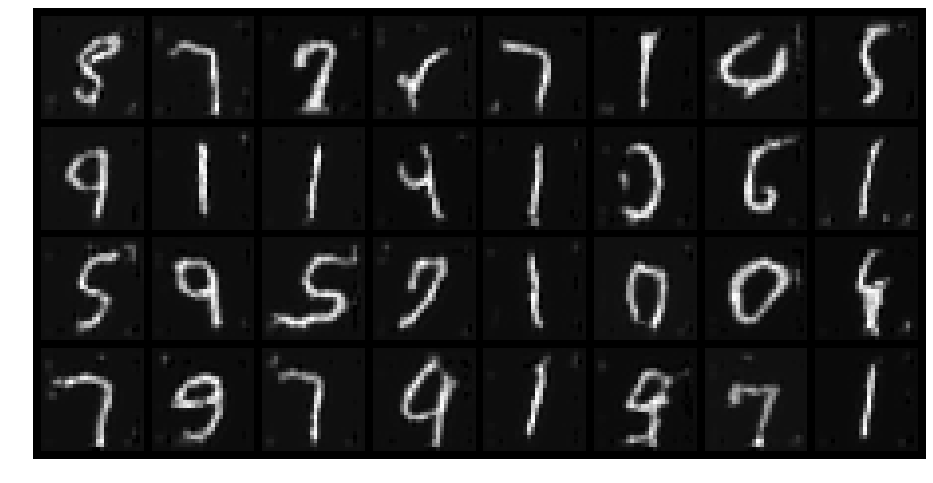

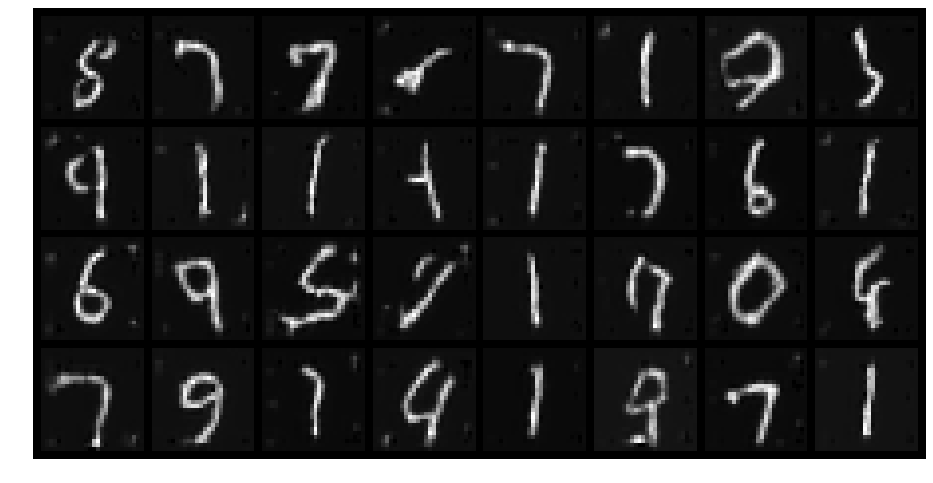

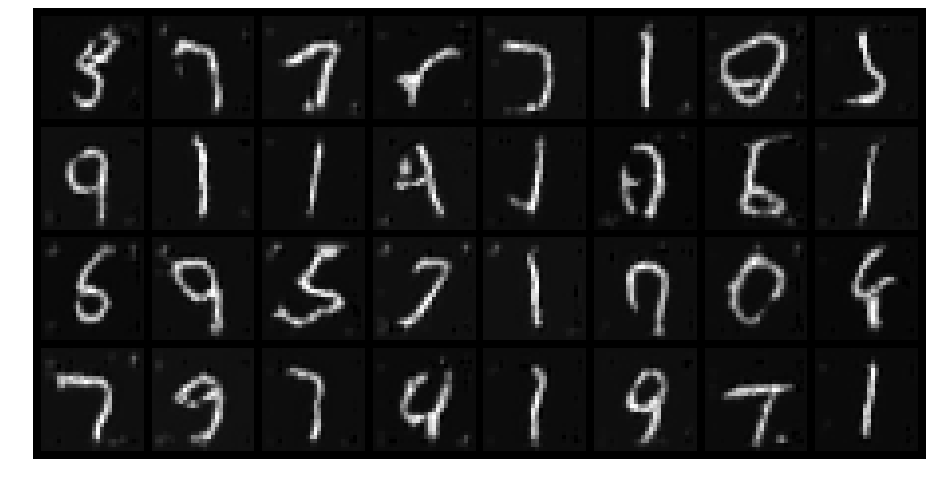

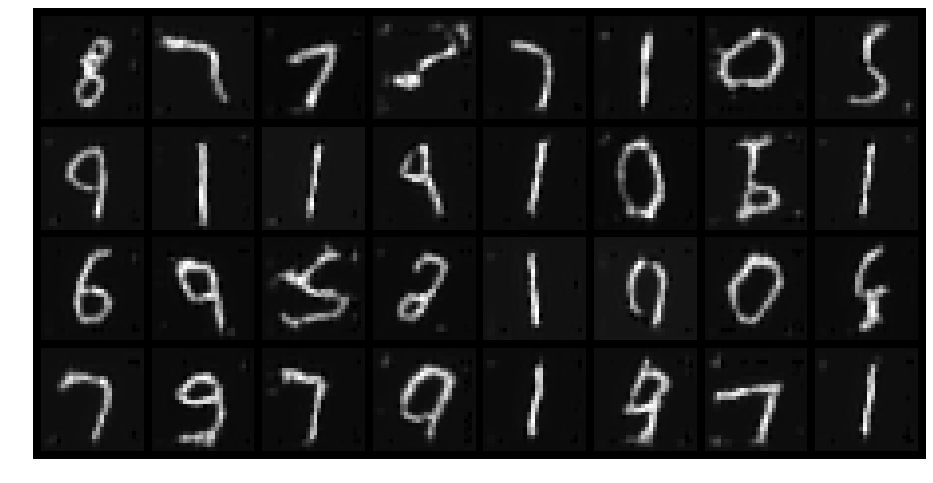

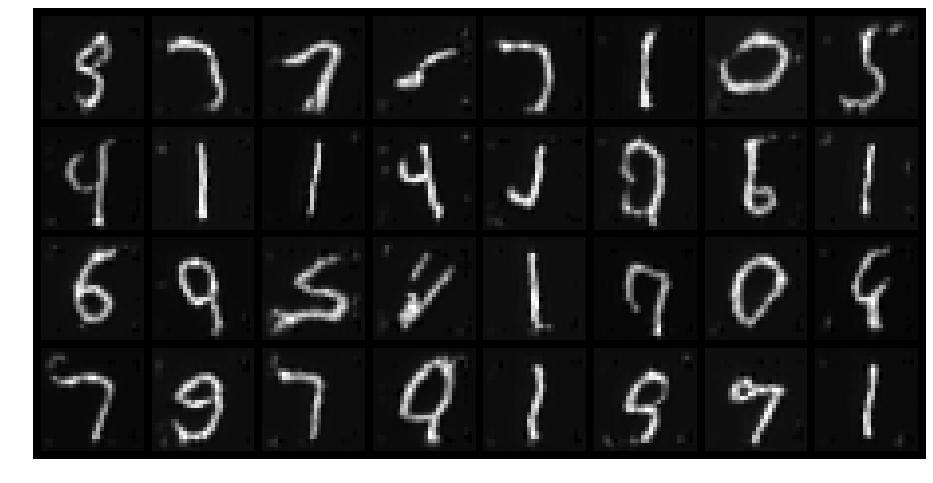

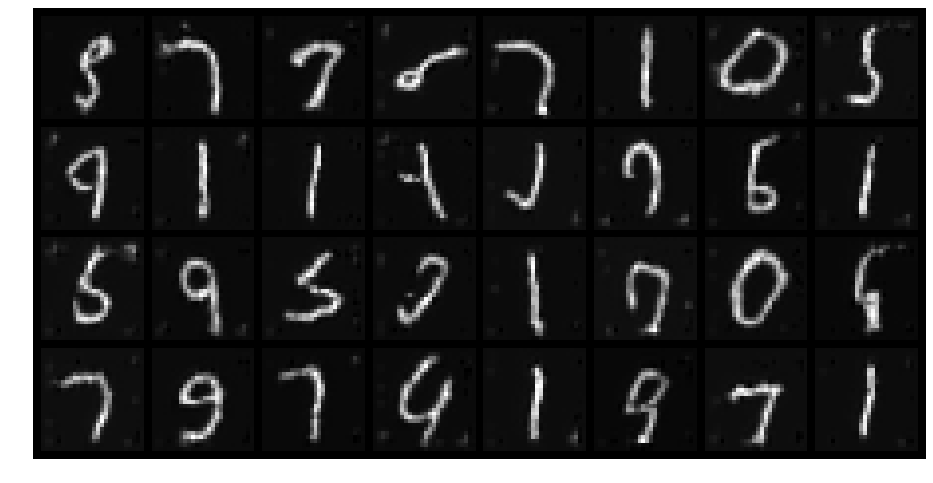

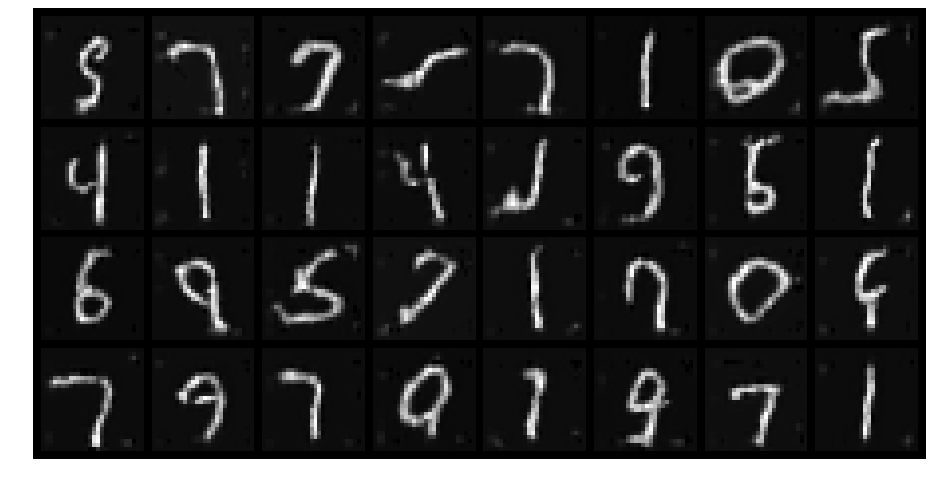

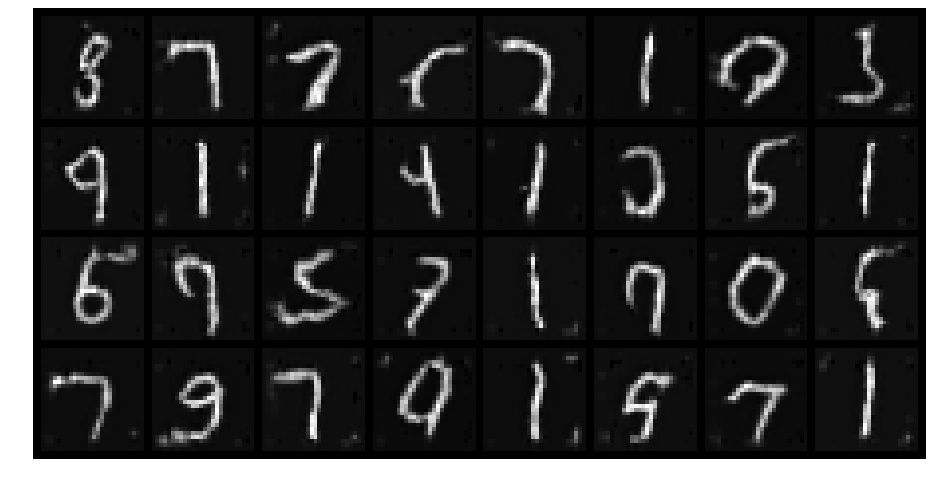

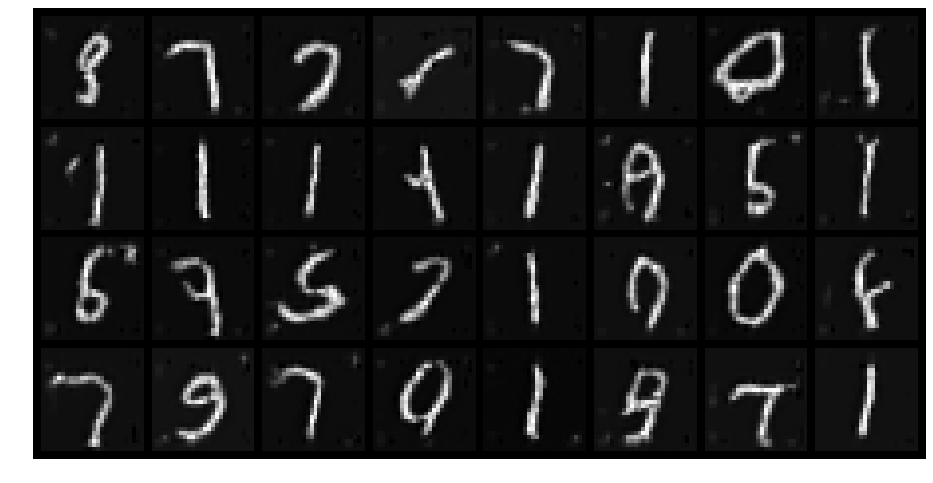

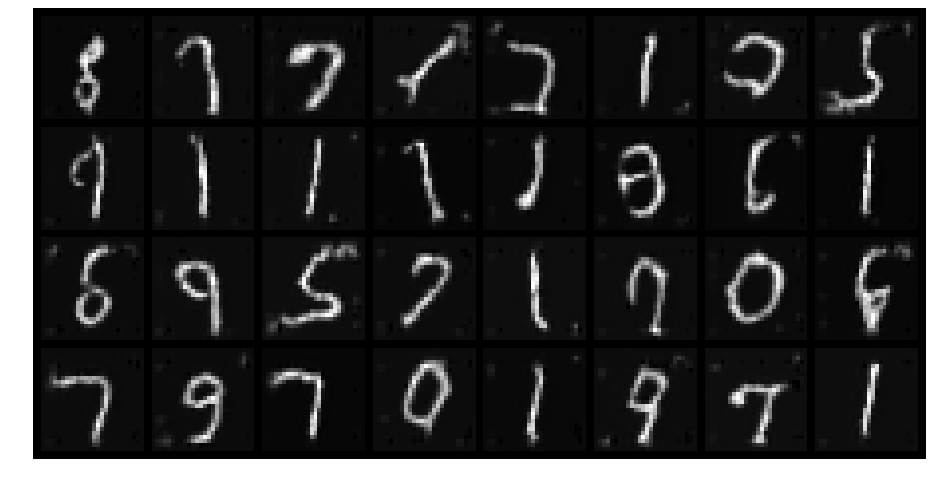

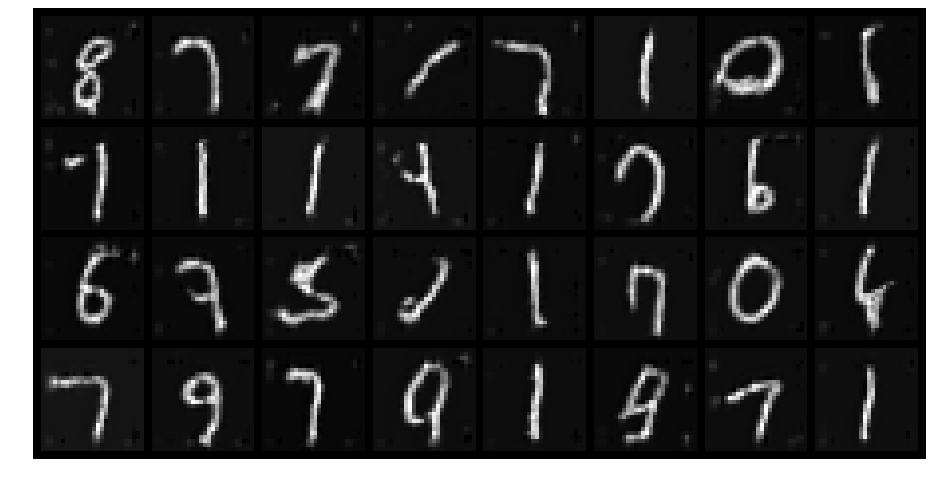

In [15]:
logger = Logger(model_name = "Vanilla GAN", data_name= 'MNIST')
num_epochs = 200
t = tqdm_notebook(range(num_epochs))

for epoch in t:
    for n,(img,_) in enumerate(train_dataloader):
    
        data_size = img.size(0)
        
        real_data = Variable(img).cuda()

        fake_data = gen(noise(data_size,latent_shape).cuda()).detach()

        dis_err, pred_real, pred_fake = train_dis(d_optim,real_data, fake_data)

        fake_data = gen(noise(data_size,latent_shape).cuda())

        gen_err, gen_preds = train_gen(g_optim,fake_data)
        logger.log(dis_err, gen_err,epoch,n,batch_size)
        
        if n % 5000 == 0:
            test_images = gen(test_noise.cuda()).view([32,1,26,26]).cpu()
            test_images = test_images.data
            
            logger.log_images(test_images, num_test_samples,epoch,n,batch_size)
            
    
    t.set_description('D-Err: {:.4f}, G-Err: {:.4f}'
               .format(dis_err,gen_err))